In [1]:
import sys
import numpy as np
import pandas as pd
import pymongo
import bson
import json
import time
import datetime
import os
import collections
import random
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization import keywords
import csv
import string
import re
import io
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from ast import literal_eval
import nltk
from nltk.corpus import stopwords
from collections import Counter
import gensim.downloader as api
import networkx as nx
import math
from tqdm import trange, tqdm
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk import word_tokenize
nltk.download('stopwords')
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import igraph as ig
import louvain
import leidenalg
stopwords = nltk.corpus.stopwords.words('english')
import hdbscan
import torch
from transformers import AutoTokenizer, BertTokenizer, BertModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import gensim
from gensim import corpora
import spacy
spacy.load('en')
from spacy.lang.en import English
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to /home/abose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-1-741cd8c34cf7>:44: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
# contractions_save = json.dumps(contractions)
# file = open("/home/abose/Threat Intel/contractions_save.json","w")
# file.write(contractions_save)
# file.close()
with open('/home/abose/Threat Intel/contractions_save.json') as file:
    contractions = json.load(file)

In [3]:
def extend_doc(doc):
    tokens = doc.split()
    for idx, token in enumerate(tokens):
        if token in contractions:
            tokens[idx]=contractions[token]
    tokens = ' '.join(tokens)
    return tokens

In [4]:
def hook_compound(input_termList):
#     if not input_termList or input_termList == None or input_termList == "":
#         return input_termList
    # maximum edit distance per dictionary precalculation
    symSpell_1st_TotalTweetText=[]
    max_edit_distance_dictionary = 2
    prefix_length = 7
    # create object
    sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
    # load dictionary
    dictionary_path = os.path.join(os.path.dirname("E:\\Threat_Intel_Research\\"),"frequency_dictionary_en_82_765.txt")
    term_index = 0  # column of the term in the dictionary text file
    count_index = 1  # column of the term frequency in the dictionary text file
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
        return

    # max edit distance per lookup (per single word, not per whole input string)
    max_edit_distance_lookup = 2
    input_term2 = re.sub(r"http\S+", "", input_termList)
    suggestions = sym_spell.lookup_compound(input_term2, max_edit_distance_lookup)
    for suggestion in suggestions:
        symSpell_1st_TotalTweetText.append(suggestion.term)
 
    return symSpell_1st_TotalTweetText

In [5]:
def mainLookUp(input_termLookList):
#     if not input_termLookList or input_termLookList == None or input_termLookList == "":
#         return input_termLookList
    symSpell_2nd_TotalTweetText=[]
    # maximum edit distance per dictionary precalculation
    max_edit_distance_dictionary = 0
    prefix_length = 7
    # create object
    sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
    # load dictionary
    dictionary_path = os.path.join(os.path.dirname("E:\\Threat_Intel_Research\\"),"frequency_dictionary_en_82_765.txt")
    term_index = 0  # column of the term in the dictionary text file
    count_index = 1  # column of the term frequency in the dictionary text file
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
        return

    # a sentence without any spaces
    if input_termLookList:
        result = sym_spell.word_segmentation(input_termLookList)
        symSpell_2nd_TotalTweetText.append(result.corrected_string)
    return symSpell_2nd_TotalTweetText

In [6]:
def clean_doc(doc):
    # split into tokens by white space
    #doc = re.sub(r\"http\\S+\", \"\", doc)
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords)
    tokens = [w for w in tokens if not w in stop_words]
    #tokens = [stemmer.stem(t) for t in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [7]:
def process_text(text):
    text = extend_doc(text)
#     textSpell = hook_compound(text)
#     if len(textSpell[0])>=5:
#         textSpell = mainLookUp(textSpell[0])
#         cleanedText = clean_doc(textSpell[0])
    if len(text)>=5:
        cleanedText = clean_doc(text)
    else:
        cleanedText="NAAAN"
    return cleanedText

In [8]:
#define vectorizer parameters
def apply_TFIDF(fname):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99,lowercase=True, max_features=200000,min_df=0.001, stop_words='english', use_idf=True)
    #check_mat=tfidf_vectorizer.fit(fname)
    #print("check ", check_mat.vocabulary_)
    tfidf_matrix = tfidf_vectorizer.fit_transform(fname) #fit the vectorizer to synopses
    #print(tfidf_matrix.shape, tfidf_matrix[0,0], tfidf_matrix[0,1], tfidf_matrix[0,2], tfidf_matrix[0,3])
    terms = tfidf_vectorizer.get_feature_names()
    #print(tfidf_matrix.shape, " + ",terms, tfidf_vectorizer.idf_)
    print(" + ", tfidf_matrix.shape, " + ")
    return tfidf_matrix

In [9]:
def userObjectDictionaryFunction():
    connection=pymongo.MongoClient()
    srcUserDB=connection.user_src_identification
    collection=srcUserDB.taggedData40k
    cursor=collection.find({},{"_id":0}).limit(40761)
    userObjectData=[]
    userIdDict=dict()
    for data in cursor:
        userDataDict=dict()
        for key, value in data.items():
            if key=="id":
                userID=value
                userDataDict.update({"noKey_userID":value})
            if key=="Description":
                userDataDict.update({"Description":value})
            if key=="DescTag":
                userDataDict.update({"DescTag":value})
            if key=="Followers":
                userDataDict.update({"Followers":value})
            if key=="Following":
                userDataDict.update({"Following":value})
            if key=="Tweets":
                userDataDict.update({"Tweets":value})
            if key=="TweetsTags":
                userDataDict.update({"TweetsTags":value})
            if key=="AllText":
                userDataDict.update({"AllText":value})
            if key=="AllTextTags":
                userDataDict.update({"AllTextTags":value})
        userIdDict.update({int(userID):userDataDict})
    return userIdDict
userIdDict = userObjectDictionaryFunction()

In [10]:
len(userIdDict)

40761

In [11]:
def create_Json_Processed_Data_File():
    for userID, entries in userIdDict.items():
        processedTweetTextList = list()
        if "Tweets" in entries:
            if len(entries["Tweets"]) != 0:
                for tweetText in entries["Tweets"]:
                    if len(tweetText) <= 5:
                        continue
                    else:
                        processedTweetTextList.append(process_text(tweetText))
                entries.update({"Tweets":processedTweetTextList})
            else:
                del userIdDict[userID]["Tweets"]
        if "AllText" in entries:
            if len(entries["AllText"]) >= 5:
                entries.update({"AllText":process_text(entries["AllText"])})
            elif "Tweets" in entries and len(entries["AllText"]) < 5 and len(entries["Tweets"]) >= 2:
                entries.update({"AllText":' '.join(processedTweetTextList)})
            else:
                del userIdDict[userID]["AllText"]
        if "Description" in entries:
            if len(entries["Description"]) >= 5:
                entries.update({"Description":process_text(entries["Description"])})
            else:
                del userIdDict[userID]["Description"]
        if 'DescTag' in entries:
            if len(entries['DescTag']) == 0:
                del userIdDict[userID]['DescTag']
    with open('userIdDict.json', 'w') as fp:
        json.dump(userIdDict, fp)
create_Json_Processed_Data_File()

In [12]:
######## Only For Validation #########
validation_DF = pd.read_json("annotated_smallNetwork.json", lines=True)
nodeId_Set= set(validation_DF['id'])
valid_userIdDict = {nodeID:userIdDict[nodeID] for nodeID in nodeId_Set if nodeID in userIdDict}
validation_DF.head(5)

id                                        Description  \
0  1161296115637084162  #Spider Overlord calling #darknet home. Talk #...   
1  1112062964260110336  🍣 researcher 🦕 pentester 😈 web monkey 🙊 datteb...   
2   985304744146202624  bebe gay III 🏳️‍🌈 ه҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈...   
3   861889353869557762  Hi, it's me // SEO Class of 2008 // Autodidact...   
4   733074959338213379                        Cybersecurity is a ILLUSION   

                                             DescTag  \
0  [/technology and computing/hardware/computer c...   
1  [/technology and computing/internet technology...   
2                                [/society/gay life]   
3  [/technology and computing/internet technology...   
4  [/technology and computing/computer security, ...   

                                              Tweets  \
0  [A wild sponsor appears!  Two more bundles hat...   
1  [Perhaps currently I 'm going through the most...   
2                                                 []   
3  [Airbnb markets are crazy right now https://t....   
4                                                 []   

                                          TweetsTags  \
0  [[/style and fashion/luxury goods, /pets/large...   
1  [[/society/unrest and war, /art and entertainm...   
2                                                 []   
3  [[/travel/vacation rentals, /finance/investing...   
4                                                 []   

                                             AllText  \
0  A wild sponsor appears!  Two more bundles hath...   
1  @alicanact60 @Hacker0x01 👍👍👍👍👍@SecGoblin @root...   
2  bebe gay III 🏳️‍🌈 ه҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈...   
3  Airbnb markets are crazy right now https://t.c...   
4                        Cybersecurity is a ILLUSION   

                                         AllTextTags  \
0  [/art and entertainment/movies and tv/movies, ...   
1  [/technology and computing/hardware, /technolo...   
2                                [/society/gay life]   
3  [/food and drink/vegetarian, /food and drink/v...   
4  [/technology and computing/computer crime, /te...   

                                           Followers  \
0  [1112062964260110336, 985304744146202624, 1304...   
1         [1229142485823315968, 28482605, 773838475]   
2                                                 []   
3  [1026799219716177920, 1134088559617630208, 117...   
4                                                 []   

                                           Following  Annotation  
0  [347191988, 1302055132822110209, 14727747, 330...    relevant  
1  [1145546584752394241, 1235115096528936960, 220...  irrelevant  
2                                                 []  irrelevant  
3        [22589449, 2707742660, 1099713672434335744]  irrelevant  
4                                                 []    relevant

### Annotator Agreement ###

In [13]:
annotator_Agreement = pd.read_csv("annotator_Agreement.csv")
mapping = {'relevant': 1, 'irrelevant': 2}
def cohen_kappa(ann1, ann2):
    count = 0
    for an1, an2 in zip(ann1, ann2):
        if an1 == an2:
            count += 1
    A = count / len(ann1)  # observed agreement A (Po)

    uniq = set(ann1 + ann2)
    E = 0  # expected agreement E (Pe)
    for item in uniq:
        print(type(ann1), type(ann2))
        cnt1 = ann1.count(int(item))
        cnt2 = ann2.count(int(item))
        count = ((cnt1 / len(ann1)) * (cnt2 / len(ann2)))
        E += count

    return round((A - E) / (1 - E), 4)
annotator_Agreement = annotator_Agreement.replace({'Annotation1': mapping, 'Annotation2': mapping})
cohen_kappa(list(annotator_Agreement["Annotation1"].values), list(annotator_Agreement["Annotation2"].values))

<class 'list'> <class 'list'>
<class 'list'> <class 'list'>


0.9617

## Annotator Agreement End

In [14]:
some_userID_to_delete = list(set(userIdDict.keys()) - set(valid_userIdDict.keys()))
some_userID_to_delete = some_userID_to_delete[5000:]
for uID in some_userID_to_delete:
    del userIdDict[uID]

In [15]:
len(userIdDict)

5937

In [17]:
regressionTrainData = pd.DataFrame(userIdDict.values())[["noKey_userID", "Tweets", "TweetsTags", "Description", "DescTag"]]
regressionTrainData.shape

(5937, 5)

### New Code ###

In [19]:
regressionTrainData = pd.DataFrame(userIdDict.values())[["noKey_userID", "Tweets", "TweetsTags", "Description", "DescTag"]]
# regressionTrainData = regressionTrainData.head(100)
regression_TweetDF = pd.DataFrame(columns=["Text", "Tags", "user_Identifier"])
regression_DescDF = pd.DataFrame(columns=["DesText", "DesTags", "user_Identifier"])
index1 = 0
index2 = 0
for ind, drow in regressionTrainData.iterrows():
    if drow["Tweets"] == drow["Tweets"]:
        if len(drow["Tweets"]) > 0:
            for idx, rowText in enumerate(drow["Tweets"]):
                regression_TweetDF.at[index1, "Text"] =  rowText
                regression_TweetDF.at[index1, "Tags"] = drow["TweetsTags"][idx]
                regression_TweetDF.at[index1, "user_Identifier"] = (drow["noKey_userID"])
                index1 = index1 + 1
    if drow["Description"] == drow["Description"]:
        if len(drow["Description"]) > 0: 
            regression_DescDF.at[index2, "DesText"] =  drow["Description"]
            regression_DescDF.at[index2, "DesTags"] = drow["DescTag"]
            regression_DescDF.at[index2, "user_Identifier"] = (drow["noKey_userID"])
            index2 = index2 + 1

In [20]:
regression_DescDF.size

12447

In [21]:
## For TweetText
def textValueAssigner(dataRow):
    score=0
    maxVal = score
    for tagID, twitt_category in enumerate(dataRow["Tags"]):
        if "antivirus and malware" in twitt_category:
            score=1
            if maxVal < score:
                maxVal = score
        elif "technology and computing" in twitt_category:
            score=0.5
            if maxVal < score:
                maxVal = score
        elif "computer science" in twitt_category:
            score=0.1
            if maxVal < score:
                maxVal = score
    return maxVal
regression_TweetDF['score'] = regression_TweetDF.apply(lambda row : textValueAssigner(row), axis =1)

In [95]:
regression_TweetDF

Text  \
0                RT Mulvana Yall gonna know name end year   
1       RT DrunknBuddha need someone cashapp every Fri...   
2              RT OPfandom One Piece Episode drawn Boichi   
3       RT yummii Stop making easily available people ...   
4                           PopNoTarts HAPPY BIRTHDAY POP   
...                                                   ...   
200708                           No Ansel parked car shot   
200709                         Fedoooos He trusted Jeremy   
200710  StarmanLFC He lot driving training indeed seve...   
200711  THEINDPC HamillHimself empiremagazine He manag...   
200712  RT sparksofficial One essential playful encaps...   

                                                     Tags  \
0       [/art and entertainment/movies and tv/movies/r...   
1       [/technology and computing/internet technology...   
2       [/art and entertainment/comics and animation/a...   
3       [/automotive and vehicles/cars/sedan, /automot...   
4       [/art and entertainment/music/music genres/pop...   
...                                                   ...   
200708  [/automotive and vehicles/auto parts, /automot...   
200709  [/technology and computing/computer security/n...   
200710  [/art and entertainment/movies and tv/movies, ...   
200711  [/business and industrial/business operations/...   
200712  [/technology and computing/programming languag...   

            user_Identifier  score  
0       1296940906302537730    0.0  
1       1296940906302537730    0.5  
2       1296940906302537730    0.0  
3       1296940906302537730    0.0  
4       1296940906302537730    0.0  
...                     ...    ...  
200708             18671559    0.0  
200709             18671559    0.5  
200710             18671559    0.0  
200711             18671559    0.5  
200712             18671559    0.5  

[200713 rows x 4 columns]

In [99]:
text_user_grp = regression_TweetDF.groupby('user_Identifier').groups
text_not_Anno_user = set(regression_TweetDF.groupby('user_Identifier').groups.keys())- nodeId_Set
train_text_row_index = [x for key in text_not_Anno_user for x in text_user_grp[key]]
test_text_row_index = [x for key in nodeId_Set if key in text_user_grp for x in text_user_grp[key]]

In [102]:
regression_TweetDF['score'][test_text_row_index]

4528      0.0
4529      0.0
4530      0.5
4531      0.0
4532      0.5
         ... 
178556    0.0
178557    0.0
178558    0.0
178559    0.5
178560    0.0
Name: score, Length: 35986, dtype: float64

In [23]:
## Regression model to be trainned on the data
regression_TweetDF['Text'].str.lower()
regression_TweetDF['Text'].replace('[^a-zA-Z0-9]', ' ', regex = True)

text_vectorizer = TfidfVectorizer(min_df=5)
# X_text_tfidf = text_vectorizer.fit_transform(regression_TweetDF['Text'][:len(regression_TweetDF)-5])
X_text_tfidf = text_vectorizer.fit_transform(regression_TweetDF['Text'][train_text_row_index])
# Classifier: 
text_clf = Ridge(alpha=1.0, random_state=241)
text_y = regression_TweetDF['score'][train_text_row_index]

# train model on data
text_clf.fit(X_text_tfidf, text_y)

Ridge(random_state=241)

In [24]:
# X_text_tfidf
regression_TweetDF_text_to_testIndex_Mapper = { val:i for i, val in enumerate(test_text_row_index)}

In [25]:
text_X_test = text_vectorizer.transform(regression_TweetDF['Text'][test_text_row_index])
# print(list(regression_TweetDF['Text'][test_text_row_index]))
text_rslt = np.array(text_clf.predict(text_X_test))

In [106]:
len(list(text_rslt))

35986

### For Correlation analysis

In [111]:
reg_Corr = pd.DataFrame({'Rated':regression_TweetDF['score'][test_text_row_index], 'Predicted':list(text_rslt)})
reg_Corr.corr(method='pearson')

Rated  Predicted
Rated      1.000000   0.716782
Predicted  0.716782   1.000000

### Correlation analysis end

In [26]:
## For Tweet Description 
def descValueAssigner(dataRow):
    score = 0
    maxVal = score
    for tagID, desc_category in enumerate(dataRow["DesTags"]):
        if "antivirus and malware" in desc_category:
            score = 1
            if maxVal < score:
                maxVal = score 
        elif "technology and computing" in desc_category:
            score = 0.5
            if maxVal < score:
                maxVal = score
        elif "computer science" in desc_category:
            score = 0.1
            if maxVal < score:
                maxVal = score
    return maxVal
regression_DescDF['score'] = regression_DescDF.apply(lambda row : descValueAssigner(row), axis =1)

In [27]:
desc_user_grp = regression_DescDF.groupby('user_Identifier').groups
desc_not_Anno_user = set(regression_DescDF.groupby('user_Identifier').groups.keys())- nodeId_Set
train_desc_row_index = [ x for key in desc_not_Anno_user for x in desc_user_grp[key]]
test_desc_row_index = [ x for key in nodeId_Set if key in desc_user_grp for x in desc_user_grp[key]]

# desc_not_Anno_user = set(regression_TweetDF['noKey_userID'])- nodeId_Set
# train_desc_row_index = [x for key in desc_not_Anno_user]
# test_desc_row_index = [x for key in nodeId_Set]

In [28]:
## Regression model to be trainned on the data
regression_DescDF['DesText'].str.lower()
regression_DescDF['DesText'].replace('[^a-zA-Z0-9]', ' ', regex = True)

desc_vectorizer = TfidfVectorizer(min_df=5)
X_desc_tfidf = desc_vectorizer.fit_transform(regression_DescDF['DesText'][train_desc_row_index])


# Classifier: 
desc_clf = Ridge(alpha=1.0, random_state=241)
desc_y = regression_DescDF['score'][train_desc_row_index]

# train model on data
desc_clf.fit(X_desc_tfidf, desc_y)

Ridge(random_state=241)

In [29]:
regression_DescDF_desc_to_testIndex_Mapper = { val:i for i, val in enumerate(test_desc_row_index)}

In [30]:
desc_X_test = desc_vectorizer.transform(regression_DescDF['DesText'][test_desc_row_index])
# print(list(regression_DescDF['DesText'][test_desc_row_index]))
desc_rslt = np.array(desc_clf.predict(desc_X_test))

In [31]:
text_score_dictionary = {key:list(regression_TweetDF_text_to_testIndex_Mapper[idx] for idx in text_user_grp[key]) for key in nodeId_Set if key in text_user_grp}

In [32]:
desc_score_dictionary = {key:list(regression_DescDF_desc_to_testIndex_Mapper[idx] for idx in desc_user_grp[key]) for key in nodeId_Set if key in desc_user_grp}

In [94]:
# print(desc_rslt.shape, len(test_desc_row_index), desc_score_dictionary)

### The following code block assigns score to a twitter account based on the IBM watson tagging and helps removing twitter account from the analysis if the account is not relevant ###

In [34]:
def user_categoryAnalyzer(tweetID, Type, text_rslt, desc_rslt):
    userScoreDict=dict()
    score=0
    desc_temp_score = 0
    keepOrDiscard=True
    if tweetID not in userIdDict:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "Tweets" not in userIdDict[tweetID] and "Description" not in userIdDict[tweetID]:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "Tweets" in userIdDict[tweetID] and Type==True:
        if tweetID in text_score_dictionary:
            score = text_rslt[text_score_dictionary[tweetID]]
#             text_rslt = text_clf.predict(userIdDict[tweetID]["Tweets"])
            score = np.sum(score)
        
    if "Description" in userIdDict[tweetID] and Type==True:
        if tweetID in desc_score_dictionary:
            desc_temp_score = desc_rslt[desc_score_dictionary[tweetID]][0]
#             desc_rslt = desc_clf.predict(userIdDict[tweetID]["Description"])
    
    print("tweetID->", tweetID,"score->", score, " desc_temp_score-> ", desc_temp_score)
    score = score + desc_temp_score
        
    if score <= 10:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        
    if keepOrDiscard==True:
        userScoreDict[tweetID] = score

    return keepOrDiscard, userScoreDict

In [35]:
countDict = Counter(validation_DF['Annotation'])
recall_base = countDict['relevant']

Name: 
Type: DiGraph
Number of nodes: 938
Number of edges: 964
Average in degree:   1.0277
Average out degree:   1.0277


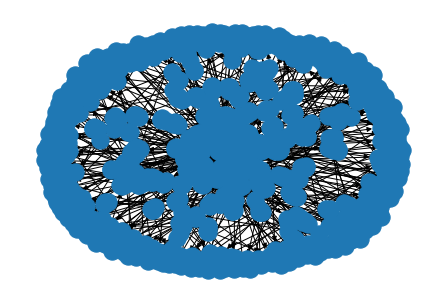

In [36]:
######## Only For Validation #########
val_FollowerNode = list()
val_FollowingNode = list()
val_follow_count_mapper = dict()
for index, DataRow in validation_DF.iterrows():
    if 'Followers' in DataRow:
        if DataRow['id'] in userIdDict:
            val_follow_count_mapper[DataRow['id']] = len(userIdDict[DataRow['id']]['Followers'])
        else:
            val_follow_count_mapper[DataRow['id']] = len(DataRow['Followers'])
#         for val_followerKey, val_follower in enumerate(literal_eval(DataRow['Followers'])):
        for val_followerKey, val_follower in enumerate(DataRow['Followers']):
            if val_follower in nodeId_Set:
                val_FollowerNode.append((int(DataRow['id']), int(val_follower), 1))
    if 'Following' in DataRow:
        if DataRow['id'] in userIdDict:
            val_follow_count_mapper[DataRow['id']] = val_follow_count_mapper[DataRow['id']] + len(userIdDict[DataRow['id']]['Following'])
        else:
            val_follow_count_mapper[DataRow['id']] =  val_follow_count_mapper[DataRow['id']] + len(DataRow['Following'])
#         for val_followingKey, val_following in enumerate(literal_eval(DataRow['Following'])):
        for val_followingKey, val_following in enumerate(DataRow['Following']):
            if val_following in nodeId_Set:
                val_FollowingNode.append((int(val_following), int(DataRow['id']), 1))
            
val_FollowerDF = pd.DataFrame(val_FollowerNode, columns =['Src', 'Des', 'Score'])
val_FollowingDF= pd.DataFrame(val_FollowingNode, columns = ['Src', 'Des', 'Score'])
val_FollowDF = pd.concat([val_FollowerDF,val_FollowingDF])
val_FollowDF.to_csv("val_FollowDF.csv", sep=',', index=False, header=False)
val_nx_graph=nx.read_edgelist('val_FollowDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
print(nx.info(val_nx_graph))
nx.draw(val_nx_graph)
plt.show()

### Only For Validation ####

In [37]:
userIdDict = valid_userIdDict

In [38]:
# print(len(userIdDict.keys()), len(nodeId_Set), userIdDict.keys())
# print(val_follow_count_mapper)
len(list(userIdDict.values()))

937

### First Baseline method execution starts from here

In [39]:
# MPopular_baseLine = [{k: v} for k, v in sorted(val_follow_count_mapper.items(), key=lambda item: item[1])][-50:]

### First Baseline method execution ends here

### The following code block assigns score to a twitter account based on the IBM watson tagging and helps removing twitter account from the analysis if the account is not relevant ###

In [40]:
def categoryAnalyzer(tweetID, Type):
    userScoreDict=dict()
    score=0
    keepOrDiscard=True
    if tweetID not in userIdDict:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "TweetsTags" not in userIdDict[tweetID] and "DescTag" not in userIdDict[tweetID]:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "TweetsTags" in userIdDict[tweetID] and Type==True:
        countTech=0
        countSci=0
        for per_TextID, categoryList in enumerate(userIdDict[tweetID]["TweetsTags"]):
            for tagID, category in enumerate(categoryList):
                if "antivirus and malware" in category:
                    score=score+1
                    break
                if "technology and computing" in category:
                    if (countTech%5)==0:
                        score=score+0.5
                    countTech=countTech+1
                    break
                if "computer science" in category:
                    if (countSci%5)==0:
                        score=score+0.1
                    countSci=countSci+1
        if countTech<=2:
            userScoreDict[tweetID] = 0
            keepOrDiscard = False
    if "DescTag" in userIdDict[tweetID] and Type==True:
        for tagID, category in enumerate(userIdDict[tweetID]["DescTag"]):
            if "technology and computing" in category:
                score=score+2
                break
            if "computer science" in category:
                score=score+0.5
    if keepOrDiscard==True:
        userScoreDict[tweetID] = score
#     else:
#         print("Assign 0")
    return keepOrDiscard, userScoreDict

In [41]:
# categoryAnalyzer(1006326206579511296, True)
# userIdDict[222405719]

### Only need for main data execution

In [42]:
# followerNode=list()
# followingNode=list()
# for key, item in userIdDict.items():
#     if 'Followers' in item:
#         for follrKey, followerVal in enumerate(item['Followers']):
#             followerNode.append((int(key), int(followerVal), 1.00))
#     if 'Following' in item:
#         for follngKey, followingVal in enumerate(item['Following']):
#             followingNode.append((int(followingVal), int(key), 1.00))

### Only need for main data execution

In [43]:
# followerDF = pd.DataFrame(followerNode, columns =['Src', 'Des', 'Score'])
# followingDF= pd.DataFrame(followingNode, columns = ['Src', 'Des', 'Score'])
# followRelnDF = pd.concat([followerDF,followingDF])
# followerDF.to_csv("followerDF.csv", sep=',', index=False, header=False)
# followingDF.to_csv("followingDF.csv", sep=',', index=False, header=False)
# followRelnDF.to_csv("followRelnDF.csv", sep=',', index=False, header=False)

### Only need for main data execution

In [44]:
# def graph_reader():
#     """
#     Function to read the graph from the path.
#     :param path: Path to the edge list.
#     :return graph: NetworkX object returned.
#     """
#     graph=nx.read_edgelist('followRelnDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
#     graph1=nx.read_edgelist('followerDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
#     graph2=nx.read_edgelist('followingDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
#     return graph, graph1, graph2

### Only need for main data execution

In [45]:
# nx_graph, graph1, graph2 = graph_reader()
# nx_graph.edges()

In [46]:
# nx_graph.nodes()
# print(nx.info(nx_graph))
# nx.draw(nx_graph)
# plt.show()

### Only For Validation ###

In [47]:
nx_graph = val_nx_graph

## Community Detection using Girvan-Newman Algorithm 

In [48]:
# communities_generator = community.girvan_newman(nx_graph)
# top_level_communities = next(communities_generator)
# next_level_communities = next(communities_generator)
# sorted(map(sorted, next_level_communities))

In [49]:
# testList = sorted(map(sorted, next_level_communities))
# len(testList)

In [50]:
# girvan_PartitionDict=dict()
# for idx, subGrList in enumerate(testList):
#     for ind, node in enumerate(subGrList):
#         girvan_PartitionDict.update({node:idx})
        
        
        
        
        
        
# pos = nx.spring_layout(nx_graph)
# cmap = cm.get_cmap('viridis', max(girvan_PartitionDict.values()) + 1)
# nx.draw_networkx_nodes(nx_graph, pos, girvan_PartitionDict.keys(), node_size=40, cmap=cmap, node_color=list(girvan_PartitionDict.values()))
# nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
# plt.show()

## Community Detection on Leiden Algorithm (Networkx+igraph)

In [51]:
nxNode_to_Index_Mapping = {node:ind for ind, node in enumerate(list(nx_graph.nodes()))}
index_to_nxNode_Mapping = {ind:node for ind, node in enumerate(list(nx_graph.nodes()))}
nxNodeList = list(index_to_nxNode_Mapping.keys())
mapped_Edgelist = [(nxNode_to_Index_Mapping[nodeTouple[0]], nxNode_to_Index_Mapping[nodeTouple[1]]) for nodeTouple in nx_graph.edges()]
ig_graph = ig.Graph(len(nx_graph), mapped_Edgelist)
# ig_graph = ig.Graph.Adjacency((nx.to_scipy_sparse_matrix(nx_graph) > 0).tolist())
louvain_partition = louvain.find_partition(ig_graph, louvain.ModularityVertexPartition)
leiden_partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)

In [52]:
edgeList=ig_graph.get_edgelist()
nx_conv_graph = nx.DiGraph(edgeList)

In [53]:
leiden_partitionDict= dict()
for ind, nodeList in enumerate(list(leiden_partition)):
    for node in nodeList:
        leiden_partitionDict.update({node:ind})

In [54]:
def community_user_membership_function(text_rslt, desc_rslt):
    communityScoreDict=dict()
    allUserScoreDict = dict()
    communityTextDict=dict()
    igraph_nx_mapper = dict()
    valid_UserNodes_in_Community = dict()
    userNode_Community_map = dict()
    for commID, community in enumerate(leiden_partition):
#         nxNodeList = list(nx_graph.nodes())
        communityTotalScore=0
        communityText = ""
        CTI_userList=list()
        for index, memberNode in enumerate(community):
            igraph_nx_mapper.update({memberNode:index_to_nxNode_Mapping[nxNodeList[memberNode]]})
            
#             status, id_with_Score = categoryAnalyzer(index_to_nxNode_Mapping[nxNodeList[memberNode]], True)
            status, id_with_Score = user_categoryAnalyzer(index_to_nxNode_Mapping[nxNodeList[memberNode]], True, text_rslt, desc_rslt)
#             status, id_with_Score = categoryAnalyzer(nxNodeList[memberNode], True)
            
            communityTotalScore = communityTotalScore + list(id_with_Score.values())[0]
            allUserScoreDict.update(id_with_Score)
            if status == True:
                if userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'] and userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'] != None:
                    Tweets=' '.join(userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'])
                    communityText = communityText + " " + Tweets
                    CTI_userList.append(index_to_nxNode_Mapping[nxNodeList[memberNode]])
                    userNode_Community_map.update({index_to_nxNode_Mapping[nxNodeList[memberNode]]:commID})
        communityScoreDict[commID] = communityTotalScore/(len(community))
        valid_UserNodes_in_Community[commID] = CTI_userList
    #     print("communityScoreDict-> ", communityScoreDict[commID], communityText)
        if communityText or communityText != "":
            communityTextDict.update({commID:communityText})
    return communityScoreDict, allUserScoreDict, communityTextDict, igraph_nx_mapper, valid_UserNodes_in_Community, userNode_Community_map

In [55]:
def seedInput(seedList):
    seedNode_CleanedTextList =  list()
    for idx, nodeID in enumerate(seedList):
        if nodeID in userIdDict.keys():
            userObject = userIdDict[seedList[idx]]
            if 'AllText' in userObject and userObject['AllText'] != None and len(userObject['AllText'])>= 0:
                seedNode_CleanedTextList.append(userObject['AllText'])
    return seedNode_CleanedTextList

In [56]:
#seed node input
def text_tfIdf_Vectorization(commOrUser_TextDict_or_TextList, seed_TextList):
    if isinstance(commOrUser_TextDict_or_TextList, dict):
        sparse_tfIdfVector = apply_TFIDF(list(commOrUser_TextDict_or_TextList.values()) + seed_TextList)
    if isinstance(commOrUser_TextDict_or_TextList, list):
        sparse_tfIdfVector = apply_TFIDF(commOrUser_TextDict_or_TextList + seed_TextList)
    return sparse_tfIdfVector

In [57]:
def similarty_Calculation_and_MaxSimilar_Community_or_Node_retrieval(seed_sparse_tfIdfVector, index_to_entity_Mapper, seedList, val):
    if val == True:
        selection = 50
    else:
        selection = 4
    seed_sparse_tfIdfVector = seed_sparse_tfIdfVector.toarray()
    similarityMatrix = cosine_similarity(seed_sparse_tfIdfVector[-len(seedList):],seed_sparse_tfIdfVector[0:(seed_sparse_tfIdfVector.shape[0]-len(seedList))])
    MaxSimilartyList = [list(similarityMatrix[i].argsort()[-selection:][::-1]) for i in range(similarityMatrix.shape[0])]
    entitySimScore = np.array([np.take(similarityMatrix[i], indices, axis=0) for i, indices in enumerate(MaxSimilartyList)])
#     print("MaxSimilartyList-> ", MaxSimilartyList)
    entityID = set([index_to_entity_Mapper[y] for x in MaxSimilartyList for y in x])
    return similarityMatrix, MaxSimilartyList, entityID, entitySimScore

##### Second baseline Code Starts here

In [58]:
def friend_of_friend_generator(feed_List_Set):
    feed_List_Set = list(feed_List_Set)
    FoF_baseline = list()
#     print(feed_List_Set)
    for feedNode in feed_List_Set:
        if feedNode in userIdDict:
            if 'Followers' in userIdDict[feedNode]:
                FoF_baseline.extend(set(userIdDict[feedNode]['Followers']))
    return FoF_baseline

In [59]:
def fof_driver(FoF_baseline):
    # rangeValue = int(input("Number of Iteration"))
    rangeValue = 2
    for i in range(rangeValue):
        FoF_baseline = friend_of_friend_generator(FoF_baseline)
        FoF_baseline = {fol_1 for fol_1 in FoF_baseline if fol_1 in set(validation_DF['id'])}
#     print(len(FoF_baseline))
    return FoF_baseline

##### Second baseline Code Ends

#### Third baseline Code Starts here

In [60]:
def third_baseline_function(seedNode_CleanedTextList, FoF_baseline):    
    id_AllText_mapper = {tID: tVal['AllText'] for tID, tVal in userIdDict.items() if 'AllText' in tVal}
    thirdBase_userID_to_Index_Mapper = {node: i for i, node in enumerate(list(id_AllText_mapper.keys()))}
    index_to_thirdBase_userID_Mapper = {i: node for i, node in enumerate(list(thirdBase_userID_to_Index_Mapper.keys()))}
    CplusL_tfIdfVector = text_tfIdf_Vectorization(id_AllText_mapper, seedNode_CleanedTextList)
    val_similarityMatrix, val_MaxSimilartyList, val_userID, val_userSimScore = similarty_Calculation_and_MaxSimilar_Community_or_Node_retrieval(CplusL_tfIdfVector, index_to_thirdBase_userID_Mapper, FoF_baseline, True)
    CplusL_baseline = set(FoF_baseline).intersection(set(val_userID))
    return CplusL_baseline

#### Third baseline Code Ends here

In [61]:
def community_total_score_calculation(communityTextDict, seedNode_CleanedTextList, communityScoreDict, index_to_Community_Mapper, seedList, alpha):    
    community_seed_sparse_tfIdfVector = text_tfIdf_Vectorization(communityTextDict, seedNode_CleanedTextList)
    similarityMatrix, MaxSimilartyList, communityID, communitySimScore = similarty_Calculation_and_MaxSimilar_Community_or_Node_retrieval(community_seed_sparse_tfIdfVector, index_to_Community_Mapper, seedList, False)
    # method = str(input("Seperate or All"))
    method = "Sep"
    if method =="Sep":
#         print(MaxSimilartyList,communitySimScore)
        communityWeight = np.array([np.array([communityScoreDict[index_to_Community_Mapper[y]] for y in x]) for x in MaxSimilartyList])
        value = np.add(communitySimScore*alpha, communityWeight)
    #     print(value, communityWeight)
    if method == "All":
        #     MaxSimilartyArray = set(itertools.chain.from_iterable(MaxSimilartyList))
        communitySimScoreFlat = communitySimScore.flatten('C')
        print(MaxSimilartyList,communitySimScore, communitySimScoreFlat)
        communityWeightFlat = np.array([communityScoreDict[index_to_Community_Mapper[y]] for x in MaxSimilartyList for y in x])
        value = np.add(communitySimScoreFlat, communityWeightFlat)
    #     print(value, communityWeight)
    
    return communityID

In [62]:
def user_Search_in_Community(valid_UserNodes, seed_TextList, communityID, allUserScoreDict, seedList, alpha):
    user_Score_in_CommunityDict = dict()
    for commKey in communityID:
        usrID_score_dict = dict()
        if commKey in valid_UserNodes:
            community_Member_TextList = [userIdDict[userID]['AllText'] for userID in valid_UserNodes[commKey]]
            userNode_seed_sparse_tfIdfVector = text_tfIdf_Vectorization(community_Member_TextList, seed_TextList)
            userNode_seed_sparse_tfIdfVector = userNode_seed_sparse_tfIdfVector.toarray()
#             print("userNode_seed_sparse_tfIdfVector-> ", userNode_seed_sparse_tfIdfVector.shape)
            user_Seed_SimilarityMatrix = cosine_similarity(userNode_seed_sparse_tfIdfVector[-len(seedList):],userNode_seed_sparse_tfIdfVector[0:(userNode_seed_sparse_tfIdfVector.shape[0]-len(seedList))])
#             print("#########", user_Seed_SimilarityMatrix)
            if user_Seed_SimilarityMatrix.shape[1] <= 1:
                user_Seed_MaxSimilartyArr = np.array([np.zeros(len(user_Seed_SimilarityMatrix.flatten()))])
                userNode_SimScore = np.array(user_Seed_SimilarityMatrix).flatten()
            else:
                user_Seed_MaxSimilartyArr = np.array([user_Seed_SimilarityMatrix[i].argsort()[-4:][::-1] for i in range(user_Seed_SimilarityMatrix.shape[0])])
                ### Problem
                userNode_SimScore = np.array([np.take(user_Seed_SimilarityMatrix[i], list(user_Seed_MaxSimilartyArr[i,:]), axis=0) for i in range(user_Seed_MaxSimilartyArr.shape[0])])
            user_Seed_MaxSimilartyArrFlat = user_Seed_MaxSimilartyArr.flatten('C')
            userNode_SimScoreFlat = userNode_SimScore.flatten('C')
            print("commKey-> ", commKey, " user_Seed_MaxSimilartyArrFlat-> ", len(user_Seed_MaxSimilartyArrFlat), user_Seed_MaxSimilartyArrFlat)
            userNodeID = [valid_UserNodes[commKey][int(x)] for x in np.nditer(user_Seed_MaxSimilartyArrFlat)]
            userNode_Weight = np.array([allUserScoreDict[y] for y in userNodeID])
            userNode_Score_Array = np.add(userNode_SimScoreFlat*alpha, userNode_Weight)
#             print("user_Seed_MaxSimilartyArr-> ", user_Seed_MaxSimilartyArr," userNode_SimScoreFlat-> ",userNode_SimScoreFlat," userNode_Weight-> ", userNode_Weight)
            for idx, nodeID in enumerate(userNodeID):
                if nodeID in usrID_score_dict:
                    if usrID_score_dict[nodeID]> userNode_Score_Array[idx]:
                        continue
                    else:
                        usrID_score_dict[nodeID] = userNode_Score_Array[idx]
                else:
                    usrID_score_dict[nodeID] = userNode_Score_Array[idx]
            user_Score_in_CommunityDict[commKey] = usrID_score_dict
    return user_Score_in_CommunityDict

In [63]:
def sort_recommended_userNodes(recommended_UserIDwith_Score):
    userID_Score_tempList=list()
    for community_ID_Score_val_dict in recommended_UserIDwith_Score.values():
        for key, val in community_ID_Score_val_dict.items():
            userID_Score_tempList.append({key:val})
    recommended_UserIDwith_Score = sorted(userID_Score_tempList, key = lambda i: list(i.values()), reverse=True)[:40]
    print(len(recommended_UserIDwith_Score),recommended_UserIDwith_Score)
    return recommended_UserIDwith_Score

In [64]:
# The following two lines Can be added
def add_adaptive_weight_for_highRank_node_community(recommended_UserIDwith_Score, userNode_Community_map, valid_UserNodes_in_Community):
    highRank_Comm_User_map_list = [{(userNode_Community_map[list(id_value_map.keys())[0]]):(list(id_value_map.keys())[0])} for id_value_map in recommended_UserIDwith_Score]
    community_flag = set()
    for commID_usr_map in highRank_Comm_User_map_list:
        if list(commID_usr_map.keys())[0] in community_flag:
            continue
        else:
            community_flag.add(list(commID_usr_map.keys())[0])

            for usrID in valid_UserNodes_in_Community[list(commID_usr_map.keys())[0]]:
                if usrID == list(commID_usr_map.values())[0]:
                    continue
                if usrID in recommended_UserIDwith_Score and usrID != list(commID_usr_map.values())[0]:
                    recommended_UserIDwith_Score[usrID] = recommended_UserIDwith_Score[usrID] + recommended_UserIDwith_Score[list(commID_usr_map.values())[0]]*0.3
    return recommended_UserIDwith_Score

# Model Validation Part #

In [65]:
def model_performance_exhibition(recommended_UserIDwith_Score, withScore):
    resultList = list()
    if withScore:
        userID = [list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score]
    if not withScore:
        userID = recommended_UserIDwith_Score
    for valID in userID:
        resultList.append(validation_DF.iloc[validation_DF[validation_DF['id'] == valID].index.tolist()[0]]['Annotation'])
#         print(validation_DF.iloc[validation_DF[validation_DF['id'] == valID].index.tolist()[0]]['Annotation'])
    return resultList

In [66]:
def adaptive_precision(resultList):
    countDict = Counter(resultList) 
    precision = countDict['relevant']/len(resultList)
    return precision

In [67]:
def adaptive_recall(resultList):
    countDict = Counter(resultList) 
    recall = countDict['relevant']/recall_base
    return recall

In [68]:
def adaptive_F1score(precision, recall):
    beta = 0.5
    f1_Score = ((1 + beta*beta)*(precision*recall))/(((beta*beta)*precision) + recall)
    return f1_Score

In [69]:
# def model_comparison_result(recommended_UserIDwith_Score, MPopular_baseLine, FoF_baseline, CplusL_baseline):
def model_comparison_result(recommended_UserIDwith_Score, FoF_baseline, CplusL_baseline):
    ### Proposed Model
    prposed_resultList = model_performance_exhibition(recommended_UserIDwith_Score, True) ## Proposed model
    proposed_precision = adaptive_precision(prposed_resultList)
    proposed_recall = adaptive_recall(prposed_resultList)
    proposed_f1_Score = adaptive_F1score(proposed_precision, proposed_recall)
    print("Proposed-> ", "f1_Score-> ", adaptive_F1score(proposed_precision, proposed_recall), "precision-> ", proposed_precision, "recall-> ", proposed_recall)
    
    ### First Baseline
#     first_baseline_resultList = model_performance_exhibition(MPopular_baseLine, True)
#     first_baseline_precision = adaptive_precision(first_baseline_resultList)
#     first_baseline_recall = adaptive_recall(first_baseline_resultList)
#     first_baseline_f1_Score = adaptive_F1score(first_baseline_precision, first_baseline_recall)
#     print("first_baseline-> ", "f1_Score-> ", adaptive_F1score(first_baseline_precision, first_baseline_recall), "precision-> ", first_baseline_precision, "recall-> ", first_baseline_recall)
    
    ### Second Baseline
    second_baseline_resultList = model_performance_exhibition(list(FoF_baseline), False)
    second_baseline_precision = adaptive_precision(second_baseline_resultList)
    second_baseline_recall = adaptive_recall(second_baseline_resultList)
    second_baseline_f1_Score = adaptive_F1score(second_baseline_precision, second_baseline_recall)
    print("second_baseline-> ", "f1_Score-> ", adaptive_F1score(second_baseline_precision, second_baseline_recall), "precision-> ", second_baseline_precision, "recall-> ", second_baseline_recall)
    
    ### Third Baseline
    third_baseline_resultList = model_performance_exhibition(list(CplusL_baseline), False)
    third_baseline_precision = adaptive_precision(third_baseline_resultList)
    third_baseline_recall = adaptive_recall(third_baseline_resultList)
    third_baseline_f1_Score = adaptive_F1score(third_baseline_precision, third_baseline_recall)
    print("third_baseline-> ", "f1_Score-> ", adaptive_F1score(third_baseline_precision, third_baseline_recall), "precision-> ", third_baseline_precision, "recall-> ", third_baseline_recall)
    
    return proposed_precision, proposed_recall, proposed_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score
#     return proposed_precision, proposed_recall, proposed_f1_Score, first_baseline_precision, first_baseline_recall, first_baseline_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score

In [70]:
def driver_function(seedList, alpha, text_rslt, desc_rslt):
    communityScoreDict, allUserScoreDict, communityTextDict, igraph_nx_mapper, valid_UserNodes_in_Community, userNode_Community_map = community_user_membership_function(text_rslt, desc_rslt)
    community_to_Index_Mapper = {node: i for i, node in enumerate(list(communityTextDict.keys()))}
    index_to_Community_Mapper = {i: node for i, node in enumerate(list(community_to_Index_Mapper.keys()))}
    seedNode_CleanedTextList = seedInput(seedList)
    communityID = community_total_score_calculation(communityTextDict, seedNode_CleanedTextList, communityScoreDict, index_to_Community_Mapper, seedList, alpha)
    recommended_UserIDwith_Score = user_Search_in_Community(valid_UserNodes_in_Community, seedNode_CleanedTextList, communityID, allUserScoreDict, seedList, alpha)
    recommended_UserIDwith_Score = sort_recommended_userNodes(recommended_UserIDwith_Score)
    recommended_UserIDwith_Score = add_adaptive_weight_for_highRank_node_community(recommended_UserIDwith_Score, userNode_Community_map, valid_UserNodes_in_Community)
    return recommended_UserIDwith_Score

In [71]:
list_of_seedList = [[835035547, 1102643178,1927923236], [98210594, 14945996, 14666934], [609536134, 37771774, 42920448]]
# seedList = [97721735,398400323, 459375780] # Never
# seedList = [2730681163, 558033985, 272760181, 2283961765]
selection_Threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
alpha = 1.5
avg_prop_preList = list()
avg_prop_recList = list()
avg_prop_f1List = list()

avg_secondB_preList = list()
avg_secondB_recList = list()
avg_secondB_f1List = list()

avg_thirdB_preList = list()
avg_thirdB_recList = list()
avg_thirdB_f1List = list()

for seedList in list_of_seedList:
    FoF_baseline = seedList.copy()
    recommended_UserIDwith_Score = driver_function(seedList.copy(), alpha, text_rslt, desc_rslt)
    FoF_baseline = fof_driver(FoF_baseline)
    seedNode_CleanedTextList = seedInput(seedList.copy())
    CplusL_baseline = third_baseline_function(seedNode_CleanedTextList, FoF_baseline)
    temp_proposed = recommended_UserIDwith_Score.copy()
    temp_2nd_baseline = FoF_baseline.copy()
    temp_3rd_baseline = CplusL_baseline.copy()
    prop_preList = list()
    prop_recList = list()
    prop_f1List = list()
#     firstB_preList = list()
#     firstB_recList = list()
#     firstB_f1List = list()
    secondB_preList = list()
    secondB_recList = list()
    secondB_f1List = list()
    thirdB_preList =  list()
    thirdB_recList = list()
    thirdB_f1List = list()
    for threshold in selection_Threshold:
        recommended_UserIDwith_Score = temp_proposed
        FoF_baseline = temp_2nd_baseline
        CplusL_baseline = temp_3rd_baseline
        for i in range(3):
            recommended_UserIDwith_Score = [list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score]
            recommended_UserIDwith_Score = recommended_UserIDwith_Score[0:math.ceil(len(recommended_UserIDwith_Score)*threshold)]
            recommended_UserIDwith_Score = driver_function(recommended_UserIDwith_Score, alpha, text_rslt, desc_rslt)
            
            FoF_baseline = list(FoF_baseline)[0:math.ceil(len(FoF_baseline)*threshold)]
            FoF_baseline = fof_driver(FoF_baseline)
            
            
            CplusL_baseline = list(CplusL_baseline)[0:math.ceil(len(CplusL_baseline)*threshold)]
            feedNode_TextList = seedInput(CplusL_baseline)
            CplusL_baseline = third_baseline_function(feedNode_TextList, FoF_baseline)
            
        proposed_precision, proposed_recall, proposed_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score = model_comparison_result(recommended_UserIDwith_Score, FoF_baseline, CplusL_baseline)
#         proposed_precision, proposed_recall, proposed_f1_Score, first_baseline_precision, first_baseline_recall, first_baseline_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score = model_comparison_result(recommended_UserIDwith_Score, MPopular_baseLine, FoF_baseline, CplusL_baseline)
        prop_preList.append(proposed_precision)
        prop_recList.append(proposed_recall)
        prop_f1List.append(proposed_f1_Score)
#         firstB_preList.append(first_baseline_precision)
#         firstB_recList.append(first_baseline_recall)
#         firstB_f1List.append(first_baseline_f1_Score)
        secondB_preList.append(second_baseline_precision)
        secondB_recList.append(second_baseline_recall)
        secondB_f1List.append(second_baseline_f1_Score)
        thirdB_preList.append(third_baseline_precision)
        thirdB_recList.append(third_baseline_recall)
        thirdB_f1List.append(third_baseline_f1_Score)
    
    avg_prop_preList.append(prop_preList)
    avg_prop_recList.append(prop_recList)
    avg_prop_f1List.append(prop_f1List)
    avg_secondB_preList.append(secondB_preList)
    avg_secondB_recList.append(secondB_recList)
    avg_secondB_f1List.append(secondB_f1List)
    avg_thirdB_preList.append(thirdB_preList)
    avg_thirdB_recList.append(thirdB_recList)
    avg_thirdB_f1List.append(thirdB_f1List)

tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.6894812570522554
tweetID-

tweetID-> 966198539733929984 score-> 0  desc_temp_score->  0.19599403203754445
tweetID-> 98210594 score-> 16.71946282916072  desc_temp_score->  -0.014909648771993522
tweetID-> 544483119 score-> 12.723159302194944  desc_temp_score->  0.5681256255999116
tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 740724363872378880 score-> 12.548033585543603  desc_temp_score->  0.37785711405501105
tweetID-> 2973645813 score-> 8.417142368871374  desc_temp_score->  0.11666913454323778
tweetID-> 3358636906 score-> 7.770901486945651  desc_temp_score->  0.1728748811663394
tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 7

 +  (74, 15864)  + 
 +  (7, 1690)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  12 [2 3 0 1 3 2 0 1 0 3 1 2]
 +  (10, 2322)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  12 [3 1 0 2 0 1 3 5 3 4 2 5]
 +  (6, 1439)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 0 2 1 0 2 1]
 +  (5, 985)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  6 [0 1 0 1 1 0]
 +  (5, 1170)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
 +  (6, 1516)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  9 [2 0 1 1 2 0 0 2 1]
 +  (4, 1003)  + 
commKey->  83  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (6, 1409)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  9 [2 1 0 1 2 0 2 1 0]
 +  (4, 784)  + 
commKey->  57  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (4, 1022)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
26 [{11927342: 25.934647989282592}, {689273: 19.423359460691692}, {58631128: 17.5820203130128}, {17874544: 15.466086429128609},

tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score-> 

tweetID-> 719312424 score-> 13.848227171150816  desc_temp_score->  0.3937264765304054
tweetID-> 19583186 score-> 0.7790673946272737  desc_temp_score->  0.0085215988612138
tweetID-> 70283639 score-> 8.697109122979445  desc_temp_score->  0.04384075377560094
 +  (74, 15788)  + 
 +  (6, 1291)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  9 [2 1 0 0 1 2 1 0 2]
 +  (6, 1192)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  9 [2 0 1 0 2 1 0 1 2]
 +  (5, 1011)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  6 [0 1 1 0 1 0]
 +  (5, 1128)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (5, 1134)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 0 1]
 +  (4, 982)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (5, 1175)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 0 1]
 +  (5, 1153)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  6 [0 1 1 0 0 1]
 +  (6, 1183)  + 
commKey->  24  user_Seed_MaxSimilartyArrF

tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score->  0.30966613641292484
tweetID-> 764654979831308288 score-> 13.950138674805384  desc_temp_score->  0.23006987989971933
tweetID-> 1014278890775285760 score-> 1.9248669822835698  desc_temp_score->  0.12187237830190531
tweetID-> 1170841422129504256 score-> 1.031408771078945  desc_temp_score->  0.10333727914413934
tweetID-> 2328527097 score-> 2.294964562243429  desc_temp_score->  0.20874458445372435
tweetID-> 1181039699344777216

 +  (74, 15801)  + 
 +  (6, 995)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  9 [2 1 0 0 2 1 2 1 0]
 +  (8, 1714)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  12 [4 0 1 2 4 1 3 0 0 1 3 4]
 +  (6, 1115)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  9 [2 0 1 1 0 2 2 0 1]
 +  (5, 1065)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
 +  (5, 926)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 1 0]
 +  (5, 1103)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 0 1]
 +  (5, 952)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  6 [0 1 1 0 0 1]
 +  (8, 1650)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  12 [3 0 2 4 0 2 3 4 0 4 3 2]
 +  (5, 1057)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
25 [{810854024769576960: 28.504477828666616}, {11927342: 27.370890249931414}, {952245050163032064: 23.43870386949077}, {29292439: 18.88659746086081}, {2480951: 18.254689428575116}, {519989509: 18.10776778129

tweetID-> 2156278138 score-> 1.8594166935385963  desc_temp_score->  -0.02187744968511965
tweetID-> 1093466015168528385 score-> 2.251252621259308  desc_temp_score->  0
tweetID-> 966198539733929984 score-> 0  desc_temp_score->  0.19599403203754445
tweetID-> 98210594 score-> 16.71946282916072  desc_temp_score->  -0.014909648771993522
tweetID-> 544483119 score-> 12.723159302194944  desc_temp_score->  0.5681256255999116
tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 740724363872378880 score-> 12.548033585543603  desc_temp_score->  0.37785711405501105
tweetID-> 2973645813 score-> 8.417142368871374  desc_temp_score->  0.11666913454323778
tweetID-> 3358636906 score-> 7.770901486945651  desc_temp_score->  0.1728748811663394
tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-

 +  (74, 15801)  + 
 +  (6, 995)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  9 [0 2 1 2 1 0 2 1 0]
 +  (8, 1714)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  12 [4 1 3 0 4 0 1 2 0 1 3 4]
 +  (6, 1115)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 2 0 1 2 0 1]
 +  (5, 1065)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
 +  (5, 926)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  6 [0 1 1 0 1 0]
 +  (5, 1103)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  6 [0 1 1 0 0 1]
 +  (5, 952)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 0 1]
 +  (8, 1650)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  12 [0 2 3 4 3 0 2 4 0 4 3 2]
 +  (5, 1057)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
25 [{810854024769576960: 28.504477828666616}, {11927342: 27.370890249931414}, {952245050163032064: 23.43870386949077}, {29292439: 18.88659746086081}, {2480951: 18.254689428575116}, {519989509: 18.10776778129

tweetID-> 45384584 score-> 21.21712239851876  desc_temp_score->  0.07445795327810403
tweetID-> 1247453118 score-> 7.354474576672559  desc_temp_score->  0.18933893776331584
tweetID-> 15155074 score-> 3.6679267859580422  desc_temp_score->  0.022511823113233048
tweetID-> 1255450909540220930 score-> 11.467867841393174  desc_temp_score->  0.39123086100721205
tweetID-> 928661399471091712 score-> 7.635267631697344  desc_temp_score->  0.00481809528088073
tweetID-> 2964028672 score-> 0  desc_temp_score->  0.23441315479496055
tweetID-> 182493733 score-> 1.31956495107562  desc_temp_score->  -0.055846064397413575
tweetID-> 24949956 score-> 7.909509090502661  desc_temp_score->  0.159460908038419
tweetID-> 1057557859674800128 score-> 9.925989330050474  desc_temp_score->  0.041499439071231894
tweetID-> 982279248881901568 score-> 3.7882220542937577  desc_temp_score->  0.20455620960055404
tweetID-> 928185503488323584 score-> 16.091653868913735  desc_temp_score->  0.27273838055510313
tweetID-> 109141659

 +  (77, 15821)  + 
 +  (11, 2488)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  24 [4 3 0 1 2 0 4 1 4 2 0 1 1 4 0 3 4 2 1 0 4 1 0 2]
 +  (9, 1847)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  18 [2 0 1 0 1 2 0 1 2 2 1 0 2 0 1 2 1 0]
 +  (7, 1649)  + 
commKey->  69  user_Seed_MaxSimilartyArrFlat->  6 [0. 0. 0. 0. 0. 0.]
 +  (9, 1759)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  18 [2 0 1 2 0 1 0 1 2 0 2 1 2 0 1 0 2 1]
 +  (8, 1601)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  12 [0 1 1 0 1 0 1 0 1 0 0 1]
 +  (8, 1710)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  12 [1 0 1 0 1 0 1 0 0 1 0 1]
 +  (8, 1707)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  12 [1 0 0 1 0 1 1 0 1 0 1 0]
 +  (9, 1800)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  18 [2 0 1 1 2 0 2 0 1 0 2 1 2 1 0 0 2 1]
 +  (7, 1577)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  6 [0. 0. 0. 0. 0. 0.]
 +  (8, 1870)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  12 [0 1 0 

tweetID-> 544763436 score-> 5.091975689008348  desc_temp_score->  0.19751179569071325
tweetID-> 3066551830 score-> 0.5761101408202439  desc_temp_score->  0.09745147057527968
tweetID-> 950499905415589888 score-> 2.0509714131879067  desc_temp_score->  -0.021047624298140347
tweetID-> 984153741413797893 score-> 1.425494588996668  desc_temp_score->  0.2147140057825718
tweetID-> 14220471 score-> 3.7391749150628617  desc_temp_score->  0.20961378236018413
tweetID-> 876063393530208256 score-> 9.853195294171487  desc_temp_score->  0.36917383324333103
tweetID-> 37771774 score-> 11.173254931885106  desc_temp_score->  0.08410774344647062
tweetID-> 68361126 score-> 5.832809833677069  desc_temp_score->  0.1908074185958214
tweetID-> 191753530 score-> 10.32990649691987  desc_temp_score->  0.4619551321065012
tweetID-> 55460634 score-> 3.7768754760582817  desc_temp_score->  0.13734318932170597
tweetID-> 361391764 score-> 2.153555262404529  desc_temp_score->  -0.10945829382513181
tweetID-> 1713618798 scor

tweetID-> 14119804 score-> 10.542567395248891  desc_temp_score->  0.29337165695005807
tweetID-> 42585410 score-> 4.921364067578768  desc_temp_score->  0.16303443310908386
tweetID-> 588402819 score-> 4.8080740608884485  desc_temp_score->  0.3753996974112327
tweetID-> 14209841 score-> 4.83954253769488  desc_temp_score->  0.22368298180883345
tweetID-> 835035547 score-> 11.035317359306855  desc_temp_score->  0.422632008610575
tweetID-> 893452694421217280 score-> 3.5008140935710244  desc_temp_score->  0.11417872393062366
tweetID-> 701481767 score-> 0  desc_temp_score->  0.07622942581024054
tweetID-> 50860169 score-> 8.486600950667217  desc_temp_score->  0.44306826757799556
tweetID-> 58631128 score-> 17.09434206120639  desc_temp_score->  0.27578333547659445
tweetID-> 86424236 score-> 6.406437003626679  desc_temp_score->  -0.013161960780201654
tweetID-> 29031844 score-> 6.345646492565176  desc_temp_score->  0.1694290910762377
tweetID-> 817089544570933248 score-> 5.316990147735122  desc_temp_s

 +  (941, 61163)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.6894

tweetID-> 1678601444 score-> 0  desc_temp_score->  0.21505921979538725
tweetID-> 1285155284906921984 score-> 5.018635876007349  desc_temp_score->  0.3844720214569929
tweetID-> 263565397 score-> 5.44192626323704  desc_temp_score->  0.09709500035005948
tweetID-> 1300111425994657792 score-> 2.2783389688491096  desc_temp_score->  0.03727800181136967
tweetID-> 1274636448520642561 score-> 3.1229381655356705  desc_temp_score->  -0.00900135577938975
tweetID-> 2667857126 score-> 1.4543960388611141  desc_temp_score->  0.1633264496170918
tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 1

tweetID-> 754006735468261376 score-> 1.708533208446672  desc_temp_score->  0.04127005462670024
tweetID-> 985486861672968192 score-> 3.3109148648037423  desc_temp_score->  0.09054008544368924
tweetID-> 984411982743814144 score-> 0.08888113419275903  desc_temp_score->  0
tweetID-> 977202254 score-> 4.244802702311758  desc_temp_score->  0.37250090700240257
tweetID-> 2425831 score-> 3.0496849499671232  desc_temp_score->  0.12112425636627479
tweetID-> 17986110 score-> 3.967939416744258  desc_temp_score->  0.26339290294707557
tweetID-> 14507690 score-> 2.9127634402944063  desc_temp_score->  0.24733804615153157
tweetID-> 63490987 score-> 12.960286964057625  desc_temp_score->  0.2122223138258625
tweetID-> 3687025035 score-> 2.4428283560298936  desc_temp_score->  0.3625988760432085
tweetID-> 15081182 score-> 3.8827580078174844  desc_temp_score->  0.06400094563957161
tweetID-> 739264134596808704 score-> 2.6964605065376333  desc_temp_score->  -0.06589130231677728
tweetID-> 996722031088451585 scor

 +  (79, 15849)  + 
 +  (11, 2203)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  24 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 2 0 1 0 1 2 1 0 2]
 +  (13, 2647)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  32 [4 1 3 0 0 4 1 2 0 1 3 4 1 4 0 2 4 1 0 2 1 3 2 4 4 0 1 2 1 0 2 4]
 +  (15, 3124)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  32 [1 3 6 0 4 1 2 3 0 5 4 1 1 0 3 2 0 1 5 6 3 4 0 1 0 5 1 6 1 5 0 2]
 +  (10, 1969)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  16 [1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0]
 +  (11, 2356)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  24 [2 1 0 1 2 0 1 0 2 1 2 0 1 0 2 1 0 2 1 2 0 2 1 0]
 +  (13, 2612)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  32 [0 3 2 4 3 0 2 1 0 4 3 2 2 3 4 0 0 3 4 2 4 2 3 0 0 3 1 4 4 3 2 1]
 +  (10, 2047)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  16 [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1]
 +  (11, 2165)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  24 [1 2 0 1 0 2 2 1 0 1 2 0 1 2 0 2 0 1 1 2 0 0 2 1]
 +  (9,

tweetID-> 28482605 score-> 4.024714678142522  desc_temp_score->  0.29644368407731797
tweetID-> 773838475 score-> 3.256048733698384  desc_temp_score->  0.3388121725399502
tweetID-> 1145546584752394241 score-> 0.8804265763049275  desc_temp_score->  0.48609577533966336
tweetID-> 1235115096528936960 score-> 2.573532271932335  desc_temp_score->  0.446962899478777
tweetID-> 22083303 score-> 2.62678062229304  desc_temp_score->  0.2820272064887533
tweetID-> 861889353869557762 score-> 2.8977122298132114  desc_temp_score->  0.29416691828784886
tweetID-> 1026799219716177920 score-> 3.6138287994834943  desc_temp_score->  0.26746491474976664
tweetID-> 1134088559617630208 score-> 3.775592958711509  desc_temp_score->  0.25693397947521573
tweetID-> 1177607088039747584 score-> 12.36900158337364  desc_temp_score->  0.19655843840949638
tweetID-> 22589449 score-> 2.069202657114754  desc_temp_score->  0.49085759026707204
tweetID-> 2707742660 score-> 3.9821052683094047  desc_temp_score->  0
tweetID-> 109971

tweetID-> 308308886 score-> 7.1203586143569755  desc_temp_score->  0.3076637468919793
tweetID-> 15341689 score-> 3.5600303752861917  desc_temp_score->  0.1970954413804183
tweetID-> 545328728 score-> 3.9025280529746036  desc_temp_score->  0.21524245685791732
tweetID-> 815733297028337664 score-> 6.727785848908766  desc_temp_score->  0.17989494094945485
tweetID-> 819186227912052736 score-> 5.514328796689366  desc_temp_score->  0.10717820985334403
tweetID-> 419854605 score-> 4.198227409248816  desc_temp_score->  0.07522508618644302
tweetID-> 1161468238133387264 score-> 0  desc_temp_score->  0.04013385859280602
tweetID-> 1302676578833518592 score-> 0.9346405818692458  desc_temp_score->  0
tweetID-> 34497014 score-> 2.5169197634440033  desc_temp_score->  0.16428113298504657
tweetID-> 140780437 score-> 3.1417963541621705  desc_temp_score->  0.3160841349578895
tweetID-> 27938182 score-> 3.991169677406253  desc_temp_score->  0.2884808630041499
tweetID-> 422298936 score-> 3.870100404313279  desc

 +  (10, 1949)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  16 [1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1]
 +  (11, 2043)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  24 [2 0 1 1 2 0 2 0 1 0 2 1 2 1 0 0 2 1 1 2 0 0 2 1]
 +  (13, 2439)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  32 [3 0 2 1 0 3 2 4 3 2 4 1 4 2 3 0 4 2 3 0 3 4 2 0 2 0 4 3 3 2 0 4]
 +  (10, 1968)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  16 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (11, 1839)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  24 [1 0 2 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 2 0 1 2 0]
 +  (13, 2710)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  32 [4 3 0 1 2 0 4 1 4 2 0 1 1 4 0 3 4 2 1 0 4 1 0 2 1 4 2 0 0 1 4 2]
 +  (11, 2075)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  24 [2 0 1 0 1 2 0 1 2 2 1 0 2 0 1 2 1 0 2 0 1 1 2 0]
 +  (10, 1949)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  16 [1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1]
 +  (9, 1642)  + 
commKey->  57  user_Seed_MaxSimilartyA

tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 1081348391513276416 score-> 7.002760474199567  desc_temp_score->  0.19821873196842738
tweetID-> 605275899 score-> 8.3178202592593  desc_temp_score->  0
tweetID-> 3282774342 score-> 0  desc_temp_score->  0.34324289258573126
tweetID-> 817738176 score-> 3.8985973282669755  desc_temp_score

tweetID-> 744091572 score-> 0.6786482265733336  desc_temp_score->  0
tweetID-> 788041253405331456 score-> 3.0482329551441167  desc_temp_score->  0.6125736980041842
tweetID-> 149353144 score-> 0  desc_temp_score->  0.1943164735631405
tweetID-> 1249380626110861313 score-> 1.7027383290018232  desc_temp_score->  0.017074868370543866
tweetID-> 248972193 score-> 0.935140719686901  desc_temp_score->  0.10589740790989297
tweetID-> 472497777 score-> 4.649310193149935  desc_temp_score->  0.2074028594552193
tweetID-> 3096933139 score-> 7.774928506993575  desc_temp_score->  0.1508559080528203
tweetID-> 3128156529 score-> 0  desc_temp_score->  0.031881305113354276
tweetID-> 1222375896658608128 score-> 13.32568572392978  desc_temp_score->  0.20701749772925754
tweetID-> 18552230 score-> 4.279820333301  desc_temp_score->  0.2659516059507291
tweetID-> 1123693843478712322 score-> 7.469502977602103  desc_temp_score->  0
tweetID-> 301294951 score-> 17.135226047966942  desc_temp_score->  0.2509453250607550

 +  (14, 2735)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  24 [1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (13, 2584)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (14, 2630)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  24 [0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1]
 +  (14, 2609)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  24 [1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0]
 +  (14, 2737)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  24 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
40 [{810854024769576960: 28.504477828666616}, {11927342: 27.370890249931417}, {49423975: 24.926735556635528}, {867433738510249984: 24.425814718171445}, {952245050163032064: 23.438703869490766}, {1297752051519168512: 22.538074369840906}, {1167179635852865536: 21.10813130331684}, {689273: 20.83123992455301}, {1059719143484735488: 20.213699488961453}, {29292439: 20.120003667139407}, {2480951: 19.5443229721991

tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score-> 

 +  (83, 15910)  + 
 +  (14, 2737)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  24 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (15, 2908)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  36 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 2 0 1 0 1 2 0 1 2 0 1 2]
 +  (13, 2437)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (17, 3129)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  48 [4 1 3 0 0 4 1 2 0 1 2 4 0 4 1 2 0 1 3 4 3 4 1 2 1 4 0 2 4 1 0 2 1 3 2 4 4
 0 1 2 0 1 4 2 1 4 3 2]
 +  (19, 3572)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  48 [1 3 6 0 4 1 3 2 1 2 3 0 1 5 3 0 0 5 4 1 2 5 4 3 1 0 3 2 1 0 5 6 3 4 0 1 0
 5 1 3 6 1 3 5 1 3 0 5]
 +  (15, 2707)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  36 [1 0 2 0 1 2 1 0 2 2 1 0 0 1 2 0 1 2 1 2 0 0 1 2 1 0 2 0 2 1 0 1 2 1 0 2]
 +  (14, 2499)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  24 [1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1]
 +  (15, 285

tweetID-> 103602549 score-> 1.7067286852363843  desc_temp_score->  0.06617430882775636
tweetID-> 197907202 score-> 4.074888969662767  desc_temp_score->  0.08689519765069126
tweetID-> 1225500545311543297 score-> 1.9278738056238243  desc_temp_score->  0.07987162278667781
tweetID-> 98491367 score-> 2.729431671309196  desc_temp_score->  -0.021918577754097834
tweetID-> 8357192 score-> 4.139522654985839  desc_temp_score->  0.07100367976307212
tweetID-> 116355320 score-> 2.0640643865600956  desc_temp_score->  0.019857847622721858
tweetID-> 1256068439824756748 score-> 5.5490299210193825  desc_temp_score->  0
tweetID-> 1242306770619355136 score-> 3.1731477237508097  desc_temp_score->  0.25101551120560106
tweetID-> 71629311 score-> 1.4762391982868583  desc_temp_score->  0
tweetID-> 1291450819401986048 score-> 1.5773549744477002  desc_temp_score->  -0.04578369518438158
tweetID-> 4398626122 score-> 11.524185000183937  desc_temp_score->  0.22293962599598383
tweetID-> 1374591954 score-> 7.3372873148

tweetID-> 1225890456212508672 score-> 0  desc_temp_score->  0.22330856422000675
tweetID-> 59090320 score-> 2.306824800709049  desc_temp_score->  -0.09374295888741163
tweetID-> 7773582 score-> 9.759412249505548  desc_temp_score->  0.7228917776714181
tweetID-> 346082659 score-> 2.200991902747404  desc_temp_score->  0.10433488795078395
tweetID-> 8917142 score-> 6.652794334115848  desc_temp_score->  0.4078394268021688
tweetID-> 1010038845633527809 score-> 3.0972683440475093  desc_temp_score->  0.26170906154179874
tweetID-> 915094590633447426 score-> 6.687329297211698  desc_temp_score->  0.1264068617653908
tweetID-> 1133411899339624449 score-> 14.421353549123213  desc_temp_score->  0
tweetID-> 1211163632974749696 score-> 14.578734815476144  desc_temp_score->  0
tweetID-> 340601420 score-> 3.187691374641842  desc_temp_score->  0.05914581736737002
tweetID-> 160814516 score-> 17.30978397230127  desc_temp_score->  0.4446698409094057
tweetID-> 1515893383 score-> 15.689516653073825  desc_temp_sco

 +  (13, 2505)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  22 [1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1]
 +  (14, 2590)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  33 [2 0 1 1 2 0 2 0 1 0 2 1 2 1 0 0 2 1 1 2 0 0 2 1 1 2 0 2 1 0 2 0 1]
 +  (16, 2956)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  44 [3 0 2 1 0 3 4 2 3 2 1 4 4 2 3 0 4 2 3 0 3 4 0 2 2 0 4 3 3 2 0 4 3 4 2 1 4
 3 2 0 4 0 3 2]
 +  (13, 2522)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  22 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1]
 +  (14, 2412)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  33 [1 0 2 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 2 0 1 2 0 2 1 0 1 2 0 1 0 2]
 +  (14, 2611)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  33 [2 0 1 0 1 2 0 1 2 2 1 0 2 0 1 2 1 0 2 0 1 1 2 0 2 1 0 0 2 1 2 1 0]
 +  (12, 2390)  + 
commKey->  44  user_Seed_MaxSimilartyArrFlat->  11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (13, 2494)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  22 [1 0 0 1 0 1 1 0 0

tweetID-> 836403992 score-> 6.411981965828659  desc_temp_score->  0
tweetID-> 45464051 score-> 9.377831250870075  desc_temp_score->  0.361784208986121
tweetID-> 7541902 score-> 6.4686118844661005  desc_temp_score->  0.16148724988284846
tweetID-> 467288138 score-> 12.849787503921194  desc_temp_score->  0.3398759380367441
tweetID-> 11791512 score-> 16.537152598027323  desc_temp_score->  0.3270254240500949
tweetID-> 1062707954007375872 score-> 4.989992346163483  desc_temp_score->  0.5679013246532607
tweetID-> 2817724502 score-> 9.36231195889276  desc_temp_score->  0.2122008432757721
tweetID-> 59230864 score-> 8.001957637943761  desc_temp_score->  0.4082635606132544
tweetID-> 704966553641623552 score-> 9.896099642771443  desc_temp_score->  0.23812413576248842
tweetID-> 272640713 score-> 3.6195676627718765  desc_temp_score->  0.15548319043511727
tweetID-> 1603148684 score-> 1.9633540045558455  desc_temp_score->  0
tweetID-> 45384584 score-> 21.21712239851876  desc_temp_score->  0.0744579532

 +  (87, 15937)  + 
 +  (18, 3283)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  32 [0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (19, 3456)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1 2 0 1 2 0 1 2 0
 2 1 0 1 2 1 0 2 1 0 2]
 +  (21, 3682)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  64 [0 4 1 2 4 1 3 0 0 1 3 4 4 1 0 2 4 0 1 2 4 0 1 2 1 4 2 0 1 3 2 4 0 1 4 2 1
 4 3 2 1 4 0 2 4 3 1 0 3 4 1 0 4 0 1 3 3 2 1 4 1 0 4 2]
 +  (23, 4095)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  64 [4 1 2 5 1 3 6 0 0 5 4 1 1 0 5 6 0 5 1 2 3 0 5 1 1 5 3 0 3 4 0 1 6 1 3 5 1
 3 0 2 1 0 3 5 1 4 5 3 3 1 4 2 5 1 0 3 3 0 4 5 1 5 0 3]
 +  (18, 2946)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  32 [1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0]
 +  (19, 3299)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  48 [2 0 1 2 1 0 2 0 1 1 2 0 1 2 0 2 0 1 0 2 1 2 0 1 2 1 0 1 0 2 0 2 1 2 1 

tweetID-> 24949956 score-> 7.909509090502661  desc_temp_score->  0.159460908038419
tweetID-> 1057557859674800128 score-> 9.925989330050474  desc_temp_score->  0.041499439071231894
tweetID-> 982279248881901568 score-> 3.7882220542937577  desc_temp_score->  0.20455620960055404
tweetID-> 928185503488323584 score-> 16.091653868913735  desc_temp_score->  0.27273838055510313
tweetID-> 1091416599402209281 score-> 6.0963411521762385  desc_temp_score->  0.10032172169269887
tweetID-> 44626510 score-> 10.872283918818916  desc_temp_score->  0.23906373304081352
tweetID-> 853325780511858688 score-> 9.846371696387687  desc_temp_score->  0.144541015598031
tweetID-> 4002483725 score-> 8.228538286367687  desc_temp_score->  0.12130927916401335
tweetID-> 758801718238777345 score-> 6.240364995323588  desc_temp_score->  0.3282846461129888
tweetID-> 572631181 score-> 2.93866559080463  desc_temp_score->  0.07223471854403724
tweetID-> 916122964189437953 score-> 0.757721006878838  desc_temp_score->  -0.02954940

 +  (87, 15963)  + 
 +  (20, 3736)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  64 [3 0 2 1 3 1 0 2 1 0 3 2 0 3 2 1 3 0 2 1 0 1 3 2 3 1 0 2 0 3 1 2 0 1 3 2 1
 0 3 2 2 0 3 1 0 1 2 3 0 1 2 3 0 1 2 3 3 0 2 1 3 1 2 0]
 +  (19, 3244)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 2 0 1 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0
 1 2 0 1 2 0 2 1 0 1 2]
 +  (21, 3813)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  64 [4 1 3 0 0 4 1 2 0 1 2 4 0 1 3 4 4 0 1 2 3 1 2 4 1 4 2 0 4 0 1 2 1 4 0 2 0
 1 4 2 1 4 3 0 1 0 2 4 4 1 0 2 1 0 2 4 4 0 1 2 4 3 1 0]
 +  (23, 4227)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  64 [1 3 6 0 4 1 2 5 1 2 0 3 0 5 4 1 1 0 5 6 3 4 0 1 1 5 3 0 0 5 1 6 1 0 3 2 6
 1 5 3 1 3 0 2 1 5 0 2 1 0 3 5 0 1 5 2 3 0 5 6 1 4 5 3]
 +  (18, 3240)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  32 [1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0]
 +  (19, 3585)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  48 [2 1 0

tweetID-> 22083303 score-> 2.62678062229304  desc_temp_score->  0.2820272064887533
tweetID-> 861889353869557762 score-> 2.8977122298132114  desc_temp_score->  0.29416691828784886
tweetID-> 1026799219716177920 score-> 3.6138287994834943  desc_temp_score->  0.26746491474976664
tweetID-> 1134088559617630208 score-> 3.775592958711509  desc_temp_score->  0.25693397947521573
tweetID-> 1177607088039747584 score-> 12.36900158337364  desc_temp_score->  0.19655843840949638
tweetID-> 22589449 score-> 2.069202657114754  desc_temp_score->  0.49085759026707204
tweetID-> 2707742660 score-> 3.9821052683094047  desc_temp_score->  0
tweetID-> 1099713672434335744 score-> 3.29430959854312  desc_temp_score->  0
tweetID-> 1274702196995694595 score-> 3.21667540190309  desc_temp_score->  0.04655081536090599
tweetID-> 4900060084 score-> 4.86567967503654  desc_temp_score->  0.09036365389698098
tweetID-> 2886724213 score-> 0  desc_temp_score->  0.44145883440736877
tweetID-> 1037507967271272448 score-> 1.71277325

tweetID-> 59090320 score-> 2.306824800709049  desc_temp_score->  -0.09374295888741163
tweetID-> 7773582 score-> 9.759412249505548  desc_temp_score->  0.7228917776714181
tweetID-> 346082659 score-> 2.200991902747404  desc_temp_score->  0.10433488795078395
tweetID-> 8917142 score-> 6.652794334115848  desc_temp_score->  0.4078394268021688
tweetID-> 1010038845633527809 score-> 3.0972683440475093  desc_temp_score->  0.26170906154179874
tweetID-> 915094590633447426 score-> 6.687329297211698  desc_temp_score->  0.1264068617653908
tweetID-> 1133411899339624449 score-> 14.421353549123213  desc_temp_score->  0
tweetID-> 1211163632974749696 score-> 14.578734815476144  desc_temp_score->  0
tweetID-> 340601420 score-> 3.187691374641842  desc_temp_score->  0.05914581736737002
tweetID-> 160814516 score-> 17.30978397230127  desc_temp_score->  0.4446698409094057
tweetID-> 1515893383 score-> 15.689516653073825  desc_temp_score->  0.3892192968425011
tweetID-> 110434146 score-> 4.747524220258174  desc_tem

 +  (14, 2634)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (20, 3453)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  52 [4 1 2 5 1 0 5 6 3 0 6 5 3 1 4 2 1 5 0 3 3 4 2 1 1 3 0 5 0 1 2 5 1 0 2 5 1
 5 2 0 1 0 5 3 3 1 0 4 4 3 0 1]
 +  (15, 2832)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  26 [1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1]
 +  (16, 2925)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  39 [2 0 1 2 1 0 2 0 1 0 2 1 2 1 0 0 2 1 1 2 0 0 2 1 1 2 0 2 1 0 2 1 0 2 0 1 2
 0 1]
 +  (18, 3260)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  52 [3 0 2 1 0 3 2 4 3 2 1 4 4 2 3 0 4 2 3 0 3 4 2 0 2 0 4 3 3 2 0 4 3 4 2 1 4
 3 2 0 4 0 3 2 2 4 3 0 3 2 4 0]
 +  (15, 2846)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  26 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1]
 +  (16, 2741)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  39 [1 0 2 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 2 0 1 2 0 2 1 0 1 2 0 1 0 2 2

tweetID-> 1004443464 score-> 0.6531754842130637  desc_temp_score->  0.02345139276295137
tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135 score-> 2.911120955078239  desc_temp_score->  0.015202146691200374
tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497

 +  (91, 15990)  + 
 +  (22, 4112)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  40 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1
 0 0 1]
 +  (24, 4388)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  80 [3 1 0 2 3 0 2 1 0 3 2 1 0 3 2 1 0 1 2 3 0 1 3 2 0 1 3 2 0 3 1 2 3 0 2 1 3
 0 1 2 1 0 3 2 2 0 3 1 0 1 3 2 1 3 2 0 3 2 0 1 1 3 0 2 0 2 3 1 0 1 3 2 0 2
 1 3 0 1 2 3]
 +  (23, 3910)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  60 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1 2 0 2 1 1 0 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 2 1 0 1 2 1 0 2 1 0 2 1 2 0 0 1 2]
 +  (25, 4467)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  80 [0 4 1 2 4 1 3 0 0 1 3 4 4 1 0 2 1 0 2 4 1 3 2 4 1 0 2 4 4 0 1 2 4 0 1 2 1
 4 2 0 0 1 4 2 1 4 3 0 4 1 0 2 4 3 1 0 3 4 1 0 4 0 1 3 3 2 1 4 1 0 4 2 4 0
 1 2 0 1 2 4]
 +  (27, 4860)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  80 [4 1 2 3 1 3 6 0 0 5 4 1 1 0 5 6 1 5 0 2 3 4 0 1 0 1 5 2 0 5 1 6 3 0 5 6 1
 5 3 0 6 1 3 5 1 3 0 2 1 0

tweetID-> 1119042595 score-> 1.346233744750069  desc_temp_score->  0.09036365389698098
tweetID-> 69755180 score-> 5.5092165937766024  desc_temp_score->  0
tweetID-> 444062510 score-> 3.8921953610798368  desc_temp_score->  0.2720995647996559
tweetID-> 111519701 score-> 10.738984815272925  desc_temp_score->  0.08516257301743471
tweetID-> 20087934 score-> 2.2247269440496473  desc_temp_score->  0.32193442705286446
tweetID-> 97721735 score-> 11.574029028644777  desc_temp_score->  0
tweetID-> 14383360 score-> 6.775666913759627  desc_temp_score->  0.1007056732702895
tweetID-> 242354329 score-> 0  desc_temp_score->  0.14335878089282103
tweetID-> 2229801743 score-> 5.802776051188315  desc_temp_score->  0
tweetID-> 255840162 score-> 6.0486427302939125  desc_temp_score->  0.32737084966028956
tweetID-> 1004443464 score-> 0.6531754842130637  desc_temp_score->  0.02345139276295137
tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.34042

tweetID-> 1276609875154436102 score-> 12.599642448154674  desc_temp_score->  0.0718385794209469
tweetID-> 1102643178 score-> 5.118333567598211  desc_temp_score->  0.3895786983565744
tweetID-> 1875205176 score-> 2.4695111030610772  desc_temp_score->  0.1752404163980169
tweetID-> 226995864 score-> 24.30205575942889  desc_temp_score->  0.34921828798044596
tweetID-> 3137234280 score-> 0  desc_temp_score->  0.09036365389698098
tweetID-> 214565239 score-> 1.9965308652349931  desc_temp_score->  -0.004199043135814318
tweetID-> 7320782 score-> 4.524882649145919  desc_temp_score->  0.3085369064652489
tweetID-> 15615663 score-> 5.172909730013833  desc_temp_score->  0.14065757112290547
tweetID-> 79923701 score-> 2.1647954271987553  desc_temp_score->  0.1428019945782359
tweetID-> 932381785429700608 score-> 1.0634512204796802  desc_temp_score->  0.010651404283243113
tweetID-> 1640586331 score-> 0.9263329357612895  desc_temp_score->  0
tweetID-> 2631506789 score-> 1.3989329545432585  desc_temp_score-

 +  (1034, 22375)  + 
Proposed->  f1_Score->  0.3342618384401114 precision->  0.6 recall->  0.12060301507537688
second_baseline->  f1_Score->  0.3208791208791209 precision->  0.2813102119460501 recall->  0.7336683417085427
third_baseline->  f1_Score->  0.31178707224334606 precision->  0.2939068100358423 recall->  0.4120603015075377
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 86547036440232755

tweetID-> 1263908877092995073 score-> 8.828253816518819  desc_temp_score->  0.27487431498550013
tweetID-> 1128047272745472003 score-> 2.4287860517741944  desc_temp_score->  0.2998092160443676
tweetID-> 3809570302 score-> 0  desc_temp_score->  0.011815589151248695
tweetID-> 246566499 score-> 7.849981196148597  desc_temp_score->  0.08563401788478492
tweetID-> 122079511 score-> 1.8777916221988493  desc_temp_score->  0.09965392294244248
tweetID-> 138442326 score-> 0  desc_temp_score->  0.32871369881630313
tweetID-> 867983837933871104 score-> 3.5704520161268625  desc_temp_score->  -0.05943580741411403
tweetID-> 2369252168 score-> 8.295670723886449  desc_temp_score->  0.28314286328545984
tweetID-> 915693507502903296 score-> 8.775417056303255  desc_temp_score->  0.12695389441168667
tweetID-> 1187071316609794050 score-> 9.012889247481825  desc_temp_score->  0.009726736953363263
tweetID-> 119076413 score-> 3.807400677555627  desc_temp_score->  0.07239225334525443
tweetID-> 3208239154 score-> 2.

tweetID-> 28160768 score-> 12.135696710351137  desc_temp_score->  0.0676131502082625
tweetID-> 562241469 score-> 2.9152115558178995  desc_temp_score->  0.0741794616973975
tweetID-> 18473212 score-> 9.532100832613263  desc_temp_score->  0
tweetID-> 3187914350 score-> 1.8199734431361605  desc_temp_score->  0.12928815378920508
tweetID-> 936988447583203328 score-> 5.58247569627555  desc_temp_score->  0.30810843056968223
tweetID-> 610477405 score-> 0  desc_temp_score->  0.04348927128087889
tweetID-> 17198608 score-> 2.965648053814524  desc_temp_score->  0.23849584811712785
tweetID-> 16151632 score-> 13.776390852731566  desc_temp_score->  0.279884747371805
tweetID-> 949895813169336320 score-> 7.644978372199213  desc_temp_score->  0.1729755515059681
tweetID-> 949677571784040448 score-> 1.765035527538653  desc_temp_score->  0.03039307736253717
tweetID-> 1228902647333367810 score-> 2.7181140367880845  desc_temp_score->  0.070973486596418
tweetID-> 4660176137 score-> 1.9483427857798021  desc_tem

 +  (20, 3479)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  64 [3 1 0 2 0 3 2 1 3 0 2 1 3 2 0 1 0 1 3 2 0 3 1 2 2 3 0 1 0 3 1 2 1 2 0 3 0
 1 2 3 0 1 3 2 2 3 0 1 3 0 1 2 0 2 1 3 3 0 1 2 0 3 2 1]
 +  (19, 3639)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 0 1 2 0 2 1 0 2 1 1 0 2 0 2 1 0 1 2 0 2 1 0 1 2 1 0 2 0 1 2 0 1 2 2
 1 0 2 0 1 0 2 1 0 1 2]
 +  (17, 3221)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  16 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (23, 3803)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  64 [4 1 2 3 1 0 5 6 3 0 6 5 3 1 4 2 1 5 0 3 3 4 2 1 1 3 0 5 0 2 1 5 1 0 2 5 1
 5 2 3 1 0 5 3 3 1 0 4 4 3 0 1 0 3 4 2 3 0 6 1 1 0 3 6]
 +  (18, 3400)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  32 [1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0]
 +  (19, 3504)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  48 [2 0 1 2 1 0 2 0 1 0 2 1 2 1 0 0 2 1 1 2 0 0 2 1 1 2 0 2 1 0 2 1 0 2 0 1 2
 0 1 2 1 0 2 0 1 1 2 0]
 +  (21,

tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score->  0.11114184413424186
tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_s

tweetID-> 11878802 score-> 2.52212811057472  desc_temp_score->  0
tweetID-> 1059719143484735488 score-> 18.399501593246814  desc_temp_score->  0.31419789571463885
tweetID-> 719312424 score-> 13.848227171150816  desc_temp_score->  0.3937264765304054
tweetID-> 19583186 score-> 0.7790673946272737  desc_temp_score->  0.0085215988612138
tweetID-> 70283639 score-> 8.697109122979445  desc_temp_score->  0.04384075377560094
 +  (95, 16036)  + 
 +  (26, 4678)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  48 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 1 1 0]
 +  (28, 4927)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  96 [3 1 0 2 3 0 2 1 0 3 2 1 0 3 2 1 0 1 3 2 0 1 2 3 0 1 3 2 0 1 2 3 0 3 1 2 3
 0 2 1 3 1 0 2 1 0 3 2 2 0 3 1 0 1 2 3 0 1 3 2 1 0 2 3 3 1 2 0 3 2 0 1 1 3
 0 2 0 2 3 1 0 1 3 2 0 2 1 3 0 1 2 3 3 0 2 1]
 +  (27, 4483)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1 2 0 2 

 +  (26, 4625)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  48 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 0 1]
40 [{810854024769576960: 28.504477828666616}, {11927342: 27.370890249931417}, {49423975: 24.931641142717137}, {952245050163032064: 23.438703869490766}, {1297752051519168512: 22.537364336301025}, {45384584: 22.1200210027539}, {1167179635852865536: 21.10813130331684}, {23089614: 20.973469138457595}, {689273: 20.83123992455301}, {558033985: 20.71197515487207}, {1079987859380039681: 20.298994694708952}, {1059719143484735488: 20.213699488961453}, {1004790608395939840: 20.14110791571602}, {29292439: 20.120003667139407}, {2480951: 19.54432297219915}, {519989509: 19.526208969876105}, {802312492772945920: 19.498963446735956}, {160814516: 19.254453813210674}, {217759544: 19.151714760569998}, {301294951: 18.8861713730277}, {58631128: 18.870125396682983}, {11791512: 18.364178022077418}, {1091408530152845312: 18.223140249780382}, {

tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 1081348391513276416 score-> 7.002760474199567  desc_temp_score->  0.19821873196842738
tweetID-> 605275899 score-> 8.3178202592593  desc_temp_score->  0
tweetID-> 3282774342 score-> 0  desc_te

tweetID-> 985486861672968192 score-> 3.3109148648037423  desc_temp_score->  0.09054008544368924
tweetID-> 984411982743814144 score-> 0.08888113419275903  desc_temp_score->  0
tweetID-> 977202254 score-> 4.244802702311758  desc_temp_score->  0.37250090700240257
tweetID-> 2425831 score-> 3.0496849499671232  desc_temp_score->  0.12112425636627479
tweetID-> 17986110 score-> 3.967939416744258  desc_temp_score->  0.26339290294707557
tweetID-> 14507690 score-> 2.9127634402944063  desc_temp_score->  0.24733804615153157
tweetID-> 63490987 score-> 12.960286964057625  desc_temp_score->  0.2122223138258625
tweetID-> 3687025035 score-> 2.4428283560298936  desc_temp_score->  0.3625988760432085
tweetID-> 15081182 score-> 3.8827580078174844  desc_temp_score->  0.06400094563957161
tweetID-> 739264134596808704 score-> 2.6964605065376333  desc_temp_score->  -0.06589130231677728
tweetID-> 996722031088451585 score-> 0  desc_temp_score->  0.4924046375416391
tweetID-> 49423975 score-> 24.446618241121225  des

 +  (28, 4948)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  96 [3 0 2 1 3 0 1 2 1 0 3 2 3 0 2 1 1 0 2 3 1 0 2 3 0 1 3 2 0 3 2 1 3 0 2 1 0
 1 2 3 0 1 2 3 0 3 1 2 3 0 1 2 0 3 1 2 1 0 3 2 2 0 3 1 0 3 1 2 0 1 2 3 0 1
 3 2 1 0 2 3 3 0 2 1 2 3 1 0 0 3 1 2 1 3 0 2]
 +  (27, 4510)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 2 0 1 1
 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 2 0 1 0 2 1 0 1 2 0 1 2 0 1 2]
 +  (29, 5027)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  96 [4 1 3 0 0 4 1 2 0 1 2 4 0 1 3 4 3 4 1 2 0 1 3 2 1 4 0 2 1 4 0 2 4 0 1 2 1
 0 2 4 1 0 2 4 3 1 2 4 1 4 2 0 4 0 1 2 0 1 4 2 1 3 4 2 1 0 2 4 4 1 0 2 3 4
 1 0 0 1 4 2 4 0 1 2 3 4 1 0 4 1 0 2 4 0 1 3]
 +  (31, 5391)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  96 [1 3 6 0 4 1 3 5 1 2 0 3 0 5 4 1 5 4 2 3 0 1 5 2 1 0 3 2 1 3 0 5 0 1 5 6 1
 5 0 2 0 1 5 2 3 4 0 1 1 5 3 0 0 5 1 6 6 1 3 5 1 3 2 0 5 0 1 3 1 0 3 5 1 5
 2 0 3 1 0 4 3 0 5 1 1 4 5 3 1 3 2 

 +  (1072, 25031)  + 
Proposed->  f1_Score->  0.3621169916434541 precision->  0.65 recall->  0.1306532663316583
second_baseline->  f1_Score->  0.3208791208791209 precision->  0.2813102119460501 recall->  0.7336683417085427
third_baseline->  f1_Score->  0.3181489515545915 precision->  0.2972972972972973 recall->  0.44221105527638194
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 86547036440232755

tweetID-> 111519701 score-> 10.738984815272925  desc_temp_score->  0.08516257301743471
tweetID-> 20087934 score-> 2.2247269440496473  desc_temp_score->  0.32193442705286446
tweetID-> 97721735 score-> 11.574029028644777  desc_temp_score->  0
tweetID-> 14383360 score-> 6.775666913759627  desc_temp_score->  0.1007056732702895
tweetID-> 242354329 score-> 0  desc_temp_score->  0.14335878089282103
tweetID-> 2229801743 score-> 5.802776051188315  desc_temp_score->  0
tweetID-> 255840162 score-> 6.0486427302939125  desc_temp_score->  0.32737084966028956
tweetID-> 1004443464 score-> 0.6531754842130637  desc_temp_score->  0.02345139276295137
tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135

tweetID-> 2425831 score-> 3.0496849499671232  desc_temp_score->  0.12112425636627479
tweetID-> 17986110 score-> 3.967939416744258  desc_temp_score->  0.26339290294707557
tweetID-> 14507690 score-> 2.9127634402944063  desc_temp_score->  0.24733804615153157
tweetID-> 63490987 score-> 12.960286964057625  desc_temp_score->  0.2122223138258625
tweetID-> 3687025035 score-> 2.4428283560298936  desc_temp_score->  0.3625988760432085
tweetID-> 15081182 score-> 3.8827580078174844  desc_temp_score->  0.06400094563957161
tweetID-> 739264134596808704 score-> 2.6964605065376333  desc_temp_score->  -0.06589130231677728
tweetID-> 996722031088451585 score-> 0  desc_temp_score->  0.4924046375416391
tweetID-> 49423975 score-> 24.446618241121225  desc_temp_score->  0.2451606041554702
tweetID-> 85314977 score-> 3.0249336331373247  desc_temp_score->  -0.010232371284206052
tweetID-> 744091572 score-> 0.6786482265733336  desc_temp_score->  0
tweetID-> 788041253405331456 score-> 3.0482329551441167  desc_temp_sc

 +  (20, 3722)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  19 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (26, 4279)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  76 [4 1 2 3 1 0 5 6 3 0 6 5 3 1 4 2 1 5 0 3 3 4 2 1 1 3 0 5 0 2 1 5 1 0 2 5 1
 2 5 3 1 0 5 3 3 1 0 2 4 3 0 1 0 3 4 2 3 0 6 1 1 0 3 6 1 0 5 3 1 0 5 3 1 4
 5 2]
 +  (21, 3895)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  38 [1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0
 1]
 +  (22, 3815)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  57 [2 0 1 1 2 0 2 0 1 0 2 1 2 1 0 0 2 1 1 2 0 0 2 1 1 2 0 2 1 0 2 1 0 2 0 1 2
 0 1 2 1 0 2 0 1 1 2 0 1 0 2 0 1 2 0 1 2]
 +  (24, 4280)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  76 [3 0 2 1 0 3 4 2 3 2 4 1 4 2 3 1 4 2 3 0 3 4 0 2 2 0 4 3 3 0 2 4 3 4 2 1 4
 3 2 0 4 0 3 2 4 2 3 0 3 2 4 0 4 3 2 0 3 2 1 4 3 0 1 2 4 2 3 0 2 3 4 1 4 3
 2 0]
 +  (21, 3916)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  38 [0 1 1 0 0 1 0 

tweetID-> 226628271 score-> 11.284791918094829  desc_temp_score->  0.3080487000044242
tweetID-> 1678601444 score-> 0  desc_temp_score->  0.21505921979538725
tweetID-> 1285155284906921984 score-> 5.018635876007349  desc_temp_score->  0.3844720214569929
tweetID-> 263565397 score-> 5.44192626323704  desc_temp_score->  0.09709500035005948
tweetID-> 1300111425994657792 score-> 2.2783389688491096  desc_temp_score->  0.03727800181136967
tweetID-> 1274636448520642561 score-> 3.1229381655356705  desc_temp_score->  -0.00900135577938975
tweetID-> 2667857126 score-> 1.4543960388611141  desc_temp_score->  0.1633264496170918
tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 

tweetID-> 2976912515 score-> 4.404718612934039  desc_temp_score->  0.2465540561639028
tweetID-> 40022847 score-> 5.365697326202334  desc_temp_score->  0.22643870703690738
tweetID-> 14781488 score-> 7.362846420308995  desc_temp_score->  0.20076506583205006
tweetID-> 20798630 score-> 3.399783462756655  desc_temp_score->  0.07719252844763366
tweetID-> 46998400 score-> 2.579630483417249  desc_temp_score->  0.21849541060934052
tweetID-> 2445653928 score-> 5.725214810665083  desc_temp_score->  0
tweetID-> 1163867241726660608 score-> 7.537528540705396  desc_temp_score->  0
tweetID-> 1868074730 score-> 4.830771051329316  desc_temp_score->  0.23908937986957607
tweetID-> 4889580138 score-> 2.0623450213183814  desc_temp_score->  0.030234443926699342
tweetID-> 964226014623694848 score-> 3.1615188599302586  desc_temp_score->  0.23733277581357623
tweetID-> 15803516 score-> 4.579558096635079  desc_temp_score->  0.3288447774248954
tweetID-> 1233903147220905985 score-> 1.9418262801829411  desc_temp_sco

 +  (32, 5354)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  112 [3 1 0 2 3 0 2 1 0 3 2 1 3 0 2 1 0 1 3 2 0 1 2 3 0 1 3 2 0 1 2 3 0 3 1 2 3
 2 0 1 3 1 0 2 1 0 3 2 2 0 3 1 0 1 2 3 0 1 3 2 1 0 2 3 3 1 2 0 3 2 0 1 1 3
 0 2 0 2 3 1 0 1 3 2 0 1 2 3 0 2 1 3 3 0 2 1 0 3 2 1 0 3 1 2 2 3 0 1 0 2 1
 3]
 +  (31, 4920)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  84 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1 2 0 2 1 1 0 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 2 1 0 2 1 0 2 0 1 2 1 2 0 0 1 2 0 1
 2 0 1 2 0 1 2 0 1 2]
 +  (29, 4825)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  28 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 +  (33, 5426)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  112 [0 4 1 2 4 1 3 0 0 1 3 4 4 0 1 2 1 0 4 2 1 0 2 4 1 3 2 4 1 0 2 4 4 0 1 2 4
 0 1 2 1 4 2 0 0 1 4 2 1 4 3 0 4 1 0 2 3 4 1 0 0 1 4 2 4 3 1 0 3 4 1 0 4 0
 1 3 2 3 1 4 1 0 2 4 0 1 2 4 4 0 1 2 4 1 0 2 4 1 0 2 4 1 0 2 1 4 0 2 0 2 1
 3]
 +  (

 +  (30, 5151)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  56 [1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1
 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0]
 +  (30, 4953)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  56 [1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0
 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1]
 +  (30, 5068)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
40 [{810854024769576960: 28.504477828666616}, {11927342: 27.370890249931417}, {49423975: 24.931712169232345}, {867433738510249984: 24.42997523028553}, {952245050163032064: 23.438703869490766}, {1297752051519168512: 22.541461806483532}, {45384584: 22.131022702556074}, {1167179635852865536: 21.108131303316846}, {23089614: 20.97314629979181}, {689273: 20.83123992455301}, {558033985: 20.711975154872075}, {1079987859380039681: 20.2989946947089

tweetID-> 1909000345 score-> 6.126093492734964  desc_temp_score->  0.023389071136730555
tweetID-> 1118528000721551360 score-> 5.2078481405987045  desc_temp_score->  0.6971678735650156
tweetID-> 19241206 score-> 3.590242784799523  desc_temp_score->  0.17912246589194694
tweetID-> 1229547794077245440 score-> 0.013122593612970343  desc_temp_score->  -0.06444894564263487
tweetID-> 2303731152 score-> 0.3850430255515018  desc_temp_score->  0.3489998412955757
tweetID-> 43761444 score-> 2.804925315470247  desc_temp_score->  0.11480183458538466
tweetID-> 256726507 score-> 5.011183882215424  desc_temp_score->  0.09105832411454223
tweetID-> 466132986 score-> 3.1427786424852413  desc_temp_score->  0.08588341895497129
tweetID-> 25703613 score-> 10.858829682878959  desc_temp_score->  0.3012288798434486
tweetID-> 1158232598285393920 score-> 7.58244381371714  desc_temp_score->  0
tweetID-> 2715681537 score-> 3.9296738919767695  desc_temp_score->  0.6237317493694636
tweetID-> 886298397896003584 score-> 

tweetID-> 588402819 score-> 4.8080740608884485  desc_temp_score->  0.3753996974112327
tweetID-> 14209841 score-> 4.83954253769488  desc_temp_score->  0.22368298180883345
tweetID-> 835035547 score-> 11.035317359306855  desc_temp_score->  0.422632008610575
tweetID-> 893452694421217280 score-> 3.5008140935710244  desc_temp_score->  0.11417872393062366
tweetID-> 701481767 score-> 0  desc_temp_score->  0.07622942581024054
tweetID-> 50860169 score-> 8.486600950667217  desc_temp_score->  0.44306826757799556
tweetID-> 58631128 score-> 17.09434206120639  desc_temp_score->  0.27578333547659445
tweetID-> 86424236 score-> 6.406437003626679  desc_temp_score->  -0.013161960780201654
tweetID-> 29031844 score-> 6.345646492565176  desc_temp_score->  0.1694290910762377
tweetID-> 817089544570933248 score-> 5.316990147735122  desc_temp_score->  0
tweetID-> 1242514377527431172 score-> 4.6253838482294665  desc_temp_score->  0
tweetID-> 34885824 score-> 10.935948354756277  desc_temp_score->  0.22809494471051

 +  (29, 5078)  + 
commKey->  44  user_Seed_MaxSimilartyArrFlat->  28 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 +  (32, 5495)  + 
commKey->  45  user_Seed_MaxSimilartyArrFlat->  112 [1 3 0 2 2 3 1 0 1 3 0 2 1 2 0 3 1 3 0 2 0 3 1 2 0 2 1 3 3 1 0 2 1 3 0 2 1
 3 0 2 0 1 3 2 0 1 3 2 0 3 1 2 1 0 3 2 1 3 0 2 1 3 0 2 0 1 3 2 1 0 3 2 1 0
 3 2 3 0 1 2 0 2 3 1 3 1 0 2 1 3 0 2 3 1 0 2 0 3 1 2 3 0 1 2 0 3 1 2 1 0 3
 2]
 +  (30, 5239)  + 
commKey->  46  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0
 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1]
 +  (31, 5289)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  84 [0 1 2 0 2 1 0 1 2 1 0 2 0 1 2 0 1 2 0 2 1 0 1 2 2 0 1 0 1 2 0 1 2 0 2 1 0
 2 1 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 2 0 1 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 0 2
 1 0 1 2 2 0 1 0 1 2]
 +  (30, 5038)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  56 [1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0

tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score->  0.11114184413424186
tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score-> 

tweetID-> 18804364 score-> 2.6425033184100015  desc_temp_score->  0.02170891182603324
tweetID-> 18768225 score-> 2.78035542405773  desc_temp_score->  0.01700975249136176
tweetID-> 67105720 score-> 2.9147727656147002  desc_temp_score->  0
tweetID-> 746114058 score-> 2.074646257233196  desc_temp_score->  0
tweetID-> 1175509025615597568 score-> 16.772043911424245  desc_temp_score->  0.22078262653163083
tweetID-> 1216749516910735362 score-> 8.103240011374659  desc_temp_score->  0.155109191243676
tweetID-> 16810559 score-> 6.133501783479768  desc_temp_score->  0.21973848837127022
tweetID-> 1276609875154436102 score-> 12.599642448154674  desc_temp_score->  0.0718385794209469
tweetID-> 1102643178 score-> 5.118333567598211  desc_temp_score->  0.3895786983565744
tweetID-> 1875205176 score-> 2.4695111030610772  desc_temp_score->  0.1752404163980169
tweetID-> 226995864 score-> 24.30205575942889  desc_temp_score->  0.34921828798044596
tweetID-> 3137234280 score-> 0  desc_temp_score->  0.0903636538

 +  (1044, 23361)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.689

tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 1081348391513276416 score-> 7.002760474199567  desc_temp_score->  0.19821873196842738
tweetID-> 605275899 score-> 8.3178202592593  desc_temp_score->  0
tweetID-> 3282774342 score-> 0  desc_te

tweetID-> 248972193 score-> 0.935140719686901  desc_temp_score->  0.10589740790989297
tweetID-> 472497777 score-> 4.649310193149935  desc_temp_score->  0.2074028594552193
tweetID-> 3096933139 score-> 7.774928506993575  desc_temp_score->  0.1508559080528203
tweetID-> 3128156529 score-> 0  desc_temp_score->  0.031881305113354276
tweetID-> 1222375896658608128 score-> 13.32568572392978  desc_temp_score->  0.20701749772925754
tweetID-> 18552230 score-> 4.279820333301  desc_temp_score->  0.2659516059507291
tweetID-> 1123693843478712322 score-> 7.469502977602103  desc_temp_score->  0
tweetID-> 301294951 score-> 17.135226047966942  desc_temp_score->  0.25094532506075506
tweetID-> 910771634990063617 score-> 7.536318079827982  desc_temp_score->  0.21412102435520855
tweetID-> 3307674653 score-> 7.188570942420416  desc_temp_score->  0.19224273728928165
tweetID-> 826610423025778688 score-> 13.244009122838175  desc_temp_score->  0.06679914079375314
tweetID-> 1176846222230982658 score-> 6.31932564746

 +  (35, 5652)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  96 [2 0 1 2 1 0 2 0 1 1 2 0 0 2 1 2 0 1 2 0 1 1 2 0 1 2 0 2 0 1 0 2 1 2 1 0 1
 0 2 0 1 2 2 0 1 0 2 1 2 1 0 0 1 2 1 2 0 2 0 1 2 1 0 1 0 2 2 0 1 2 1 0 1 2
 0 2 0 1 2 1 0 1 0 2 2 0 1 2 0 1 1 2 0 0 1 2]
 +  (35, 5754)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  96 [1 2 0 2 1 0 1 0 2 1 0 2 1 2 0 1 2 0 1 0 2 1 2 0 1 0 2 0 1 2 1 0 2 0 1 2 0
 1 2 1 0 2 0 1 2 1 2 0 1 0 2 1 0 2 0 1 2 2 1 0 1 0 2 1 2 0 0 1 2 0 2 1 0 1
 2 2 1 0 1 0 2 2 1 0 2 1 0 1 0 2 2 1 0 0 1 2]
 +  (37, 5472)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  128 [3 0 2 1 0 3 2 4 0 4 3 2 0 3 4 2 2 4 3 0 4 3 2 0 4 3 2 0 2 3 0 4 0 3 1 4 2
 3 4 1 2 4 0 3 3 2 4 0 2 4 3 0 0 2 4 3 4 0 2 3 3 0 4 2 4 0 2 3 4 2 3 0 0 3
 4 2 3 4 0 2 4 2 3 0 3 2 4 0 3 4 1 0 0 2 4 3 0 4 2 3 3 0 4 2 2 0 4 3 4 2 0
 3 1 2 3 4 4 2 3 0 3 4 2 1 4 2 0 3]
 +  (34, 5509)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  64 [0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1

 +  (1126, 27609)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.689

tweetID-> 3282774342 score-> 0  desc_temp_score->  0.34324289258573126
tweetID-> 817738176 score-> 3.8985973282669755  desc_temp_score->  0.23121667182251182
tweetID-> 1909000345 score-> 6.126093492734964  desc_temp_score->  0.023389071136730555
tweetID-> 1118528000721551360 score-> 5.2078481405987045  desc_temp_score->  0.6971678735650156
tweetID-> 19241206 score-> 3.590242784799523  desc_temp_score->  0.17912246589194694
tweetID-> 1229547794077245440 score-> 0.013122593612970343  desc_temp_score->  -0.06444894564263487
tweetID-> 2303731152 score-> 0.3850430255515018  desc_temp_score->  0.3489998412955757
tweetID-> 43761444 score-> 2.804925315470247  desc_temp_score->  0.11480183458538466
tweetID-> 256726507 score-> 5.011183882215424  desc_temp_score->  0.09105832411454223
tweetID-> 466132986 score-> 3.1427786424852413  desc_temp_score->  0.08588341895497129
tweetID-> 25703613 score-> 10.858829682878959  desc_temp_score->  0.3012288798434486
tweetID-> 1158232598285393920 score-> 7.582

tweetID-> 788041253405331456 score-> 3.0482329551441167  desc_temp_score->  0.6125736980041842
tweetID-> 149353144 score-> 0  desc_temp_score->  0.1943164735631405
tweetID-> 1249380626110861313 score-> 1.7027383290018232  desc_temp_score->  0.017074868370543866
tweetID-> 248972193 score-> 0.935140719686901  desc_temp_score->  0.10589740790989297
tweetID-> 472497777 score-> 4.649310193149935  desc_temp_score->  0.2074028594552193
tweetID-> 3096933139 score-> 7.774928506993575  desc_temp_score->  0.1508559080528203
tweetID-> 3128156529 score-> 0  desc_temp_score->  0.031881305113354276
tweetID-> 1222375896658608128 score-> 13.32568572392978  desc_temp_score->  0.20701749772925754
tweetID-> 18552230 score-> 4.279820333301  desc_temp_score->  0.2659516059507291
tweetID-> 1123693843478712322 score-> 7.469502977602103  desc_temp_score->  0
tweetID-> 301294951 score-> 17.135226047966942  desc_temp_score->  0.25094532506075506
tweetID-> 910771634990063617 score-> 7.536318079827982  desc_temp_s

 +  (35, 5837)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  96 [2 1 0 0 2 1 1 2 0 2 1 0 2 0 1 1 0 2 2 1 0 2 0 1 1 2 0 1 2 0 2 0 1 1 2 0 2
 0 1 0 2 1 1 2 0 2 1 0 1 0 2 2 0 1 0 1 2 2 0 1 0 2 1 2 0 1 2 1 0 2 0 1 0 2
 1 1 2 0 2 0 1 1 0 2 2 0 1 2 1 0 0 2 1 2 1 0]
 +  (35, 5767)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  96 [2 1 0 1 2 0 2 1 0 2 1 0 1 0 2 1 2 0 0 1 2 1 2 0 2 1 0 1 0 2 1 2 0 1 2 0 1
 0 2 1 0 2 1 2 0 0 1 2 0 1 2 2 1 0 1 0 2 0 1 2 1 2 0 0 1 2 1 0 2 1 2 0 1 0
 2 1 0 2 2 1 0 1 2 0 0 1 2 0 2 1 0 1 2 1 2 0]
 +  (37, 5696)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  128 [0 3 2 4 3 0 2 1 3 1 2 0 0 4 3 1 0 4 3 2 4 1 0 3 4 3 2 0 2 4 3 0 3 1 4 0 0
 3 4 2 4 3 2 0 2 3 0 4 4 3 2 0 2 4 0 3 3 0 1 4 3 2 4 0 2 3 4 0 3 4 2 1 0 2
 4 3 4 0 2 3 3 0 4 2 2 3 4 1 4 2 0 3 4 0 3 2 4 2 3 0 0 3 4 2 3 4 0 2 3 2 4
 0 3 4 1 0 0 2 4 3 4 0 2 3 1 4 2 3]
 +  (34, 5550)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  64 [1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0

 +  (34, 5614)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  64 [0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1]
40 [{810854024769576960: 28.504477828666616}, {11927342: 27.370890249931417}, {49423975: 26.191778845276694}, {867433738510249984: 25.758848516805088}, {1297752051519168512: 23.905917811528635}, {952245050163032064: 23.438703869490762}, {45384584: 22.791580351796863}, {23089614: 22.310438690702075}, {1167179635852865536: 21.10813130331684}, {689273: 20.83123992455301}, {802312492772945920: 20.796156121584275}, {558033985: 20.71197515487207}, {1079987859380039681: 20.298994694708952}, {1059719143484735488: 20.213699488961453}, {1004790608395939840: 20.14110791571602}, {29292439: 20.120003667139407}, {2480951: 19.544322972199154}, {519989509: 19.526208969876105}, {1091408530152845312: 19.475202769293833}, {1541687239: 19.271594979852523}, {160814516: 19.254453813210674}, {217759544: 19.151

tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score

tweetID-> 25073877 score-> 0  desc_temp_score->  0.08856998346526564
tweetID-> 869595885377867782 score-> 1.7745282354630565  desc_temp_score->  0.3037520124222039
tweetID-> 11878802 score-> 2.52212811057472  desc_temp_score->  0
tweetID-> 1059719143484735488 score-> 18.399501593246814  desc_temp_score->  0.31419789571463885
tweetID-> 719312424 score-> 13.848227171150816  desc_temp_score->  0.3937264765304054
tweetID-> 19583186 score-> 0.7790673946272737  desc_temp_score->  0.0085215988612138
tweetID-> 70283639 score-> 8.697109122979445  desc_temp_score->  0.04384075377560094
 +  (95, 16104)  + 
 +  (28, 4425)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  96 [3 1 0 2 0 3 1 2 3 0 2 1 3 2 0 1 0 1 3 2 0 3 1 2 2 3 0 1 0 3 1 2 1 2 0 3 0
 1 2 3 0 1 3 2 2 3 0 1 3 0 1 2 0 2 1 3 3 0 1 2 0 3 2 1 2 1 3 0 2 3 1 0 3 2
 0 1 3 0 1 2 0 3 2 1 0 3 2 1 0 3 2 1 2 3 0 1]
 +  (27, 4848)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [0 1 2 0 1 2 0 2 1 0 2 1 1 0 2 0 2 1 0 1 2 0 2 1 0 1 2 1 0 2 0 

 +  (1063, 24212)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.689

tweetID-> 2667857126 score-> 1.4543960388611141  desc_temp_score->  0.1633264496170918
tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 1081348391513276416 score-> 7.002760474199567  desc_temp_score->  0.19821873196842738
tweetID-> 60527589

tweetID-> 46998400 score-> 2.579630483417249  desc_temp_score->  0.21849541060934052
tweetID-> 2445653928 score-> 5.725214810665083  desc_temp_score->  0
tweetID-> 1163867241726660608 score-> 7.537528540705396  desc_temp_score->  0
tweetID-> 1868074730 score-> 4.830771051329316  desc_temp_score->  0.23908937986957607
tweetID-> 4889580138 score-> 2.0623450213183814  desc_temp_score->  0.030234443926699342
tweetID-> 964226014623694848 score-> 3.1615188599302586  desc_temp_score->  0.23733277581357623
tweetID-> 15803516 score-> 4.579558096635079  desc_temp_score->  0.3288447774248954
tweetID-> 1233903147220905985 score-> 1.9418262801829411  desc_temp_score->  -0.03019839238628412
tweetID-> 1311275397661720576 score-> 0  desc_temp_score->  0.17614329737624324
tweetID-> 16298441 score-> 2.114063927318447  desc_temp_score->  0.030135373081346492
tweetID-> 59553554 score-> 3.898901379381485  desc_temp_score->  0.11788673092614908
tweetID-> 754006735468261376 score-> 1.708533208446672  desc_te

 +  (38, 6126)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (40, 6259)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  144 [3 1 0 2 3 0 2 1 0 3 2 1 0 3 2 1 0 1 3 2 0 1 2 3 0 1 3 2 0 1 2 3 0 3 1 2 3
 2 0 1 3 1 0 2 1 0 3 2 0 3 1 2 2 3 0 1 0 1 3 2 1 0 3 2 1 0 2 3 3 2 1 0 3 2
 0 1 1 3 0 2 0 2 3 1 0 1 3 2 0 1 2 3 0 2 1 3 3 0 2 1 0 3 2 1 0 3 1 2 2 3 0
 1 2 0 1 3 0 2 1 3 1 2 0 3 1 2 0 3 3 0 1 2 0 3 2 1 0 1 2 3 2 1 3 0]
 +  (39, 5954)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  108 [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 2 1 0 2 1 0 2 0 1 2 1 2 0 0 1
 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 1 2 0 1 2 1 0 2 0 2 1 1 0 2 1 0 2]
 +  (37, 5872)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 +  (38, 5992)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  72 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (38, 6094)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0
 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0]
 +  (37, 5977)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (37, 6013)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (40, 6017)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  144 [3 2 1 0 2 3 0 1 3 1 0 2 2 3 1 0 0 2 3 1 0 3 2 1 2 0 1 3 3 0 2 1 2 3 1 0 1
 2 3 0 2 0 3 1 3 1 0 2 2 3 0 1 2 3 0 1 2 3 0 1 2 3 1 0 3 2

tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score->  0.30966613641292484
tweetID-> 764654979831308288 score-> 13.950138674805384  desc_temp_score->  0.23006987989971933
tweetID-> 1014278890775285760 score-> 1.9248669822835698  desc_temp_score->  0.12187237830190531
tweetID-> 1170841422129504256 s

 +  (107, 16144)  + 
 +  (38, 6164)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (40, 6383)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  144 [3 0 2 1 3 0 1 2 1 0 3 2 0 3 2 1 0 3 2 1 1 0 2 3 1 0 2 3 0 1 3 2 0 3 2 1 0
 3 2 1 0 1 2 3 0 1 3 2 0 1 3 2 3 0 1 2 0 3 1 2 1 0 3 2 2 0 3 1 0 3 1 2 0 3
 1 2 0 1 2 3 0 1 3 2 1 0 2 3 3 2 0 1 2 3 1 0 0 2 3 1 1 3 0 2 0 2 3 1 0 1 2
 3 0 2 1 3 3 0 2 1 0 1 3 2 0 1 3 2 0 3 2 1 3 2 0 1 0 2 3 1 0 1 3 2]
 +  (39, 5994)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  108 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 2
 0 1 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 0 1
 2 0 1 2 1 0 2 0 1 2 1 2 0 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 1 0 2]
 +  (37, 5947)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 +  (37, 6049)  + 
commKey->  78  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (37, 6010)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (38, 5997)  + 
commKey->  81  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0
 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0]
 +  (38, 6022)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  72 [0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (38, 6112)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1
 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 

tweetID-> 764654979831308288 score-> 13.950138674805384  desc_temp_score->  0.23006987989971933
tweetID-> 1014278890775285760 score-> 1.9248669822835698  desc_temp_score->  0.12187237830190531
tweetID-> 1170841422129504256 score-> 1.031408771078945  desc_temp_score->  0.10333727914413934
tweetID-> 2328527097 score-> 2.294964562243429  desc_temp_score->  0.20874458445372435
tweetID-> 1181039699344777216 score-> 1.0704886034806507  desc_temp_score->  -0.017384567247804406
tweetID-> 2156278138 score-> 1.8594166935385963  desc_temp_score->  -0.02187744968511965
tweetID-> 1093466015168528385 score-> 2.251252621259308  desc_temp_score->  0
tweetID-> 966198539733929984 score-> 0  desc_temp_score->  0.19599403203754445
tweetID-> 98210594 score-> 16.71946282916072  desc_temp_score->  -0.014909648771993522
tweetID-> 544483119 score-> 12.723159302194944  desc_temp_score->  0.5681256255999116
tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 

 +  (97, 16114)  + 
 +  (30, 4688)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  104 [3 1 0 2 0 3 1 2 3 0 2 1 3 2 0 1 0 1 3 2 0 3 1 2 2 3 0 1 0 3 1 2 1 0 2 3 0
 1 2 3 0 1 3 2 3 2 0 1 3 0 1 2 0 2 1 3 3 0 1 2 0 3 2 1 2 1 3 0 2 3 1 0 3 2
 0 1 3 0 1 2 0 3 2 1 0 3 2 1 0 3 2 1 2 3 0 1 2 1 3 0 2 3 0 1]
 +  (29, 5105)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  78 [0 1 2 0 1 2 0 2 1 0 2 1 1 0 2 0 2 1 0 1 2 0 2 1 0 1 2 1 0 2 0 1 2 0 1 2 2
 1 0 2 0 1 0 2 1 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1
 2 1 0 2]
 +  (27, 4743)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  26 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
 +  (33, 4833)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  104 [4 1 2 0 0 1 5 6 3 0 6 5 3 1 4 2 1 0 5 3 4 3 2 1 1 3 0 5 0 2 1 5 1 0 2 5 1
 5 2 3 1 0 5 3 3 1 0 4 4 3 0 1 0 3 4 2 3 0 6 1 1 0 6 3 1 0 5 3 1 0 5 3 1 4
 2 5 2 1 0 5 5 1 2 3 4 5 6 3 3 4 0 1 3 1 2 5 0 2 5 1 3 1 0 5]
 +  (28, 4892)  + 
commKey->  11  use

 +  (1081, 24772)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.689

tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135 score-> 2.911120955078239  desc_temp_score->  0.015202146691200374
tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_scor

tweetID-> 16810559 score-> 6.133501783479768  desc_temp_score->  0.21973848837127022
tweetID-> 1276609875154436102 score-> 12.599642448154674  desc_temp_score->  0.0718385794209469
tweetID-> 1102643178 score-> 5.118333567598211  desc_temp_score->  0.3895786983565744
tweetID-> 1875205176 score-> 2.4695111030610772  desc_temp_score->  0.1752404163980169
tweetID-> 226995864 score-> 24.30205575942889  desc_temp_score->  0.34921828798044596
tweetID-> 3137234280 score-> 0  desc_temp_score->  0.09036365389698098
tweetID-> 214565239 score-> 1.9965308652349931  desc_temp_score->  -0.004199043135814318
tweetID-> 7320782 score-> 4.524882649145919  desc_temp_score->  0.3085369064652489
tweetID-> 15615663 score-> 5.172909730013833  desc_temp_score->  0.14065757112290547
tweetID-> 79923701 score-> 2.1647954271987553  desc_temp_score->  0.1428019945782359
tweetID-> 932381785429700608 score-> 1.0634512204796802  desc_temp_score->  0.010651404283243113
tweetID-> 1640586331 score-> 0.9263329357612895  d

 +  (44, 7014)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  160 [0 2 1 3 1 2 0 3 3 2 1 0 2 1 0 3 1 0 2 3 1 2 3 0 2 3 1 0 1 0 2 3 2 3 0 1 2
 1 0 3 3 0 1 2 2 1 0 3 2 1 0 3 1 0 2 3 2 0 3 1 2 3 0 1 1 0 3 2 3 2 0 1 2 0
 1 3 2 0 3 1 0 2 3 1 3 1 0 2 1 3 2 0 1 3 2 0 2 0 3 1 1 0 2 3 2 1 3 0 2 0 1
 3 2 0 3 1 2 0 1 3 2 3 1 0 1 3 0 2 0 3 1 2 2 0 1 3 1 2 3 0 3 2 1 0 2 0 3 1
 3 0 2 1 0 2 1 3 2 0 1 3]
 +  (42, 6705)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  80 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1
 0 1 0 1 0 1]
 +  (41, 6444)  + 
commKey->  69  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (43, 6569)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  120 [2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 0 1 2 2 0 1 2 1 0 2
 1 0 0 2 1 2 1 0 2 1 0 2 1 0 2

tweetID-> 1603148684 score-> 1.9633540045558455  desc_temp_score->  0
tweetID-> 45384584 score-> 21.21712239851876  desc_temp_score->  0.07445795327810403
tweetID-> 1247453118 score-> 7.354474576672559  desc_temp_score->  0.18933893776331584
tweetID-> 15155074 score-> 3.6679267859580422  desc_temp_score->  0.022511823113233048
tweetID-> 1255450909540220930 score-> 11.467867841393174  desc_temp_score->  0.39123086100721205
tweetID-> 928661399471091712 score-> 7.635267631697344  desc_temp_score->  0.00481809528088073
tweetID-> 2964028672 score-> 0  desc_temp_score->  0.23441315479496055
tweetID-> 182493733 score-> 1.31956495107562  desc_temp_score->  -0.055846064397413575
tweetID-> 24949956 score-> 7.909509090502661  desc_temp_score->  0.159460908038419
tweetID-> 1057557859674800128 score-> 9.925989330050474  desc_temp_score->  0.041499439071231894
tweetID-> 982279248881901568 score-> 3.7882220542937577  desc_temp_score->  0.20455620960055404
tweetID-> 928185503488323584 score-> 16.09165

 +  (111, 16204)  + 
 +  (42, 6481)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  80 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1
 1 0 0 1 0 1]
 +  (44, 6702)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  160 [3 0 2 1 3 0 1 2 1 0 3 2 0 3 2 1 0 3 2 1 1 0 2 3 1 0 2 3 0 1 3 2 0 3 2 1 0
 3 2 1 0 1 2 3 0 1 3 2 0 3 1 2 3 0 1 2 0 3 1 2 1 0 3 2 2 0 3 1 0 3 1 2 0 3
 1 2 0 1 3 2 0 1 3 2 1 0 2 3 3 2 0 1 2 3 1 0 0 2 3 1 1 3 0 2 0 2 3 1 0 1 2
 3 0 2 1 3 3 0 2 1 0 1 3 2 0 1 3 2 0 3 2 1 3 2 0 1 0 2 3 1 0 1 3 2 0 3 1 2
 2 1 0 3 0 2 1 3 0 3 1 2]
 +  (43, 6314)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  120 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 2
 0 1 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 0 1
 2 0 1 2 1 0 2 0 1 2 1 2 0 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 1 0 2 0 1 2
 1 0 2 0 1 2 2 0 1]
 +  (41, 6227)  + 
commKey->  3  us

 +  (43, 6445)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  120 [2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2
 0 1 2 0 1 2 1 0 2 1 0 0 2 1 2 0 1 2 1 0 2 1 0 2 1 0 2 1 0 0 1 2 2 1 0 0 2
 1 2 1 0 2 0 1 2 0 1 0 1 2 2 1 0 2 1 0 2 0 1 0 2 1 0 2 1 2 1 0 0 2 1 0 2 1
 1 2 0 0 2 1 0 2 1]
 +  (42, 6433)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  80 [1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1
 1 0 0 1 0 1]
 +  (41, 6227)  + 
commKey->  74  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (41, 6367)  + 
commKey->  78  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (41, 6333)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat-

tweetID-> 1157003820691533826 score-> 15.831488450216407  desc_temp_score->  0.21551728528652941
tweetID-> 3405682258 score-> 1.7616655334650262  desc_temp_score->  0.11925837938363457
tweetID-> 44978495 score-> 6.522268512812849  desc_temp_score->  0.3114997542171855
tweetID-> 7381532 score-> 14.488394331530918  desc_temp_score->  0.23026096804209198
tweetID-> 1017737508950499328 score-> 7.145201060873657  desc_temp_score->  0.3381587082307031
tweetID-> 103679380 score-> 12.486948453028322  desc_temp_score->  0
tweetID-> 1252630205988048896 score-> 8.771179747563687  desc_temp_score->  0
tweetID-> 1226469367124131840 score-> 5.438463763758648  desc_temp_score->  0.7616224814682673
tweetID-> 18647774 score-> 5.026154853972711  desc_temp_score->  0.2048753912250494
tweetID-> 1275432142995107842 score-> 0.9586624134803188  desc_temp_score->  0.009701849272615234
tweetID-> 1178103891268907008 score-> 3.9538450064159822  desc_temp_score->  0.06275189342811505
tweetID-> 887738301561679889 s

tweetID-> 11348282 score-> 5.150718554105416  desc_temp_score->  0.04383605324891003
tweetID-> 1313306496101429248 score-> 1.1433239141586555  desc_temp_score->  0
tweetID-> 152980783 score-> 1.4403903903642936  desc_temp_score->  0
tweetID-> 188046098 score-> 5.66691582934995  desc_temp_score->  0.07753950977351519
tweetID-> 150669405 score-> 5.553669889505064  desc_temp_score->  0
tweetID-> 351621695 score-> 4.3312985042145735  desc_temp_score->  0.06570042227630533
tweetID-> 820761991199518720 score-> 2.226517725131889  desc_temp_score->  -0.0015838661267470466
tweetID-> 1238957296308412417 score-> 1.3730184652003403  desc_temp_score->  0
tweetID-> 174293784 score-> 0  desc_temp_score->  0.058618660851944
tweetID-> 1958054017 score-> 1.1916856460309644  desc_temp_score->  -0.014429628920731727
tweetID-> 1021553299647070208 score-> 2.830603193656773  desc_temp_score->  0.1254046761344996
tweetID-> 756193544373735424 score-> 1.5949678810798362  desc_temp_score->  0.09036365389698098
t

 +  (6, 1487)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 0 2 1 0 1 2]
 +  (10, 2368)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  12 [1 0 5 3 2 1 5 4 0 1 3 5]
 +  (5, 1407)  + 
commKey->  46  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
 +  (6, 1235)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  9 [0 2 1 0 1 2 0 1 2]
 +  (5, 1328)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  6 [0 1 1 0 1 0]
 +  (6, 1513)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  9 [1 2 0 1 2 0 2 1 0]
 +  (7, 1852)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  12 [2 1 3 0 2 0 1 3 1 2 0 3]
 +  (7, 1924)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  12 [0 3 2 1 3 1 2 0 3 2 1 0]
 +  (5, 1373)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 1 0]
39 [{11927342: 26.030752029426147}, {867433738510249984: 24.321752734864937}, {689273: 19.457533885369546}, {98210594: 18.20455318038873}, {1091408530152845312: 18.157604470753277}, {1541687239: 18.03370455

tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score->  0.11114184413424186
tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479

 +  (75, 15801)  + 
 +  (6, 1468)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  8 [0 1 0 1 0 1 0 1]
 +  (7, 1512)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  12 [2 1 0 0 2 1 0 1 2 2 1 0]
 +  (5, 1105)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  4 [0. 0. 0. 0.]
 +  (7, 1416)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  12 [2 0 1 1 2 0 2 0 1 2 0 1]
 +  (7, 1442)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  12 [0 1 2 2 1 0 1 0 2 1 0 2]
 +  (6, 1370)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  8 [1 0 1 0 0 1 0 1]
 +  (6, 1502)  + 
commKey->  46  user_Seed_MaxSimilartyArrFlat->  8 [0 1 1 0 1 0 1 0]
 +  (5, 1222)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  4 [0. 0. 0. 0.]
 +  (7, 1341)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  12 [0 1 2 1 0 2 0 2 1 0 2 1]
 +  (6, 1409)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  8 [1 0 0 1 0 1 0 1]
 +  (6, 1379)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  8 [0 1 0 1 1 0 0 1]
 +  (7, 1

tweetID-> 1181039699344777216 score-> 1.0704886034806507  desc_temp_score->  -0.017384567247804406
tweetID-> 2156278138 score-> 1.8594166935385963  desc_temp_score->  -0.02187744968511965
tweetID-> 1093466015168528385 score-> 2.251252621259308  desc_temp_score->  0
tweetID-> 966198539733929984 score-> 0  desc_temp_score->  0.19599403203754445
tweetID-> 98210594 score-> 16.71946282916072  desc_temp_score->  -0.014909648771993522
tweetID-> 544483119 score-> 12.723159302194944  desc_temp_score->  0.5681256255999116
tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 740724363872378880 score-> 12.548033585543603  desc_temp_score->  0.37785711405501105
tweetID-> 2973645813 score-> 8.417142368871374  desc_temp_score->  0.11666913454323778
tweetID-> 3358636906 score-> 7.770901486945651  desc_temp_score->  0.1728748811663394
tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 sc

 +  (75, 15822)  + 
 +  (6, 1300)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  8 [0 1 1 0 0 1 0 1]
 +  (7, 1136)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  12 [2 0 1 0 2 1 0 2 1 2 1 0]
 +  (5, 924)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  4 [0. 0. 0. 0.]
 +  (9, 1844)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  16 [4 0 1 2 4 1 3 0 0 4 1 2 0 1 3 4]
 +  (7, 1252)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  12 [2 0 1 1 2 0 1 2 0 2 0 1]
 +  (7, 1297)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  12 [0 1 2 1 0 2 2 1 0 0 1 2]
 +  (6, 1209)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  8 [1 0 1 0 1 0 0 1]
 +  (6, 1068)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  8 [1 0 0 1 0 1 1 0]
 +  (6, 1240)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  8 [1 0 0 1 0 1 0 1]
 +  (6, 1093)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  8 [0 1 1 0 0 1 0 1]
 +  (9, 1774)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  16 [3 0 2 4 0 2 3 

tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score->  0.30966613641292484
tweetID-> 764654979831308288 score-> 13.950138674805384  desc_temp_score->  0.23006987989971933
tweetID-> 1014278890775285760 score-> 1.9248669822835698  desc_temp_score->  0.12187237830190531
tweetID-> 1170841422129504256 s

 +  (75, 15822)  + 
 +  (6, 1300)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  8 [1 0 0 1 0 1 0 1]
 +  (7, 1136)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  12 [0 2 1 2 0 1 0 2 1 2 1 0]
 +  (5, 924)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  4 [0. 0. 0. 0.]
 +  (9, 1844)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  16 [4 1 3 0 4 0 1 2 0 4 1 2 0 1 3 4]
 +  (7, 1252)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  12 [1 2 0 2 0 1 1 2 0 2 0 1]
 +  (7, 1297)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  12 [1 0 2 0 1 2 2 1 0 0 1 2]
 +  (6, 1209)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  8 [1 0 1 0 1 0 0 1]
 +  (6, 1068)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  8 [0 1 1 0 0 1 1 0]
 +  (6, 1240)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  8 [0 1 1 0 0 1 0 1]
 +  (6, 1093)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  8 [1 0 0 1 0 1 0 1]
 +  (9, 1774)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  16 [0 2 3 4 3 0 2 

tweetID-> 1026799219716177920 score-> 3.6138287994834943  desc_temp_score->  0.26746491474976664
tweetID-> 1134088559617630208 score-> 3.775592958711509  desc_temp_score->  0.25693397947521573
tweetID-> 1177607088039747584 score-> 12.36900158337364  desc_temp_score->  0.19655843840949638
tweetID-> 22589449 score-> 2.069202657114754  desc_temp_score->  0.49085759026707204
tweetID-> 2707742660 score-> 3.9821052683094047  desc_temp_score->  0
tweetID-> 1099713672434335744 score-> 3.29430959854312  desc_temp_score->  0
tweetID-> 1274702196995694595 score-> 3.21667540190309  desc_temp_score->  0.04655081536090599
tweetID-> 4900060084 score-> 4.86567967503654  desc_temp_score->  0.09036365389698098
tweetID-> 2886724213 score-> 0  desc_temp_score->  0.44145883440736877
tweetID-> 1037507967271272448 score-> 1.7127732516783745  desc_temp_score->  0.14934583365315354
tweetID-> 367844132 score-> 0  desc_temp_score->  0.4569149824272653
tweetID-> 452450028 score-> 9.558713881211933  desc_temp_scor

tweetID-> 346082659 score-> 2.200991902747404  desc_temp_score->  0.10433488795078395
tweetID-> 8917142 score-> 6.652794334115848  desc_temp_score->  0.4078394268021688
tweetID-> 1010038845633527809 score-> 3.0972683440475093  desc_temp_score->  0.26170906154179874
tweetID-> 915094590633447426 score-> 6.687329297211698  desc_temp_score->  0.1264068617653908
tweetID-> 1133411899339624449 score-> 14.421353549123213  desc_temp_score->  0
tweetID-> 1211163632974749696 score-> 14.578734815476144  desc_temp_score->  0
tweetID-> 340601420 score-> 3.187691374641842  desc_temp_score->  0.05914581736737002
tweetID-> 160814516 score-> 17.30978397230127  desc_temp_score->  0.4446698409094057
tweetID-> 1515893383 score-> 15.689516653073825  desc_temp_score->  0.3892192968425011
tweetID-> 110434146 score-> 4.747524220258174  desc_temp_score->  0.19819250013569462
tweetID-> 1132191216647360517 score-> 0.16690260778095706  desc_temp_score->  0.09036365389698098
tweetID-> 1004252600978550785 score-> 6.

 +  (11, 2109)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  24 [0 1 2 2 1 0 0 1 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2]
 +  (10, 2252)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  16 [1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0]
 +  (11, 2446)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  24 [1 2 0 2 1 0 1 0 2 1 2 0 1 0 2 1 0 2 1 0 2 1 0 2]
 +  (10, 2261)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  16 [0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1]
 +  (11, 2290)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  24 [1 0 2 1 2 0 1 2 0 1 0 2 1 2 0 2 1 0 1 2 0 1 2 0]
 +  (11, 2367)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  24 [2 1 0 0 2 1 0 1 2 2 1 0 0 2 1 2 1 0 0 1 2 2 1 0]
 +  (11, 2428)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  24 [2 0 1 2 0 1 2 0 1 0 2 1 2 0 1 0 2 1 0 2 1 2 0 1]
 +  (10, 2304)  + 
commKey->  46  user_Seed_MaxSimilartyArrFlat->  16 [0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1]
 +  (11, 2228)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  24 [0 2 1 1 0 2 0 2 1 

tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score-> 

 +  (79, 15857)  + 
 +  (10, 2186)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  16 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (9, 1865)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  8 [0. 0. 0. 0. 0. 0. 0. 0.]
 +  (13, 2612)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  32 [0 4 1 2 4 1 3 0 0 4 1 2 0 1 3 4 4 1 0 2 4 1 0 2 1 2 0 4 4 1 0 2]
 +  (11, 1949)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  24 [0 1 2 1 0 2 2 1 0 0 1 2 0 1 2 1 0 2 1 0 2 1 0 2]
 +  (10, 2092)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  16 [1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1]
 +  (11, 2325)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  24 [1 2 0 2 1 0 2 1 0 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2]
 +  (13, 2568)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  32 [3 0 2 1 0 3 2 4 0 4 3 1 0 4 2 3 0 3 4 2 0 4 3 2 2 4 0 3 0 2 4 3]
 +  (10, 2015)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  16 [0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0]
 +  (11, 2120)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat-> 

tweetID-> 856674181353807872 score-> 3.6396938585102596  desc_temp_score->  0.4456559919562813
tweetID-> 123690804 score-> 7.865178435295256  desc_temp_score->  0.36455481036880216
tweetID-> 1037659820420202502 score-> 4.908491788725472  desc_temp_score->  0.29654487860991363
tweetID-> 836403992 score-> 6.411981965828659  desc_temp_score->  0
tweetID-> 45464051 score-> 9.377831250870075  desc_temp_score->  0.361784208986121
tweetID-> 7541902 score-> 6.4686118844661005  desc_temp_score->  0.16148724988284846
tweetID-> 467288138 score-> 12.849787503921194  desc_temp_score->  0.3398759380367441
tweetID-> 11791512 score-> 16.537152598027323  desc_temp_score->  0.3270254240500949
tweetID-> 1062707954007375872 score-> 4.989992346163483  desc_temp_score->  0.5679013246532607
tweetID-> 2817724502 score-> 9.36231195889276  desc_temp_score->  0.2122008432757721
tweetID-> 59230864 score-> 8.001957637943761  desc_temp_score->  0.4082635606132544
tweetID-> 704966553641623552 score-> 9.8960996427714

 +  (79, 15857)  + 
 +  (10, 2186)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  16 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (9, 1865)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  8 [0. 0. 0. 0. 0. 0. 0. 0.]
 +  (13, 2612)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  32 [4 1 3 0 0 4 1 2 0 4 1 2 0 1 3 4 4 1 0 2 4 1 0 2 1 2 0 4 4 1 0 2]
 +  (11, 1949)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  24 [1 0 2 0 1 2 2 1 0 0 1 2 0 1 2 1 0 2 1 0 2 1 0 2]
 +  (10, 2092)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  16 [1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1]
 +  (11, 2325)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  24 [2 1 0 1 2 0 2 1 0 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2]
 +  (13, 2568)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  32 [0 3 2 4 3 0 2 1 0 4 3 1 0 4 2 3 0 3 4 2 0 4 3 2 2 4 0 3 0 2 4 3]
 +  (10, 2015)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  16 [1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0]
 +  (11, 2120)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat-> 

tweetID-> 40059553 score-> 3.2453205491235235  desc_temp_score->  -0.012775393473198018
tweetID-> 16547369 score-> 4.6104544968234125  desc_temp_score->  0.1177956872334799
tweetID-> 2962456691 score-> 1.9772529171676638  desc_temp_score->  0.005627538654118566
tweetID-> 563292086 score-> 2.2229280691729247  desc_temp_score->  0.02216309136950309
tweetID-> 930218665760509952 score-> 2.6284882631486313  desc_temp_score->  0
tweetID-> 1243623579540787201 score-> 1.820700525841744  desc_temp_score->  0.09865649582734214
tweetID-> 19910041 score-> 1.2864918361518296  desc_temp_score->  0.16743750485953157
tweetID-> 18000919 score-> 0.7190990616853883  desc_temp_score->  0.051281255814775654
tweetID-> 19865053 score-> 3.0796214115662575  desc_temp_score->  0
tweetID-> 1005315463872745472 score-> 8.783086710473821  desc_temp_score->  0.22933468665733342
tweetID-> 709431274184773635 score-> 0  desc_temp_score->  0.3328006718809648
tweetID-> 3156577578 score-> 7.019929148445032  desc_temp_scor

 +  (83, 15881)  + 
 +  (14, 2957)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  24 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (16, 3255)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  48 [3 0 1 2 0 3 2 1 0 3 2 1 0 1 3 2 0 3 1 2 0 2 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1]
 +  (15, 3104)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  36 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1]
 +  (13, 2656)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (14, 2907)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  24 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (17, 3039)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  48 [4 0 1 2 0 4 1 2 4 1 0 2 1 0 4 2 4 1 0 2 1 2 0 4 4 1 0 2 1 2 0 4 0 1 2 4 3
 1 4 2 1 2 0 3 3 4 1 0]
 +  (19, 3774)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  48 [4 1 5 2 1 5 3 0 1 0 5 6 1 0 5 3 1 3 2 0 1 3 0 4 1 0 3 5 1 0 2 5 1 0 5 3 4
 0 3 5 1 0 3

tweetID-> 1057557859674800128 score-> 9.925989330050474  desc_temp_score->  0.041499439071231894
tweetID-> 982279248881901568 score-> 3.7882220542937577  desc_temp_score->  0.20455620960055404
tweetID-> 928185503488323584 score-> 16.091653868913735  desc_temp_score->  0.27273838055510313
tweetID-> 1091416599402209281 score-> 6.0963411521762385  desc_temp_score->  0.10032172169269887
tweetID-> 44626510 score-> 10.872283918818916  desc_temp_score->  0.23906373304081352
tweetID-> 853325780511858688 score-> 9.846371696387687  desc_temp_score->  0.144541015598031
tweetID-> 4002483725 score-> 8.228538286367687  desc_temp_score->  0.12130927916401335
tweetID-> 758801718238777345 score-> 6.240364995323588  desc_temp_score->  0.3282846461129888
tweetID-> 572631181 score-> 2.93866559080463  desc_temp_score->  0.07223471854403724
tweetID-> 916122964189437953 score-> 0.757721006878838  desc_temp_score->  -0.029549407608756656
tweetID-> 176255145 score-> 2.2189977880067975  desc_temp_score->  0.220

 +  (83, 15893)  + 
 +  (14, 3002)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  24 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (16, 3310)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  48 [3 0 1 2 3 0 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 1 3 2 0 3 1 2 0 1 2 3 0 2 3 1 0
 1 3 2 0 1 3 2 0 1 3 2]
 +  (15, 2776)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  36 [0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 0 1]
 +  (13, 2707)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (17, 3364)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  48 [0 4 1 2 4 1 3 0 0 4 1 2 0 1 3 4 4 1 0 2 1 0 2 4 4 1 0 2 1 0 2 4 1 2 0 4 4
 1 0 2 1 0 2 4 3 1 2 4]
 +  (19, 3825)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  48 [4 1 3 5 3 1 6 0 1 5 3 0 0 5 4 1 1 0 5 6 5 0 1 3 1 3 2 0 1 5 0 2 1 3 0 4 1
 0 3 5 0 1 5 2 3 4 0 1]
 +  (15, 2790)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  36 [0 1 2 1 0 2 2 1 0 0 1 2 0 1 2 1 0 2 1

tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 1081348391513276416 score-> 7.002760474199567  desc_temp_score->  0.19821873196842738
tweetID-> 605275899 score-> 8.3178202592593  desc_temp_score->  0
tweetID-> 3282774342 score-> 0  desc_temp_score->  0.34324289258573126
tweetID-> 817738176 score-> 3.8985973282669755  desc_temp_score->  0.23121667182251182
tweetID-> 1909000345 score-> 6.126093492734964  desc_temp_score->  0.023389071136730555
tweetID-> 1118528000721551360 score-> 5.2078481405987045  desc_temp_score->  0.6971678735650156
tweetID-> 19241206 score-> 3.590242784799523  desc_temp_score->  0.17912246589194694
tweetID-> 1229547794077245440 score-> 0.013122593612970343  desc_tem

tweetID-> 586749256 score-> 1.4097930880753407  desc_temp_score->  -0.0008884347738891962
tweetID-> 26119905 score-> 2.353929189290759  desc_temp_score->  0.061157067773838364
tweetID-> 1287082383284428800 score-> 5.963645238498637  desc_temp_score->  0.09036365389698098
tweetID-> 1261863966143180800 score-> 5.6813019449581335  desc_temp_score->  0.023047300308423585
tweetID-> 7465562 score-> 2.1936694326308275  desc_temp_score->  0.03879429017406179
tweetID-> 20388696 score-> 0.46944634004789715  desc_temp_score->  0
tweetID-> 3159148494 score-> 2.1390291881750314  desc_temp_score->  0.0022541468343579285
tweetID-> 25073877 score-> 0  desc_temp_score->  0.08856998346526564
tweetID-> 869595885377867782 score-> 1.7745282354630565  desc_temp_score->  0.3037520124222039
tweetID-> 11878802 score-> 2.52212811057472  desc_temp_score->  0
tweetID-> 1059719143484735488 score-> 18.399501593246814  desc_temp_score->  0.31419789571463885
tweetID-> 719312424 score-> 13.848227171150816  desc_temp_s

tweetID-> 1128047272745472003 score-> 2.4287860517741944  desc_temp_score->  0.2998092160443676
tweetID-> 3809570302 score-> 0  desc_temp_score->  0.011815589151248695
tweetID-> 246566499 score-> 7.849981196148597  desc_temp_score->  0.08563401788478492
tweetID-> 122079511 score-> 1.8777916221988493  desc_temp_score->  0.09965392294244248
tweetID-> 138442326 score-> 0  desc_temp_score->  0.32871369881630313
tweetID-> 867983837933871104 score-> 3.5704520161268625  desc_temp_score->  -0.05943580741411403
tweetID-> 2369252168 score-> 8.295670723886449  desc_temp_score->  0.28314286328545984
tweetID-> 915693507502903296 score-> 8.775417056303255  desc_temp_score->  0.12695389441168667
tweetID-> 1187071316609794050 score-> 9.012889247481825  desc_temp_score->  0.009726736953363263
tweetID-> 119076413 score-> 3.807400677555627  desc_temp_score->  0.07239225334525443
tweetID-> 3208239154 score-> 2.5467868428482148  desc_temp_score->  0.1773618262586769
tweetID-> 19374819 score-> 4.71425793507

tweetID-> 3515579182 score-> 0  desc_temp_score->  0.4525369684362448
tweetID-> 177164017 score-> 0  desc_temp_score->  0.5821733391092924
tweetID-> 28160768 score-> 12.135696710351137  desc_temp_score->  0.0676131502082625
tweetID-> 562241469 score-> 2.9152115558178995  desc_temp_score->  0.0741794616973975
tweetID-> 18473212 score-> 9.532100832613263  desc_temp_score->  0
tweetID-> 3187914350 score-> 1.8199734431361605  desc_temp_score->  0.12928815378920508
tweetID-> 936988447583203328 score-> 5.58247569627555  desc_temp_score->  0.30810843056968223
tweetID-> 610477405 score-> 0  desc_temp_score->  0.04348927128087889
tweetID-> 17198608 score-> 2.965648053814524  desc_temp_score->  0.23849584811712785
tweetID-> 16151632 score-> 13.776390852731566  desc_temp_score->  0.279884747371805
tweetID-> 949895813169336320 score-> 7.644978372199213  desc_temp_score->  0.1729755515059681
tweetID-> 949677571784040448 score-> 1.765035527538653  desc_temp_score->  0.03039307736253717
tweetID-> 122

 +  (18, 3666)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  32 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (20, 3940)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  64 [3 1 0 2 0 3 2 1 0 3 2 1 0 1 3 2 0 3 1 2 0 2 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1 3 0 2 1 2 1 3 0 1 0 3 2 0 3 2 1]
 +  (19, 3810)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1 0
 1 2 1 0 2 1 0 2 0 1 2]
 +  (17, 3393)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  16 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (18, 3628)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  32 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1]
 +  (21, 3601)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  64 [0 4 1 2 0 4 1 2 4 1 0 2 1 0 4 2 4 1 0 2 1 2 0 4 4 1 0 2 1 2 0 4 0 1 2 4 3
 1 4 2 1 2 0 3 3 4 1 0 4 1 0 2 4 0 1 2 1 2 4 0 0 4 2 1]
 +  (23, 4432)  + 
commKey->  6  user_Seed_

tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 709829599669194752 score-> 6.1699668485051875  desc_temp_score->  0.2091637822346967
tweetID-> 856674181353807872 score-> 3.6396938585102596  desc_temp_score->  0.4456559919562813
tweetID-> 123690804 score-> 7.865178435295256  desc_temp_score->  0.36455481036880216
tweetID-> 1037659820420202502 score-> 4.908491788725472  desc_temp_score->  0.29654487860991363
tweetID-> 836403992 score-> 6.411981965828659  desc_temp_score->  0
tweetID-> 45464051 score-> 9.377831250870075  desc_temp_score->  0.361784208986121
tweetID-> 7541902 score-> 6.4686118844661005  desc_temp_score->  0.16148724988284846
tweetID-> 467288138 

 +  (87, 15917)  + 
 +  (18, 3740)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  32 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (20, 4024)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  64 [3 0 1 2 3 0 2 1 0 3 2 1 0 3 2 1 1 0 2 3 0 3 2 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 2 3 1 0 1 3 2 0 1 3 2 0 3 1 2 0 3 2 1 0 1 3 2 0 3 1 2]
 +  (19, 3527)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2
 0 1 0 1 2 0 1 2 0 1 2]
 +  (17, 3457)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  16 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (18, 3694)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  32 [0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (21, 3918)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  64 [0 4 1 2 4 1 3 0 0 4 1 2 0 1 3 4 0 1 3 4 4 1 0 2 1 0 2 4 4 1 0 2 1 0 2 4 1
 2 0 4 4 1 0 2 1 0 2 4 3 1 2 4 4 0 1 2 1 0 4 2 1 2 0 4]
 +  (23, 4501)  + 
comm

tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.050676825

 +  (87, 15945)  + 
 +  (18, 3698)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  32 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (20, 3985)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  64 [3 0 2 1 3 0 1 2 0 3 2 1 1 0 3 2 3 0 2 1 1 0 2 3 3 0 2 1 0 1 3 2 0 1 2 3 0
 1 3 2 0 1 3 2 0 3 1 2 0 3 1 2 0 2 3 1 0 1 3 2 1 0 3 2]
 +  (19, 3484)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2]
 +  (17, 3420)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  16 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (21, 4034)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  64 [4 1 3 0 0 4 1 2 0 4 1 2 0 1 2 4 0 1 3 4 0 1 3 4 4 1 0 2 1 0 2 4 1 0 2 4 1
 0 2 4 3 1 2 4 4 0 1 2 4 1 0 2 1 2 0 4 4 1 0 2 0 1 4 2]
 +  (23, 4463)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  64 [1 3 6 0 4 1 3 2 1 5 3 0 1 2 0 3 0 5 4 1 0 1 5 2 1 0 5 6 5 0 1 3 1 5 0 2 0
 1 5 2 3 4 0 1

tweetID-> 1469381516 score-> 0.283504505191247  desc_temp_score->  0
tweetID-> 4332307761 score-> 5.529875675921941  desc_temp_score->  -0.022111104046366153
tweetID-> 4783690002 score-> 7.1732334031532945  desc_temp_score->  0.32486834270851755
tweetID-> 4502936240 score-> 3.264593335300428  desc_temp_score->  0.1732959524578664
tweetID-> 2965003509 score-> 8.89932423496043  desc_temp_score->  0.09036365389698098
tweetID-> 2465145890 score-> 7.872413948086792  desc_temp_score->  0
tweetID-> 237235302 score-> 12.595115640384263  desc_temp_score->  0.569626528396526
tweetID-> 821197863988457472 score-> 5.1254832295448045  desc_temp_score->  0.20375151855305196
tweetID-> 245547167 score-> 7.469927651828942  desc_temp_score->  0.1559745864796973
tweetID-> 98044503 score-> 3.4436127085631427  desc_temp_score->  -0.013847758891027087
tweetID-> 72463741 score-> 9.62682286974164  desc_temp_score->  0.48087315366104955
tweetID-> 1927923236 score-> 12.62311847767335  desc_temp_score->  0.565827

 +  (91, 15984)  + 
 +  (22, 4287)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  40 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1]
 +  (24, 4535)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  80 [3 1 0 2 0 3 2 1 0 3 2 1 0 1 2 3 0 3 1 2 0 2 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1 3 0 1 2 2 1 3 0 1 0 3 2 0 3 2 1 0 1 3 2 2 3 0 1 1 3
 0 2 0 1 2 3]
 +  (23, 4419)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  60 [0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1 0
 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2]
 +  (21, 4033)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  20 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (22, 4254)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  40 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1
 0 0 1]
 +  (25, 4225)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  80 [0 4 1 2 0 4 1 2 4 1 0 2 1 0 2 4 4 1 0 2 1 2 0 4 4 

 +  (977, 61163)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.6894

tweetID-> 1255450909540220930 score-> 11.467867841393174  desc_temp_score->  0.39123086100721205
tweetID-> 928661399471091712 score-> 7.635267631697344  desc_temp_score->  0.00481809528088073
tweetID-> 2964028672 score-> 0  desc_temp_score->  0.23441315479496055
tweetID-> 182493733 score-> 1.31956495107562  desc_temp_score->  -0.055846064397413575
tweetID-> 24949956 score-> 7.909509090502661  desc_temp_score->  0.159460908038419
tweetID-> 1057557859674800128 score-> 9.925989330050474  desc_temp_score->  0.041499439071231894
tweetID-> 982279248881901568 score-> 3.7882220542937577  desc_temp_score->  0.20455620960055404
tweetID-> 928185503488323584 score-> 16.091653868913735  desc_temp_score->  0.27273838055510313
tweetID-> 1091416599402209281 score-> 6.0963411521762385  desc_temp_score->  0.10032172169269887
tweetID-> 44626510 score-> 10.872283918818916  desc_temp_score->  0.23906373304081352
tweetID-> 853325780511858688 score-> 9.846371696387687  desc_temp_score->  0.144541015598031
tw

 +  (91, 15951)  + 
 +  (22, 4303)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  40 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0
 1 0 1]
 +  (24, 4565)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  80 [3 0 1 2 3 0 2 1 0 3 2 1 0 3 2 1 1 0 2 3 3 0 2 1 0 3 1 2 0 3 1 2 0 1 2 3 0
 2 3 1 0 1 2 3 0 1 3 2 0 1 3 2 0 3 2 1 3 0 1 2 1 0 3 2 0 1 3 2 2 3 0 1 0 3
 1 2 0 1 2 3]
 +  (23, 4099)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  60 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2
 0 1 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
 +  (21, 4041)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  20 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (22, 4258)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  40 [0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1]
 +  (25, 4470)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  80 [0 4 1 2 4 1 3 0 0 4 1 2 0 1 3 4 0 1 3 4 4 1 0 2 1 

tweetID-> 255840162 score-> 6.0486427302939125  desc_temp_score->  0.32737084966028956
tweetID-> 1004443464 score-> 0.6531754842130637  desc_temp_score->  0.02345139276295137
tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135 score-> 2.911120955078239  desc_temp_score->  0.015202146691200374
tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7

 +  (91, 15972)  + 
 +  (22, 4225)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  40 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1]
 +  (24, 4491)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  80 [3 0 2 1 3 0 1 2 0 3 2 1 1 0 3 2 0 3 2 1 1 0 2 3 3 0 2 1 0 3 1 2 0 1 2 3 0
 1 3 2 0 3 1 2 3 0 1 2 0 3 1 2 1 0 3 2 2 3 0 1 0 3 1 2 0 2 3 1 0 1 2 3 0 1
 3 2 0 3 1 2]
 +  (23, 4021)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  60 [0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 1 0 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
 +  (21, 3957)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  20 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (22, 4183)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  40 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1]
 +  (25, 4396)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  80 [4 1 3 0 0 4 1 2 0 4 1 2 0 1 2 4 0 1 3 4 0 1 3 4 4 

tweetID-> 1256068439824756748 score-> 5.5490299210193825  desc_temp_score->  0
tweetID-> 1242306770619355136 score-> 3.1731477237508097  desc_temp_score->  0.25101551120560106
tweetID-> 71629311 score-> 1.4762391982868583  desc_temp_score->  0
tweetID-> 1291450819401986048 score-> 1.5773549744477002  desc_temp_score->  -0.04578369518438158
tweetID-> 4398626122 score-> 11.524185000183937  desc_temp_score->  0.22293962599598383
tweetID-> 1374591954 score-> 7.337287314829041  desc_temp_score->  0.528280501634173
tweetID-> 922446187743019009 score-> 7.241808126168983  desc_temp_score->  0.1173881521664471
tweetID-> 1189223290432376834 score-> 0  desc_temp_score->  0.2817190159051257
tweetID-> 2601630428 score-> 6.722152464241121  desc_temp_score->  0.3788547846342401
tweetID-> 823766058909761536 score-> 3.174152534628277  desc_temp_score->  0.005424537734540949
tweetID-> 1112062964260110336 score-> 3.6799259467642407  desc_temp_score->  0.3953292860520445
tweetID-> 1229142485823315968 scor

tweetID-> 1132191216647360517 score-> 0.16690260778095706  desc_temp_score->  0.09036365389698098
tweetID-> 1004252600978550785 score-> 6.231241677149723  desc_temp_score->  0.07056594630440946
tweetID-> 15212452 score-> 10.633606760722383  desc_temp_score->  0.2549385403714143
tweetID-> 977112482 score-> 13.820194579555627  desc_temp_score->  0.04712260662398879
tweetID-> 750387671713865728 score-> 2.476551991841797  desc_temp_score->  0.17232318121436258
tweetID-> 1153611818801274880 score-> 5.402728753918246  desc_temp_score->  0.2599278995487413
tweetID-> 2575538047 score-> 5.638052785405556  desc_temp_score->  0.37249893470292483
tweetID-> 121355583 score-> 6.039063832379476  desc_temp_score->  0.02216309136950309
tweetID-> 2976912515 score-> 4.404718612934039  desc_temp_score->  0.2465540561639028
tweetID-> 40022847 score-> 5.365697326202334  desc_temp_score->  0.22643870703690738
tweetID-> 14781488 score-> 7.362846420308995  desc_temp_score->  0.20076506583205006
tweetID-> 20798

 +  (28, 5014)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  96 [3 1 0 2 0 3 2 1 0 3 2 1 0 1 2 3 0 3 1 2 0 2 3 1 0 3 1 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1 3 0 1 2 2 1 3 0 1 0 3 2 0 3 2 1 0 1 3 2 2 3 0 1 1 3
 0 2 0 1 2 3 0 1 3 2 0 1 3 2 0 3 1 2 3 0 1 2]
 +  (27, 4903)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1 0
 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 1 0]
 +  (25, 4542)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  24 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (26, 4749)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  48 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1]
 +  (29, 4573)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  96 [0 4 1 2 0 4 1 2 4 1 0 2 1 0 4 2 4 1 0 2 1 2 0 4 4 1 0 2 1 2 0 4 0 1 2 4 3
 1 2 4 1 2 0 3 3 4 1 0 4 1 0 2 4 0 1 2 1 2 4 0 0 4 2 1 1 2 0 4 1

 +  (994, 61163)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.6894

tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 740724363872378880 score-> 12.548033585543603  desc_temp_score->  0.37785711405501105
tweetID-> 2973645813 score-> 8.417142368871374  desc_temp_score->  0.11666913454323778
tweetID-> 3358636906 score-> 7.770901486945651  desc_temp_score->  0.1728748811663394
tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 709829599669194752 score-> 6.1699668485051875  desc_temp_score->  0.2091637822346967
tweetID-> 856674181353807872 score-> 3.6396938585102596  desc_temp_score->  0.4456559919562813
tweetID-> 123690804 score-> 7.865178435295256  desc_temp_score->  0.36455

 +  (95, 16018)  + 
 +  (26, 4836)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  48 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 1 0 0 1 0 1 0 1]
 +  (28, 5081)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  96 [3 0 1 2 3 0 2 1 0 3 2 1 1 0 3 2 0 3 2 1 1 0 2 3 0 3 2 1 0 3 2 1 0 1 3 2 0
 3 1 2 0 3 1 2 0 1 2 3 0 2 3 1 0 1 2 3 0 3 1 2 0 1 3 2 0 3 1 2 3 0 1 2 1 0
 3 2 0 1 3 2 2 0 3 1 0 1 3 2 0 3 1 2 0 1 2 3]
 +  (27, 4648)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0
 1 2 0 1 2 2 0 1 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
 +  (25, 4591)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  24 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (26, 4803)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  48 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1]
 +  (29, 5004)  + 
c

 +  (1053, 23814)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.689

tweetID-> 966198539733929984 score-> 0  desc_temp_score->  0.19599403203754445
tweetID-> 98210594 score-> 16.71946282916072  desc_temp_score->  -0.014909648771993522
tweetID-> 544483119 score-> 12.723159302194944  desc_temp_score->  0.5681256255999116
tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 740724363872378880 score-> 12.548033585543603  desc_temp_score->  0.37785711405501105
tweetID-> 2973645813 score-> 8.417142368871374  desc_temp_score->  0.11666913454323778
tweetID-> 3358636906 score-> 7.770901486945651  desc_temp_score->  0.1728748811663394
tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 7

 +  (95, 16018)  + 
 +  (26, 4741)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  48 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 1]
 +  (28, 4989)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  96 [3 0 2 1 3 0 1 2 1 0 3 2 0 3 2 1 0 3 2 1 1 0 2 3 1 0 2 3 0 3 2 1 0 1 3 2 0
 3 2 1 0 3 1 2 0 1 2 3 0 1 2 3 0 3 1 2 3 0 1 2 0 3 1 2 1 0 3 2 2 3 0 1 0 3
 1 2 0 2 3 1 0 1 2 3 0 1 3 2 0 1 3 2 0 3 1 2]
 +  (27, 4551)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 1 0 2 0
 1 2 2 0 1 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
 +  (25, 4489)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  24 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (26, 4708)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  48 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1]
 +  (29, 4915)  + 
c

 +  (1070, 24522)  + 
Proposed->  f1_Score->  0.3621169916434541 precision->  0.65 recall->  0.1306532663316583
second_baseline->  f1_Score->  0.3085150143973673 precision->  0.26881720430107525 recall->  0.7537688442211056
third_baseline->  f1_Score->  0.2974910394265232 precision->  0.27759197324414714 recall->  0.41708542713567837
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327

tweetID-> 109514769 score-> 16.43110160022371  desc_temp_score->  0.17434249089558826
tweetID-> 796138629496242181 score-> 11.7237512440105  desc_temp_score->  0.06021577369424015
tweetID-> 103602549 score-> 1.7067286852363843  desc_temp_score->  0.06617430882775636
tweetID-> 197907202 score-> 4.074888969662767  desc_temp_score->  0.08689519765069126
tweetID-> 1225500545311543297 score-> 1.9278738056238243  desc_temp_score->  0.07987162278667781
tweetID-> 98491367 score-> 2.729431671309196  desc_temp_score->  -0.021918577754097834
tweetID-> 8357192 score-> 4.139522654985839  desc_temp_score->  0.07100367976307212
tweetID-> 116355320 score-> 2.0640643865600956  desc_temp_score->  0.019857847622721858
tweetID-> 1256068439824756748 score-> 5.5490299210193825  desc_temp_score->  0
tweetID-> 1242306770619355136 score-> 3.1731477237508097  desc_temp_score->  0.25101551120560106
tweetID-> 71629311 score-> 1.4762391982868583  desc_temp_score->  0
tweetID-> 1291450819401986048 score-> 1.5773549

tweetID-> 160814516 score-> 17.30978397230127  desc_temp_score->  0.4446698409094057
tweetID-> 1515893383 score-> 15.689516653073825  desc_temp_score->  0.3892192968425011
tweetID-> 110434146 score-> 4.747524220258174  desc_temp_score->  0.19819250013569462
tweetID-> 1132191216647360517 score-> 0.16690260778095706  desc_temp_score->  0.09036365389698098
tweetID-> 1004252600978550785 score-> 6.231241677149723  desc_temp_score->  0.07056594630440946
tweetID-> 15212452 score-> 10.633606760722383  desc_temp_score->  0.2549385403714143
tweetID-> 977112482 score-> 13.820194579555627  desc_temp_score->  0.04712260662398879
tweetID-> 750387671713865728 score-> 2.476551991841797  desc_temp_score->  0.17232318121436258
tweetID-> 1153611818801274880 score-> 5.402728753918246  desc_temp_score->  0.2599278995487413
tweetID-> 2575538047 score-> 5.638052785405556  desc_temp_score->  0.37249893470292483
tweetID-> 121355583 score-> 6.039063832379476  desc_temp_score->  0.02216309136950309
tweetID-> 297

commKey->  0  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (32, 5555)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  112 [3 1 0 2 0 3 2 1 0 3 2 1 0 1 3 2 0 3 1 2 0 2 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1 3 0 1 2 2 1 3 0 1 0 3 2 3 0 2 1 0 1 3 2 2 3 0 1 1 3
 0 2 0 1 2 3 0 1 3 2 0 1 3 2 0 3 1 2 3 0 1 2 0 2 3 1 0 2 3 1 0 3 2 1 3 0 2
 1]
 +  (31, 5446)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  84 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1 0
 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 1 0 2 0
 1 0 1 2 0 1 2 0 1 2]
 +  (29, 5106)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  28 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 +  (30, 5300)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  56 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0

 +  (30, 5320)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  56 [1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1]
 +  (30, 5246)  + 
commKey->  102  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1]
 +  (30, 5306)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (30, 5428)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
40 [{11927342: 27.370890249931417}, {810854024769576960: 27.230539404263755}, {867433738510249984: 25.758848516805088}, {49423975: 24.946399265682253}, {952245050163032064: 22.08922378908035}, {45384584: 21.74518138236874}, {23089614: 20.998668125137097}, 

tweetID-> 792100839175380992 score-> 2.6122828344366593  desc_temp_score->  0.19427930342694608
tweetID-> 380394354 score-> 1.7903858769492351  desc_temp_score->  0.2576930910102023
tweetID-> 836830619405545472 score-> 2.27453662933544  desc_temp_score->  0.03109532262131872
tweetID-> 454218613 score-> 0.5861029450084505  desc_temp_score->  0
tweetID-> 24842995 score-> 1.256292851959888  desc_temp_score->  0.12431006839779496
tweetID-> 816030746 score-> 8.446072734038559  desc_temp_score->  0.13668591805604674
tweetID-> 1215692611576651776 score-> 10.366848261920474  desc_temp_score->  0.2780238756486869
tweetID-> 1469381516 score-> 0.283504505191247  desc_temp_score->  0
tweetID-> 4332307761 score-> 5.529875675921941  desc_temp_score->  -0.022111104046366153
tweetID-> 4783690002 score-> 7.1732334031532945  desc_temp_score->  0.32486834270851755
tweetID-> 4502936240 score-> 3.264593335300428  desc_temp_score->  0.1732959524578664
tweetID-> 2965003509 score-> 8.89932423496043  desc_temp

 +  (99, 16066)  + 
 +  (30, 5294)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  56 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (32, 5517)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  112 [3 0 1 2 3 0 2 1 0 3 2 1 1 0 3 2 3 0 2 1 1 0 2 3 0 3 2 1 0 3 2 1 0 1 3 2 0
 3 1 2 0 3 1 2 0 1 2 3 0 2 3 1 0 1 2 3 0 3 1 2 0 1 2 3 0 3 1 2 3 0 1 2 1 0
 3 2 0 1 3 2 2 0 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0 3 1 2 1 0 2 3 3 2 0 1 3 2 1
 0]
 +  (31, 5100)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  84 [0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0
 1 2 0 1 2 2 0 1 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0
 1 2 0 1 0 2 1 0 1 2]
 +  (29, 5052)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  28 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 +  (30, 5256)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 

commKey->  99  user_Seed_MaxSimilartyArrFlat->  28 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 +  (30, 5132)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  56 [1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0]
 +  (30, 5157)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  56 [0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1]
 +  (30, 5330)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  56 [1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0
 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0]
 +  (30, 5109)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  56 [1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0]
 +  (30, 5239)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 

tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score->  0.11114184413424186
tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190

 +  (99, 16055)  + 
 +  (30, 5293)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  56 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (32, 5514)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  112 [3 0 2 1 3 0 1 2 1 0 3 2 0 3 2 1 3 0 2 1 1 0 2 3 1 0 2 3 0 3 2 1 0 1 3 2 0
 3 2 1 0 3 1 2 0 1 2 3 0 1 2 3 0 3 1 2 3 0 1 2 0 3 1 2 1 0 3 2 2 0 3 1 0 3
 1 2 0 2 3 1 0 1 2 3 0 1 3 2 1 0 2 3 3 2 0 1 2 3 1 0 0 1 3 2 0 3 1 2 0 1 2
 3]
 +  (31, 5099)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  84 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 1 0 2 0
 1 2 2 0 1 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 2 1 0 1
 2 0 1 2 0 1 2 0 1 2]
 +  (29, 5052)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  28 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 +  (30, 5255)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  56 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 

 +  (30, 5253)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  56 [1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1
 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1]
 +  (29, 5001)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  28 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 +  (30, 5133)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  56 [1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1
 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1]
 +  (30, 5155)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  56 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0
 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1]
 +  (30, 5329)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  56 [0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1]
 +  (30, 5107)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  56 [0 1 1 0 0 1 0 1 1 0 1 0 1 0 

tweetID-> 741543 score-> 0  desc_temp_score->  0.06961030551470035
tweetID-> 14790622 score-> 6.2822666831256955  desc_temp_score->  0.6184795384354832
tweetID-> 884158650654351361 score-> 5.716831927427008  desc_temp_score->  0.1839894006812236
tweetID-> 66179916 score-> 4.675992676831097  desc_temp_score->  0.05985877122189104
tweetID-> 40456007 score-> 14.583085918739798  desc_temp_score->  0.3417070966750714
tweetID-> 1263908877092995073 score-> 8.828253816518819  desc_temp_score->  0.27487431498550013
tweetID-> 1128047272745472003 score-> 2.4287860517741944  desc_temp_score->  0.2998092160443676
tweetID-> 3809570302 score-> 0  desc_temp_score->  0.011815589151248695
tweetID-> 246566499 score-> 7.849981196148597  desc_temp_score->  0.08563401788478492
tweetID-> 122079511 score-> 1.8777916221988493  desc_temp_score->  0.09965392294244248
tweetID-> 138442326 score-> 0  desc_temp_score->  0.32871369881630313
tweetID-> 867983837933871104 score-> 3.5704520161268625  desc_temp_score->  -

tweetID-> 188046098 score-> 5.66691582934995  desc_temp_score->  0.07753950977351519
tweetID-> 150669405 score-> 5.553669889505064  desc_temp_score->  0
tweetID-> 351621695 score-> 4.3312985042145735  desc_temp_score->  0.06570042227630533
tweetID-> 820761991199518720 score-> 2.226517725131889  desc_temp_score->  -0.0015838661267470466
tweetID-> 1238957296308412417 score-> 1.3730184652003403  desc_temp_score->  0
tweetID-> 174293784 score-> 0  desc_temp_score->  0.058618660851944
tweetID-> 1958054017 score-> 1.1916856460309644  desc_temp_score->  -0.014429628920731727
tweetID-> 1021553299647070208 score-> 2.830603193656773  desc_temp_score->  0.1254046761344996
tweetID-> 756193544373735424 score-> 1.5949678810798362  desc_temp_score->  0.09036365389698098
tweetID-> 79373364 score-> 0.8249857897536336  desc_temp_score->  -0.023335495463415012
tweetID-> 347999567 score-> 0.795327341758597  desc_temp_score->  -0.05914533468970401
tweetID-> 906489883010654208 score-> 2.0505761400293667  de

 +  (36, 6041)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  128 [3 1 0 2 0 3 2 1 0 3 2 1 0 1 2 3 0 3 1 2 0 2 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1 3 0 1 2 2 1 3 0 1 0 3 2 3 0 2 1 0 1 3 2 2 3 0 1 1 3
 0 2 0 1 2 3 0 1 3 2 0 1 3 2 0 3 1 2 3 0 1 2 0 2 3 1 0 2 3 1 0 3 2 1 3 0 2
 1 0 1 3 2 2 3 1 0 0 1 3 2 1 3 2 0]
 +  (35, 5929)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  96 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1 0
 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 1 0 2 0
 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2]
 +  (33, 5609)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  32 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (34, 5796)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  64 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (37, 5565)  + 
commKey->  5  use

commKey->  87  user_Seed_MaxSimilartyArrFlat->  64 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0]
 +  (33, 5677)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  32 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (33, 5712)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  32 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (36, 5565)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  128 [3 2 1 0 2 3 1 0 2 3 1 0 0 3 2 1 2 3 0 1 3 2 0 1 2 3 0 1 2 0 3 1 3 2 0 1 3
 2 1 0 0 3 2 1 2 1 3 0 2 3 1 0 1 3 2 0 0 2 3 1 3 2 1 0 3 0 1 2 3 2 1 0 2 3
 1 0 2 3 0 1 2 3 1 0 3 2 1 0 2 3 0 1 1 3 2 0 0 2 3 1 3 0 1 2 2 1 3 0 1 3 2
 0 0 3 2 1 2 3 1 0 3 2 0 1 1 3 2 0]
 +  (33, 5675)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  32 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

tweetID-> 1229547794077245440 score-> 0.013122593612970343  desc_temp_score->  -0.06444894564263487
tweetID-> 2303731152 score-> 0.3850430255515018  desc_temp_score->  0.3489998412955757
tweetID-> 43761444 score-> 2.804925315470247  desc_temp_score->  0.11480183458538466
tweetID-> 256726507 score-> 5.011183882215424  desc_temp_score->  0.09105832411454223
tweetID-> 466132986 score-> 3.1427786424852413  desc_temp_score->  0.08588341895497129
tweetID-> 25703613 score-> 10.858829682878959  desc_temp_score->  0.3012288798434486
tweetID-> 1158232598285393920 score-> 7.58244381371714  desc_temp_score->  0
tweetID-> 2715681537 score-> 3.9296738919767695  desc_temp_score->  0.6237317493694636
tweetID-> 886298397896003584 score-> 5.689396231263901  desc_temp_score->  0.23276694142895576
tweetID-> 544763436 score-> 5.091975689008348  desc_temp_score->  0.19751179569071325
tweetID-> 3066551830 score-> 0.5761101408202439  desc_temp_score->  0.09745147057527968
tweetID-> 950499905415589888 score-> 

tweetID-> 826610423025778688 score-> 13.244009122838175  desc_temp_score->  0.06679914079375314
tweetID-> 1176846222230982658 score-> 6.319325647462463  desc_temp_score->  0.4320304623895742
tweetID-> 11263292 score-> 6.021072413184242  desc_temp_score->  0.11518379793860878
tweetID-> 14119804 score-> 10.542567395248891  desc_temp_score->  0.29337165695005807
tweetID-> 42585410 score-> 4.921364067578768  desc_temp_score->  0.16303443310908386
tweetID-> 588402819 score-> 4.8080740608884485  desc_temp_score->  0.3753996974112327
tweetID-> 14209841 score-> 4.83954253769488  desc_temp_score->  0.22368298180883345
tweetID-> 835035547 score-> 11.035317359306855  desc_temp_score->  0.422632008610575
tweetID-> 893452694421217280 score-> 3.5008140935710244  desc_temp_score->  0.11417872393062366
tweetID-> 701481767 score-> 0  desc_temp_score->  0.07622942581024054
tweetID-> 50860169 score-> 8.486600950667217  desc_temp_score->  0.44306826757799556
tweetID-> 58631128 score-> 17.09434206120639  d

 +  (35, 5847)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  96 [0 2 1 2 1 0 2 1 0 1 2 0 2 0 1 2 1 0 1 2 0 1 2 0 2 0 1 2 0 1 2 0 1 2 0 1 0
 2 1 0 1 2 2 0 1 1 2 0 1 2 0 0 2 1 1 2 0 1 2 0 1 0 2 2 0 1 0 2 1 1 0 2 0 2
 1 0 2 1 2 0 1 2 1 0 0 2 1 0 1 2 0 1 2 1 2 0]
 +  (35, 5759)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  96 [1 2 0 2 1 0 2 1 0 2 1 0 1 2 0 0 1 2 2 1 0 1 0 2 1 2 0 2 1 0 2 1 0 1 2 0 1
 0 2 1 0 2 1 0 2 1 2 0 1 2 0 1 0 2 0 1 2 1 2 0 0 1 2 0 1 2 1 0 2 1 2 0 1 0
 2 1 2 0 0 1 2 1 0 2 0 1 2 1 0 2 1 2 0 1 0 2]
 +  (37, 5705)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  128 [3 0 2 1 0 3 2 4 0 4 3 1 3 1 2 0 0 4 3 2 4 3 2 0 3 4 1 0 0 3 4 2 2 4 3 0 3
 4 2 1 4 0 3 2 4 3 2 0 4 2 3 0 0 4 2 3 4 3 2 0 2 3 0 4 3 0 1 4 2 4 0 3 3 2
 4 0 1 4 2 3 2 3 4 0 4 0 2 3 4 2 3 0 3 2 4 1 2 4 3 0 3 0 4 2 2 3 4 1 4 0 2
 3 4 2 3 0 4 2 3 1 4 2 0 3 0 3 4 2]
 +  (34, 5566)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  64 [0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1

 +  (1119, 27116)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.689

tweetID-> 14220471 score-> 3.7391749150628617  desc_temp_score->  0.20961378236018413
tweetID-> 876063393530208256 score-> 9.853195294171487  desc_temp_score->  0.36917383324333103
tweetID-> 37771774 score-> 11.173254931885106  desc_temp_score->  0.08410774344647062
tweetID-> 68361126 score-> 5.832809833677069  desc_temp_score->  0.1908074185958214
tweetID-> 191753530 score-> 10.32990649691987  desc_temp_score->  0.4619551321065012
tweetID-> 55460634 score-> 3.7768754760582817  desc_temp_score->  0.13734318932170597
tweetID-> 361391764 score-> 2.153555262404529  desc_temp_score->  -0.10945829382513181
tweetID-> 1713618798 score-> 1.1937536467985141  desc_temp_score->  0.20731898085428258
tweetID-> 31502643 score-> 1.0682908839948593  desc_temp_score->  0
tweetID-> 19582385 score-> 2.1141549492645377  desc_temp_score->  0.1888744904360921
tweetID-> 19877186 score-> 1.854836404568582  desc_temp_score->  0.05303695907958954
tweetID-> 1124056727102660608 score-> 3.8997828348658405  desc_te

tweetID-> 11878802 score-> 2.52212811057472  desc_temp_score->  0
tweetID-> 1059719143484735488 score-> 18.399501593246814  desc_temp_score->  0.31419789571463885
tweetID-> 719312424 score-> 13.848227171150816  desc_temp_score->  0.3937264765304054
tweetID-> 19583186 score-> 0.7790673946272737  desc_temp_score->  0.0085215988612138
tweetID-> 70283639 score-> 8.697109122979445  desc_temp_score->  0.04384075377560094
 +  (103, 16090)  + 
 +  (34, 5609)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  64 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (36, 5825)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  128 [3 0 2 1 3 0 1 2 1 0 3 2 0 3 2 1 0 3 2 1 1 0 2 3 1 0 2 3 0 3 2 1 0 1 3 2 0
 3 2 1 0 3 1 2 0 1 2 3 0 1 3 2 0 3 1 2 3 1 0 2 0 3 1 2 1 0 3 2 2 0 3 1 0 3
 1 2 0 2 3 1 0 1 2 3 0 1 3 2 1 0 2 3 3 0 2 1 2 3 1 0 0 1 3 2 0 1 3 2 1 3 0
 2 0 3 1 2 0 1 2 3 0 3 1 2 0 1 3 2]
 +  (35, 5425)  + 
commKey-> 

 +  (33, 5449)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  32 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (34, 5427)  + 
commKey->  81  user_Seed_MaxSimilartyArrFlat->  64 [1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0
 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0]
 +  (34, 5570)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  64 [0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (34, 5544)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  64 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1
 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0]
 +  (33, 5331)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  32 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (33, 5471)  + 
commKey->  92  user_Seed_MaxSimilartyArr

tweetID-> 18149192 score-> 1.8508899816780633  desc_temp_score->  0.07690767723510253
tweetID-> 852690245061574656 score-> 0.3909076279008575  desc_temp_score->  0.6043915265972591
tweetID-> 14773043 score-> 3.072412364780626  desc_temp_score->  0.12566519310581437
tweetID-> 1176697710503706625 score-> 8.810382238859006  desc_temp_score->  0.1750104641268579
tweetID-> 1702399016 score-> 8.451529355462874  desc_temp_score->  0.08044966376898505
tweetID-> 300622611 score-> 2.0785758376134944  desc_temp_score->  0.3042782563825027
tweetID-> 1171253486 score-> 5.98924188362504  desc_temp_score->  0.26202749099296213
tweetID-> 329995400 score-> 0  desc_temp_score->  0.2071211710778345
tweetID-> 1296636930025816064 score-> 1.5967223683406315  desc_temp_score->  0
tweetID-> 1272071265461952512 score-> 1.7874164390629304  desc_temp_score->  0.12174693033457369
tweetID-> 1293949202314084352 score-> 6.017942500643803  desc_temp_score->  0.3160329026315519
tweetID-> 1265501676783448064 score-> 5.

tweetID-> 800829435003961349 score-> 2.1723933359507277  desc_temp_score->  0.16379721470469272
tweetID-> 890044032369512449 score-> 1.7260139680894673  desc_temp_score->  0
tweetID-> 15691729 score-> 4.151072957553643  desc_temp_score->  0.5420834274133572
tweetID-> 851484652418281473 score-> 3.7533436471169868  desc_temp_score->  0.09036365389698098
tweetID-> 147266027 score-> 2.6554793595551445  desc_temp_score->  0
tweetID-> 517937137 score-> 1.942927032447825  desc_temp_score->  0.23510324435262242
tweetID-> 625790452 score-> 0  desc_temp_score->  0.1057273725959207
tweetID-> 2502832114 score-> 2.2384059063899504  desc_temp_score->  0
tweetID-> 1043484575329144834 score-> 4.506606182413596  desc_temp_score->  0.3815761132293124
tweetID-> 1312672325934870530 score-> 0.4276896371964345  desc_temp_score->  0.625103087776854
tweetID-> 738585307952484352 score-> 7.683894994422822  desc_temp_score->  0.44465742520556445
tweetID-> 3253930642 score-> 5.731648697048751  desc_temp_score->  

 +  (107, 16191)  + 
 +  (38, 6420)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (40, 6622)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  144 [3 1 0 2 0 3 2 1 0 3 2 1 0 1 3 2 0 3 1 2 0 2 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1 3 0 1 2 2 1 3 0 1 0 3 2 3 0 2 1 0 1 3 2 2 3 0 1 1 3
 0 2 0 1 2 3 0 1 3 2 0 1 3 2 0 3 1 2 3 0 1 2 0 2 3 1 0 2 3 1 0 3 2 1 3 0 2
 1 0 1 3 2 2 3 1 0 0 1 3 2 1 3 2 0 2 1 3 0 0 3 2 1 3 0 1 2 0 3 2 1]
 +  (39, 6505)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  108 [0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1 0
 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 2 1 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 1 0 2 0
 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2]
 +  (37, 6201)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 +  (37, 6226)  + 
commKey->  74  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (37, 6204)  + 
commKey->  76  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (37, 6273)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (38, 6389)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  72 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (38, 6345)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0]
 +  (37, 6269)  + 
comm

tweetID-> 2667857126 score-> 1.4543960388611141  desc_temp_score->  0.1633264496170918
tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 1081348391513276416 score-> 7.002760474199567  desc_temp_score->  0.19821873196842738
tweetID-> 60527589

tweetID-> 18552230 score-> 4.279820333301  desc_temp_score->  0.2659516059507291
tweetID-> 1123693843478712322 score-> 7.469502977602103  desc_temp_score->  0
tweetID-> 301294951 score-> 17.135226047966942  desc_temp_score->  0.25094532506075506
tweetID-> 910771634990063617 score-> 7.536318079827982  desc_temp_score->  0.21412102435520855
tweetID-> 3307674653 score-> 7.188570942420416  desc_temp_score->  0.19224273728928165
tweetID-> 826610423025778688 score-> 13.244009122838175  desc_temp_score->  0.06679914079375314
tweetID-> 1176846222230982658 score-> 6.319325647462463  desc_temp_score->  0.4320304623895742
tweetID-> 11263292 score-> 6.021072413184242  desc_temp_score->  0.11518379793860878
tweetID-> 14119804 score-> 10.542567395248891  desc_temp_score->  0.29337165695005807
tweetID-> 42585410 score-> 4.921364067578768  desc_temp_score->  0.16303443310908386
tweetID-> 588402819 score-> 4.8080740608884485  desc_temp_score->  0.3753996974112327
tweetID-> 14209841 score-> 4.8395425376

 +  (38, 5972)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0
 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1]
 +  (39, 6393)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  108 [0 2 1 2 1 0 2 1 0 1 2 0 2 0 1 2 1 0 1 2 0 1 2 0 2 0 1 2 0 1 2 0 1 2 0 1 0
 2 1 0 1 2 2 0 1 1 2 0 1 0 2 0 2 1 1 2 0 1 2 0 1 0 2 2 0 1 0 2 1 1 0 2 0 2
 1 0 2 1 2 1 0 0 2 1 0 1 2 0 1 2 1 2 0 2 0 1 2 0 1 1 2 0 0 2 1 2 1 0]
 +  (39, 6300)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  108 [1 2 0 2 1 0 2 1 0 2 1 0 1 2 0 0 1 2 2 1 0 1 0 2 1 2 0 2 1 0 1 2 0 1 2 0 1
 0 2 1 0 2 1 0 2 1 2 0 1 0 2 1 0 2 0 1 2 1 2 0 0 1 2 0 1 2 1 0 2 1 2 0 1 0
 2 1 2 0 1 0 2 0 1 2 1 0 2 1 2 0 1 0 2 2 1 0 0 1 2 0 1 2 1 2 0 0 2 1]
 +  (41, 6243)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  144 [3 0 2 1 0 3 2 4 0 4 3 1 3 1 2 0 0 4 3 2 4 3 2 0 3 1 4 0 0 3 4 2 2 4 3 0 3
 4 2 1 4 0 3 2 4 3 2 0 4 2 3 0 0 4 2 3 4 3 2 0 2 3 0 4 

 +  (38, 6085)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1
 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1]
 +  (38, 6285)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  72 [1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0
 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0]
 +  (38, 6070)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  72 [1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1]
 +  (38, 6188)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  72 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1]
40 [{810854024769576960: 28.504477828666616}, {11927342: 27.37089024993142}, {49423975: 26.191778845276694}, {867433738510249984

tweetID-> 984153741413797893 score-> 1.425494588996668  desc_temp_score->  0.2147140057825718
tweetID-> 14220471 score-> 3.7391749150628617  desc_temp_score->  0.20961378236018413
tweetID-> 876063393530208256 score-> 9.853195294171487  desc_temp_score->  0.36917383324333103
tweetID-> 37771774 score-> 11.173254931885106  desc_temp_score->  0.08410774344647062
tweetID-> 68361126 score-> 5.832809833677069  desc_temp_score->  0.1908074185958214
tweetID-> 191753530 score-> 10.32990649691987  desc_temp_score->  0.4619551321065012
tweetID-> 55460634 score-> 3.7768754760582817  desc_temp_score->  0.13734318932170597
tweetID-> 361391764 score-> 2.153555262404529  desc_temp_score->  -0.10945829382513181
tweetID-> 1713618798 score-> 1.1937536467985141  desc_temp_score->  0.20731898085428258
tweetID-> 31502643 score-> 1.0682908839948593  desc_temp_score->  0
tweetID-> 19582385 score-> 2.1141549492645377  desc_temp_score->  0.1888744904360921
tweetID-> 19877186 score-> 1.854836404568582  desc_temp_

tweetID-> 16745492 score-> 3.988620528436865  desc_temp_score->  0.1081850220502906
tweetID-> 1119452513537802240 score-> 6.775468937207163  desc_temp_score->  0.27594901067112876
tweetID-> 3926136499 score-> 1.1459797947173862  desc_temp_score->  0.0632872890198047
tweetID-> 534816407 score-> 0  desc_temp_score->  0.04874592383126238
tweetID-> 113770018 score-> 4.3988388643214575  desc_temp_score->  0.0950646283908524
tweetID-> 870778910 score-> 5.946572717338238  desc_temp_score->  0.1338935579500426
tweetID-> 28698854 score-> 8.647974523596691  desc_temp_score->  0.28572191996682283
tweetID-> 739104889687531521 score-> 6.802205118977601  desc_temp_score->  0.06366100979623276
tweetID-> 177363408 score-> 4.167004115667068  desc_temp_score->  0.1661110144478668
tweetID-> 2912964205 score-> 11.210301192160546  desc_temp_score->  0
tweetID-> 1259787709842952192 score-> 1.8216631119315772  desc_temp_score->  0
tweetID-> 810009 score-> 6.103893998437692  desc_temp_score->  0.0296794157977

 +  (41, 6265)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  144 [2 0 1 3 4 0 3 1 0 1 2 4 0 2 3 1 0 4 1 2 0 3 1 4 3 0 4 1 1 4 0 2 0 1 2 4 2
 0 4 1 0 1 4 2 0 1 3 4 0 1 3 4 0 4 1 3 4 1 0 2 2 0 1 4 4 2 0 1 0 1 4 2 2 0
 3 1 0 4 1 2 0 2 3 1 3 0 1 4 0 4 1 2 3 0 2 4 0 1 4 2 0 1 4 2 2 0 3 1 3 4 0
 1 0 1 2 4 1 0 4 2 2 0 3 4 0 3 1 4 4 2 0 3 2 1 0 3 0 1 4 2 1 4 0 3]
 +  (39, 5895)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  108 [0 2 1 2 1 0 1 2 0 0 2 1 2 1 0 2 1 0 2 0 1 0 2 1 2 0 1 0 1 2 2 1 0 2 0 1 2
 1 0 2 1 0 2 0 1 0 1 2 1 0 2 0 1 2 0 2 1 1 2 0 0 1 2 0 2 1 2 0 1 0 1 2 2 1
 0 2 1 0 0 2 1 0 2 1 2 1 0 1 2 0 1 0 2 2 1 0 0 1 2 0 1 2 1 0 2 2 1 0]
 +  (39, 6151)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  108 [1 0 2 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 0 2 1 2 0 1 0 2 1 2 0 1 2
 0 1 0 1 2 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 0 2 1 0 2 1 0 2 1 0 2 1 2 0 1 0 2
 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 0 2 1 0 2 1 0 1 2 0 2 1 0 2 1]
 +  (37, 5930)  + 
commKey->  44  user_Seed_MaxSimilar

 +  (1207, 31220)  + 
Proposed->  f1_Score->  0.3621169916434541 precision->  0.65 recall->  0.1306532663316583
second_baseline->  f1_Score->  0.3085150143973673 precision->  0.26881720430107525 recall->  0.7537688442211056
third_baseline->  f1_Score->  0.30903790087463556 precision->  0.2796833773087071 recall->  0.5326633165829145
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 8654703644023275

tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135 score-> 2.911120955078239  desc_temp_score->  0.015202146691200374
tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  

 +  (110, 16245)  + 
 +  (41, 6768)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  78 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1]
 +  (43, 6956)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  156 [3 0 1 2 0 3 2 1 0 3 2 1 0 1 3 2 0 3 1 2 0 2 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0
 3 1 2 0 1 2 3 3 2 0 1 3 0 1 2 2 3 1 0 1 0 3 2 3 0 2 1 0 1 3 2 2 3 0 1 1 3
 0 2 0 1 2 3 0 1 3 2 0 1 3 2 0 3 1 2 3 0 1 2 0 2 3 1 0 2 3 1 0 3 2 1 3 0 2
 1 0 1 3 2 2 3 1 0 0 1 3 2 1 3 2 0 2 1 3 0 0 3 2 1 3 0 1 2 0 3 2 1 0 3 1 2
 2 3 0 1 0 3 2 1]
 +  (42, 6848)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  117 [0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 2 1 0
 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 2 1 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 1 0 2 0
 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2
 1 0 2 2 0 1]
 +  (40, 6555)  + 
commKey->  3  user_Seed_MaxSimilar

 +  (41, 6711)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  78 [0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1
 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0
 0 1 1 0]
 +  (40, 6581)  + 
commKey->  74  user_Seed_MaxSimilartyArrFlat->  39 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (40, 6558)  + 
commKey->  76  user_Seed_MaxSimilartyArrFlat->  39 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (40, 6626)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  39 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (41, 6742)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  78 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 

tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score->  0.11114184413424186
tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc

 +  (111, 16208)  + 
 +  (42, 6723)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  80 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1
 0 1 0 1 0 1]
 +  (44, 6925)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  160 [3 0 1 2 3 0 2 1 0 3 2 1 1 0 3 2 0 3 2 1 1 0 2 3 0 3 2 1 0 3 2 1 0 1 3 2 0
 1 3 2 0 3 1 2 0 1 2 3 0 2 3 1 0 1 2 3 0 3 1 2 0 1 3 2 3 1 0 2 0 3 2 1 1 3
 0 2 0 1 3 2 2 0 3 1 0 1 3 2 0 3 1 2 0 1 2 3 0 3 1 2 1 0 2 3 2 3 1 0 0 1 2
 3 3 2 0 1 0 1 3 2 1 3 0 2 0 2 3 1 0 2 1 3 3 0 1 2 2 3 1 0 3 0 2 1 1 0 3 2
 0 3 2 1 0 3 2 1 0 1 3 2]
 +  (43, 6563)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  120 [0 1 2 0 1 2 0 1 2 1 0 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 0
 1 2 0 1 2 2 0 1 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0
 1 2 0 1 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 1 0 2 1 2 0 0 1 2 1 0 2 0 1 2 1 0 2
 0 1 2 0 1 2 0 1 2]
 +  (41, 6509)  + 
commKey->  3  us

 +  (41, 6615)  + 
commKey->  78  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (41, 6582)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (42, 6633)  + 
commKey->  81  user_Seed_MaxSimilartyArrFlat->  80 [1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0
 1 0 1 0 1 0]
 +  (42, 6586)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  80 [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1
 1 0 0 1 0 1]
 +  (42, 6666)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  80 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 

tweetID-> 1274636448520642561 score-> 3.1229381655356705  desc_temp_score->  -0.00900135577938975
tweetID-> 2667857126 score-> 1.4543960388611141  desc_temp_score->  0.1633264496170918
tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 108134

tweetID-> 1176846222230982658 score-> 6.319325647462463  desc_temp_score->  0.4320304623895742
tweetID-> 11263292 score-> 6.021072413184242  desc_temp_score->  0.11518379793860878
tweetID-> 14119804 score-> 10.542567395248891  desc_temp_score->  0.29337165695005807
tweetID-> 42585410 score-> 4.921364067578768  desc_temp_score->  0.16303443310908386
tweetID-> 588402819 score-> 4.8080740608884485  desc_temp_score->  0.3753996974112327
tweetID-> 14209841 score-> 4.83954253769488  desc_temp_score->  0.22368298180883345
tweetID-> 835035547 score-> 11.035317359306855  desc_temp_score->  0.422632008610575
tweetID-> 893452694421217280 score-> 3.5008140935710244  desc_temp_score->  0.11417872393062366
tweetID-> 701481767 score-> 0  desc_temp_score->  0.07622942581024054
tweetID-> 50860169 score-> 8.486600950667217  desc_temp_score->  0.44306826757799556
tweetID-> 58631128 score-> 17.09434206120639  desc_temp_score->  0.27578333547659445
tweetID-> 86424236 score-> 6.406437003626679  desc_temp_sc

 +  (43, 6596)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  120 [2 1 0 1 2 0 2 1 0 2 1 0 1 0 2 0 1 2 1 2 0 2 1 0 1 2 0 1 0 2 2 1 0 1 2 0 1
 2 0 1 0 2 1 0 2 1 0 2 0 1 2 0 1 2 1 2 0 1 0 2 1 0 2 0 1 2 1 2 0 1 0 2 1 2
 0 1 2 0 1 0 2 2 1 0 1 0 2 1 2 0 0 1 2 1 0 2 0 2 1 0 1 2 0 1 2 0 1 2 1 0 2
 1 0 2 1 2 0 1 2 0]
 +  (45, 6436)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  160 [0 3 2 4 3 0 2 1 3 1 2 0 0 4 3 1 0 4 3 2 4 3 2 0 4 0 1 3 3 1 4 0 2 4 3 0 0
 3 4 2 3 4 2 1 4 3 2 0 2 3 0 4 4 3 2 0 2 4 0 1 0 3 1 4 3 2 4 0 2 3 4 0 4 0
 3 2 4 2 3 0 0 4 2 3 4 0 2 3 3 0 4 2 4 0 2 3 1 4 2 3 4 2 0 3 0 3 4 2 3 4 0
 2 4 2 3 0 3 2 4 0 3 4 1 0 2 4 3 0 0 2 4 3 4 0 2 3 4 2 3 0 0 4 2 3 4 2 3 1
 0 3 4 2 0 2 3 4 3 4 0 1]
 +  (42, 6416)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  80 [1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1
 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1
 1 0 0 1 0 1]
 +  (43, 6402)  + 
commKey->  24  user_Seed_MaxSimila

 +  (42, 6489)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  80 [0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1]
40 [{810854024769576960: 28.504477828666616}, {11927342: 27.370890249931417}, {49423975: 26.191778845276694}, {867433738510249984: 25.758848516805088}, {1297752051519168512: 23.905917811528635}, {952245050163032064: 23.438703869490766}, {45384584: 22.791580351796867}, {23089614: 22.310438690702075}, {1167179635852865536: 21.10813130331684}, {689273: 20.83123992455301}, {802312492772945920: 20.796156121584275}, {28234235: 20.757763566187354}, {558033985: 20.71197515487207}, {1079987859380039681: 20.298994694708952}, {1059719143484735488: 20.213699488961453}, {1004790608395939840: 20.14110791571602}, {29292439: 20.120003667139407}, {2480951: 19.54432297219915}, {519989509: 19.526208969876105}, {1091408530152845312: 19.475202769293833}, {1541687239: 19.27159

tweetID-> 22683217 score-> 1.9225153383905635  desc_temp_score->  0.22109485668176482
tweetID-> 15757132 score-> 4.4236303710785005  desc_temp_score->  0.5364608391506871
tweetID-> 915895342532583424 score-> 3.9511780979370688  desc_temp_score->  0.16108989146040714
tweetID-> 980746147961634816 score-> 12.145432296971236  desc_temp_score->  0.21480698373115104
tweetID-> 1157003820691533826 score-> 15.831488450216407  desc_temp_score->  0.21551728528652941
tweetID-> 3405682258 score-> 1.7616655334650262  desc_temp_score->  0.11925837938363457
tweetID-> 44978495 score-> 6.522268512812849  desc_temp_score->  0.3114997542171855
tweetID-> 7381532 score-> 14.488394331530918  desc_temp_score->  0.23026096804209198
tweetID-> 1017737508950499328 score-> 7.145201060873657  desc_temp_score->  0.3381587082307031
tweetID-> 103679380 score-> 12.486948453028322  desc_temp_score->  0
tweetID-> 1252630205988048896 score-> 8.771179747563687  desc_temp_score->  0
tweetID-> 1226469367124131840 score-> 5.4

tweetID-> 841092638057091074 score-> 1.2584794504345023  desc_temp_score->  0
tweetID-> 486813761 score-> 1.4096800523258477  desc_temp_score->  0.14559132231057154
tweetID-> 18671559 score-> 2.298014747958443  desc_temp_score->  0.09484143156027883
tweetID-> 336851461 score-> 1.449463854290561  desc_temp_score->  0
tweetID-> 875471430217027584 score-> 2.4655309528538547  desc_temp_score->  0.09922402685416455
tweetID-> 592090942 score-> 2.0075716563752493  desc_temp_score->  -0.04245007409771401
tweetID-> 1243941314678394881 score-> 2.0938847198313986  desc_temp_score->  0.09036365389698098
tweetID-> 371135451 score-> 1.603143193695257  desc_temp_score->  -0.05326215814295371
tweetID-> 37064998 score-> 1.515184248824452  desc_temp_score->  -0.0012301749461665484
tweetID-> 800829435003961349 score-> 2.1723933359507277  desc_temp_score->  0.16379721470469272
tweetID-> 890044032369512449 score-> 1.7260139680894673  desc_temp_score->  0
tweetID-> 15691729 score-> 4.151072957553643  desc_t

 +  (74, 15908)  + 
 +  (7, 1605)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  12 [0 2 3 1 1 0 2 3 0 3 2 1]
 +  (5, 1219)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  6 [0 1 0 1 0 1]
 +  (6, 1148)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  9 [0 2 1 1 0 2 2 0 1]
 +  (10, 2225)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  12 [1 0 3 2 1 0 2 5 3 5 1 0]
 +  (5, 1274)  + 
commKey->  102  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
 +  (5, 1159)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  6 [0 1 0 1 1 0]
 +  (4, 931)  + 
commKey->  83  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (5, 1114)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  6 [0 1 1 0 0 1]
 +  (7, 1675)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  12 [2 3 1 0 1 0 2 3 0 2 1 3]
 +  (4, 944)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (7, 1777)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  12 [2 3 0 1 2 0 3 1 3 2 1 0]
30 [{810854024769576960: 2

tweetID-> 97721735 score-> 11.574029028644777  desc_temp_score->  0
tweetID-> 14383360 score-> 6.775666913759627  desc_temp_score->  0.1007056732702895
tweetID-> 242354329 score-> 0  desc_temp_score->  0.14335878089282103
tweetID-> 2229801743 score-> 5.802776051188315  desc_temp_score->  0
tweetID-> 255840162 score-> 6.0486427302939125  desc_temp_score->  0.32737084966028956
tweetID-> 1004443464 score-> 0.6531754842130637  desc_temp_score->  0.02345139276295137
tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135 score-> 2.911120955078239  desc_temp_score->  0.015202146691200374
tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 s

 +  (74, 15804)  + 
 +  (6, 1309)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 0 2 1 2 0 1]
 +  (5, 960)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  6 [0 1 0 1 1 0]
 +  (5, 1073)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (5, 1104)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 0 1]
 +  (5, 954)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  6 [0 1 0 1 1 0]
 +  (6, 1353)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  9 [0 1 2 2 0 1 0 2 1]
 +  (5, 1154)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
 +  (5, 989)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 0 1]
 +  (6, 1329)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  9 [1 2 0 1 2 0 1 2 0]
 +  (4, 937)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (7, 1532)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  12 [2 3 0 1 2 3 0 1 1 2 3 0]
 +  (5, 1074)  + 
commKey->  94  user_Seed_MaxSimila

tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score->  0.11114184413424186
tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190

 +  (74, 15801)  + 
 +  (6, 1328)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 2 0 1 0 2 1]
 +  (5, 1098)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  6 [0 1 0 1 0 1]
 +  (5, 964)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (4, 940)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (6, 1359)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 0 1 2 2 0 1]
 +  (5, 1164)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (5, 998)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (6, 1135)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  9 [1 2 0 1 2 0 1 2 0]
 +  (7, 1537)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  12 [2 3 1 0 3 2 1 0 2 3 0 1]
 +  (5, 1086)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 0 1]
24 [{810854024769576960: 28.504477828666616}, {689273: 20.83123992455301}, {160814516: 19.254453813210677}, {29292439: 18.901703106048

tweetID-> 1603148684 score-> 1.9633540045558455  desc_temp_score->  0
tweetID-> 45384584 score-> 21.21712239851876  desc_temp_score->  0.07445795327810403
tweetID-> 1247453118 score-> 7.354474576672559  desc_temp_score->  0.18933893776331584
tweetID-> 15155074 score-> 3.6679267859580422  desc_temp_score->  0.022511823113233048
tweetID-> 1255450909540220930 score-> 11.467867841393174  desc_temp_score->  0.39123086100721205
tweetID-> 928661399471091712 score-> 7.635267631697344  desc_temp_score->  0.00481809528088073
tweetID-> 2964028672 score-> 0  desc_temp_score->  0.23441315479496055
tweetID-> 182493733 score-> 1.31956495107562  desc_temp_score->  -0.055846064397413575
tweetID-> 24949956 score-> 7.909509090502661  desc_temp_score->  0.159460908038419
tweetID-> 1057557859674800128 score-> 9.925989330050474  desc_temp_score->  0.041499439071231894
tweetID-> 982279248881901568 score-> 3.7882220542937577  desc_temp_score->  0.20455620960055404
tweetID-> 928185503488323584 score-> 16.09165

 +  (74, 15801)  + 
 +  (6, 1328)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 2 0 1 0 2 1]
 +  (5, 1098)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  6 [0 1 0 1 0 1]
 +  (5, 964)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (4, 940)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  3 [0. 0. 0.]
 +  (6, 1359)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 0 1 2 2 0 1]
 +  (5, 1164)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (5, 998)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  6 [1 0 1 0 1 0]
 +  (6, 1135)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  9 [1 2 0 1 2 0 1 2 0]
 +  (7, 1537)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  12 [2 3 1 0 3 2 1 0 2 3 0 1]
 +  (5, 1086)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  6 [1 0 0 1 0 1]
24 [{810854024769576960: 28.504477828666616}, {689273: 20.83123992455301}, {160814516: 19.254453813210677}, {29292439: 18.901703106048

tweetID-> 16547369 score-> 4.6104544968234125  desc_temp_score->  0.1177956872334799
tweetID-> 2962456691 score-> 1.9772529171676638  desc_temp_score->  0.005627538654118566
tweetID-> 563292086 score-> 2.2229280691729247  desc_temp_score->  0.02216309136950309
tweetID-> 930218665760509952 score-> 2.6284882631486313  desc_temp_score->  0
tweetID-> 1243623579540787201 score-> 1.820700525841744  desc_temp_score->  0.09865649582734214
tweetID-> 19910041 score-> 1.2864918361518296  desc_temp_score->  0.16743750485953157
tweetID-> 18000919 score-> 0.7190990616853883  desc_temp_score->  0.051281255814775654
tweetID-> 19865053 score-> 3.0796214115662575  desc_temp_score->  0
tweetID-> 1005315463872745472 score-> 8.783086710473821  desc_temp_score->  0.22933468665733342
tweetID-> 709431274184773635 score-> 0  desc_temp_score->  0.3328006718809648
tweetID-> 3156577578 score-> 7.019929148445032  desc_temp_score->  0.33902861542651364
tweetID-> 1233166328820879364 score-> 0.9720296432431643  desc_

 +  (77, 15839)  + 
 +  (10, 2303)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  24 [3 0 2 1 0 3 1 2 3 0 2 1 1 0 2 3 0 1 2 3 1 2 3 0]
 +  (13, 2905)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  24 [1 3 6 0 1 0 3 5 3 0 5 6 1 3 0 4 1 0 3 5 4 0 1 5]
 +  (8, 1876)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  12 [1 0 0 1 0 1 1 0 1 0 0 1]
 +  (9, 2159)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  18 [2 1 0 0 2 1 2 0 1 0 2 1 1 0 2 0 2 1]
 +  (8, 1768)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  12 [1 0 1 0 0 1 0 1 0 1 0 1]
 +  (9, 2070)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  18 [1 2 0 1 2 0 2 1 0 1 2 0 1 2 0 0 2 1]
 +  (7, 1810)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  6 [0. 0. 0. 0. 0. 0.]
 +  (9, 2046)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  18 [1 0 2 0 2 1 0 2 1 0 1 2 2 0 1 2 0 1]
 +  (9, 2084)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  18 [0 1 2 0 2 1 0 1 2 0 1 2 0 1 2 0 1 2]
 +  (8, 1919)  + 
commKey->  49  use

tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135 score-> 2.911120955078239  desc_temp_score->  0.015202146691200374
tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  

tweetID-> 1059719143484735488 score-> 18.399501593246814  desc_temp_score->  0.31419789571463885
tweetID-> 719312424 score-> 13.848227171150816  desc_temp_score->  0.3937264765304054
tweetID-> 19583186 score-> 0.7790673946272737  desc_temp_score->  0.0085215988612138
tweetID-> 70283639 score-> 8.697109122979445  desc_temp_score->  0.04384075377560094
 +  (79, 15834)  + 
 +  (15, 3201)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  32 [1 3 6 0 1 0 5 6 5 0 1 4 1 0 3 5 3 1 0 4 3 0 5 6 0 5 1 6 1 3 2 0]
 +  (10, 2063)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  16 [0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1]
 +  (11, 2532)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  24 [2 1 0 1 2 0 2 1 0 0 2 1 0 2 1 2 0 1 1 0 2 2 0 1]
 +  (11, 2474)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  24 [2 1 0 1 0 2 2 1 0 1 0 2 1 2 0 0 1 2 1 2 0 1 0 2]
 +  (13, 2690)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  32 [0 3 2 4 0 3 4 2 3 1 2 4 0 2 4 3 3 0 4 2 2 3 4 0 0 3 4 1 4 0 3 2]
 +  (10, 214

tweetID-> 14386590 score-> 5.108285125275944  desc_temp_score->  0.5503857119583124
tweetID-> 1726433694 score-> 1.340423952895974  desc_temp_score->  0.47748253749678726
tweetID-> 15608944 score-> 6.030598702599283  desc_temp_score->  0.41137041618476033
tweetID-> 35321450 score-> 2.175087666419752  desc_temp_score->  0.009486527042322807
tweetID-> 287227135 score-> 2.911120955078239  desc_temp_score->  0.015202146691200374
tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  

 +  (79, 15834)  + 
 +  (15, 3201)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  32 [1 3 6 0 1 0 5 6 5 0 1 4 0 5 1 6 1 3 2 0 1 0 3 5 3 1 0 4 3 0 5 6]
 +  (10, 2063)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  16 [0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1]
 +  (11, 2532)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  24 [2 1 0 1 2 0 2 1 0 1 0 2 2 0 1 0 2 1 0 2 1 2 0 1]
 +  (11, 2474)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  24 [2 1 0 1 0 2 2 1 0 1 2 0 1 0 2 1 0 2 1 2 0 0 1 2]
 +  (13, 2690)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  32 [0 3 2 4 0 3 4 2 3 1 2 4 0 3 4 1 4 0 3 2 0 2 4 3 3 0 4 2 2 3 4 0]
 +  (10, 2140)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  16 [1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1]
 +  (11, 2255)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  24 [1 2 0 1 2 0 2 0 1 1 0 2 0 1 2 2 1 0 1 2 0 1 2 0]
 +  (9, 1916)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  8 [0. 0. 0. 0. 0. 0. 0. 0.]
 +  (11, 2406)  + 
commKey->  38  user_Seed_Max

tweetID-> 792100839175380992 score-> 2.6122828344366593  desc_temp_score->  0.19427930342694608
tweetID-> 380394354 score-> 1.7903858769492351  desc_temp_score->  0.2576930910102023
tweetID-> 836830619405545472 score-> 2.27453662933544  desc_temp_score->  0.03109532262131872
tweetID-> 454218613 score-> 0.5861029450084505  desc_temp_score->  0
tweetID-> 24842995 score-> 1.256292851959888  desc_temp_score->  0.12431006839779496
tweetID-> 816030746 score-> 8.446072734038559  desc_temp_score->  0.13668591805604674
tweetID-> 1215692611576651776 score-> 10.366848261920474  desc_temp_score->  0.2780238756486869
tweetID-> 1469381516 score-> 0.283504505191247  desc_temp_score->  0
tweetID-> 4332307761 score-> 5.529875675921941  desc_temp_score->  -0.022111104046366153
tweetID-> 4783690002 score-> 7.1732334031532945  desc_temp_score->  0.32486834270851755
tweetID-> 4502936240 score-> 3.264593335300428  desc_temp_score->  0.1732959524578664
tweetID-> 2965003509 score-> 8.89932423496043  desc_temp

 +  (80, 15859)  + 
 +  (13, 2935)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  36 [3 0 2 1 0 1 3 2 3 0 2 1 1 0 2 3 0 1 2 3 2 1 3 0 1 0 3 2 0 3 2 1 1 0 3 2]
 +  (16, 3489)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  36 [1 3 6 0 1 0 3 5 3 0 5 1 1 3 0 4 1 0 3 5 4 0 1 5 0 1 3 5 0 3 4 2 3 0 1 4]
 +  (11, 2554)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  18 [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1]
 +  (12, 2815)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  27 [2 1 0 0 2 1 2 0 1 2 0 1 1 0 2 0 2 1 2 1 0 1 0 2 0 2 1]
 +  (11, 2470)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  18 [1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (12, 2735)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  27 [1 2 0 1 2 0 2 1 0 1 2 0 1 2 0 0 2 1 1 2 0 1 2 0 1 0 2]
 +  (10, 2497)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  9 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (12, 2706)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  27 [1 0 2 0 2 1 0 2 1 0 1 2 2 0 1 2 0 1 0 2 1 0 1 2 0 2 1]
 +

tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 709829599669194752 score-> 6.1699668485051875  desc_temp_score->  0.2091637822346967
tweetID-> 856674181353807872 score-> 3.6396938585102596  desc_temp_score->  0.4456559919562813
tweetID-> 123690804 score-> 7.865178435295256  desc_temp_score->  0.36455481036880216
tweetID-> 1037659820420202502 score-> 4.908491788725472  desc_temp_score->  0.29654487860991363
tweetID-> 836403992 score-> 6.411981965828659  desc_temp_score->  0
tweetID-> 45464051 score-> 9.377831250870075  desc_temp_score->  0.361784208986121
tweetID-> 7541902 score-> 6.4686118844661005  desc_temp_score->  0.16148724988284846
tweetID-> 467288138 

 +  (83, 15855)  + 
 +  (16, 3357)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  48 [3 0 2 1 1 0 2 3 3 0 2 1 0 1 3 2 0 1 3 2 0 1 3 2 1 0 2 3 3 0 2 1 0 3 2 1 0
 3 1 2 0 1 2 3 0 3 1 2]
 +  (15, 3209)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  36 [0 1 2 1 0 2 0 1 2 1 0 2 0 1 2 2 0 1 0 2 1 0 2 1 0 1 2 1 0 2 0 1 2 0 1 2]
 +  (17, 3428)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  48 [4 1 3 0 0 1 2 4 4 1 0 2 1 0 2 4 4 1 0 2 1 3 2 4 0 1 4 2 4 0 1 2 4 0 1 2 4
 1 0 2 0 1 2 4 4 0 1 2]
 +  (19, 3881)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  48 [1 3 6 0 0 1 5 2 1 0 5 6 5 0 1 4 1 0 3 5 3 4 0 1 3 1 0 4 3 0 5 6 0 5 1 6 1
 3 2 0 1 0 3 5 1 0 3 2]
 +  (14, 2806)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  24 [0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0]
 +  (15, 3235)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  36 [2 1 0 2 1 0 1 2 0 2 0 1 0 1 2 2 0 1 0 2 1 2 0 1 1 2 0 2 0 1 1 0 2 0 2 1]
 +  (15, 3175)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  36

tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score->  0.30966613641292484
tweetID-> 764654979831308288 score-> 13.950138674805384  desc_temp_score->  0.23006987989971933
tweetID-> 1014278890775285760 score-> 1.9248669822835698  desc_temp_score->  0.12187237830190531
tweetID-> 1170841422129504256 score-> 1.031408771078945  desc_temp_score->  0.10333727914413934
tweetID-> 2328527097 score-> 2.294964562243429  desc_temp_score->  0.20874458445372435
tweetID-> 1181039699344777216 score-> 1.0704886034806507  desc_temp_score->  -0.017384567247804406
tweetID-> 2156278138 score-> 1.8594166935385963  desc_temp_score->  -0.02187744968511965
tweetID-> 109346601516

 +  (83, 15875)  + 
 +  (16, 3469)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  48 [3 0 2 1 1 0 2 3 3 0 2 1 0 1 3 2 0 1 3 2 0 3 2 1 0 3 1 2 0 1 2 3 0 1 3 2 0
 1 3 2 1 0 2 3 3 2 0 1]
 +  (15, 2935)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  36 [0 1 2 1 0 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 2 0 1 0 2 1]
 +  (17, 3547)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  48 [4 1 3 0 0 1 2 3 4 1 0 2 1 0 2 4 1 3 2 4 4 0 1 2 4 1 0 2 1 0 2 4 4 1 0 2 1
 0 2 4 0 1 4 2 4 0 1 2]
 +  (19, 3982)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  48 [1 3 6 0 0 1 5 2 1 0 5 6 0 5 1 4 3 4 0 1 0 1 5 3 1 3 2 0 1 5 0 2 1 0 3 5 0
 1 5 2 3 1 0 4 3 0 5 6]
 +  (14, 2932)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  24 [0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1]
 +  (15, 3351)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  36 [2 1 0 2 1 0 1 2 0 2 0 1 2 0 1 1 2 0 2 0 1 2 0 1 0 2 1 1 2 0 2 0 1 2 0 1]
 +  (15, 3287)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  36

tweetID-> 7365972 score-> 15.761348828190325  desc_temp_score->  0.11894376383911759
tweetID-> 349949488 score-> 4.91936458543828  desc_temp_score->  0.21274564869455864
tweetID-> 138191403 score-> 1.71400042598211  desc_temp_score->  0
tweetID-> 75102697 score-> 3.008741503044381  desc_temp_score->  0.3320816873278266
tweetID-> 222405719 score-> 5.977103096807596  desc_temp_score->  0.19812994203591602
tweetID-> 802312492772945920 score-> 19.296156121584275  desc_temp_score->  0
tweetID-> 234631570 score-> 0.37499070698246595  desc_temp_score->  0.35598262878675785
tweetID-> 879630361256493056 score-> 0.6790157932696071  desc_temp_score->  0.06945537147213532
tweetID-> 63846427 score-> 5.680431817149744  desc_temp_score->  0.5276805916780302
tweetID-> 207617689 score-> 9.836335944008324  desc_temp_score->  0.04230770071890805
tweetID-> 52423255 score-> 8.469062460875378  desc_temp_score->  0.21647425848143542
tweetID-> 617654802 score-> 8.461823798124987  desc_temp_score->  0.25818670

tweetID-> 15803516 score-> 4.579558096635079  desc_temp_score->  0.3288447774248954
tweetID-> 1233903147220905985 score-> 1.9418262801829411  desc_temp_score->  -0.03019839238628412
tweetID-> 1311275397661720576 score-> 0  desc_temp_score->  0.17614329737624324
tweetID-> 16298441 score-> 2.114063927318447  desc_temp_score->  0.030135373081346492
tweetID-> 59553554 score-> 3.898901379381485  desc_temp_score->  0.11788673092614908
tweetID-> 754006735468261376 score-> 1.708533208446672  desc_temp_score->  0.04127005462670024
tweetID-> 985486861672968192 score-> 3.3109148648037423  desc_temp_score->  0.09054008544368924
tweetID-> 984411982743814144 score-> 0.08888113419275903  desc_temp_score->  0
tweetID-> 977202254 score-> 4.244802702311758  desc_temp_score->  0.37250090700240257
tweetID-> 2425831 score-> 3.0496849499671232  desc_temp_score->  0.12112425636627479
tweetID-> 17986110 score-> 3.967939416744258  desc_temp_score->  0.26339290294707557
tweetID-> 14507690 score-> 2.912763440294

 +  (14, 3060)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  24 [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0]
 +  (15, 3308)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  36 [2 1 0 0 1 2 2 0 1 2 0 1 1 0 2 0 2 1 2 1 0 1 0 2 0 2 1 1 2 0 2 1 0 2 1 0]
 +  (17, 3492)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  48 [0 3 2 4 0 4 2 3 2 3 4 0 3 0 4 2 3 2 4 1 3 4 0 1 4 3 2 0 1 0 4 3 4 3 2 1 3
 4 2 1 4 3 2 0 3 2 1 0]
 +  (14, 2783)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  24 [1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (15, 3228)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  36 [1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 0 2 1 1 2 0 1 2 0 1 0 2 2 1 0 1 2 0 2 0 1]
 +  (13, 3008)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (15, 3194)  + 
commKey->  38  user_Seed_MaxSimilartyArrFlat->  36 [1 0 2 0 2 1 0 2 1 0 1 2 2 0 1 2 0 1 0 2 1 0 1 2 2 0 1 2 1 0 0 2 1 0 2 1]
 +  (13, 2951)  + 
commKey->  41  user_Seed_MaxSimi

tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score->  0.30966613641292484
tweetID-> 764654979831308288 score-> 13.950138674805384  desc_temp_score->  0.23006987989971933
tweetID-> 1014278890775285760 scor

 +  (87, 15909)  + 
 +  (20, 4053)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  64 [3 0 2 1 1 0 2 3 3 0 2 1 0 3 1 2 0 1 2 3 0 1 3 2 0 1 3 2 0 1 3 2 1 0 2 3 3
 2 0 1 3 0 1 2 0 3 2 1 0 3 1 2 1 0 3 2 2 0 3 1 0 1 2 3]
 +  (19, 3562)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 0 1 2 2 0 1 0 2 1 1 0 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2]
 +  (21, 4131)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  64 [4 1 3 0 0 1 3 2 4 1 0 2 1 2 0 4 1 0 2 4 4 1 0 2 3 1 2 4 1 0 2 4 0 1 4 2 4
 0 1 2 1 4 2 0 4 0 1 2 4 1 0 2 0 1 4 2 1 3 4 2 0 1 2 4]
 +  (23, 4539)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  64 [1 3 6 0 0 1 5 2 1 0 5 6 0 5 1 4 1 5 0 2 1 0 3 5 3 4 0 1 0 1 5 2 3 1 0 4 3
 0 5 6 1 5 3 0 0 5 1 6 1 3 2 0 6 1 3 5 1 3 0 2 1 0 3 5]
 +  (18, 3562)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  32 [1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (19, 3949)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  48 [2 1 0

tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score->  0.30966613641292484
tweetID-> 764654979831308288 score-> 13.95013

 +  (87, 15930)  + 
 +  (20, 3952)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  64 [3 0 2 1 3 0 1 2 1 0 3 2 1 0 2 3 3 0 2 1 0 1 3 2 0 1 2 3 0 1 3 2 0 1 3 2 3
 0 1 2 0 3 2 1 1 0 3 2 2 3 0 1 0 3 1 2 0 1 2 3 1 0 2 3]
 +  (19, 3457)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  48 [0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 1 0 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 2 0 1]
 +  (21, 4028)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  64 [4 1 3 0 0 4 1 2 0 1 2 4 0 1 3 2 4 1 0 2 1 0 2 4 1 0 2 4 1 0 2 4 3 1 2 4 1
 4 2 0 4 0 1 2 0 1 4 2 1 3 4 2 4 1 0 2 4 1 0 2 0 1 4 2]
 +  (23, 4435)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  64 [1 3 6 0 4 1 3 2 1 2 0 3 0 1 5 2 0 1 5 6 0 5 1 4 1 5 0 2 0 1 5 2 3 4 0 1 1
 5 3 0 0 5 1 3 6 1 3 5 1 3 0 2 1 3 2 0 1 0 3 5 3 1 0 4]
 +  (18, 3449)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  32 [1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (19, 3849)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  48 [2 1 0

tweetID-> 325403526 score-> 2.249462977374179  desc_temp_score->  0.0429904411705669
tweetID-> 40059553 score-> 3.2453205491235235  desc_temp_score->  -0.012775393473198018
tweetID-> 16547369 score-> 4.6104544968234125  desc_temp_score->  0.1177956872334799
tweetID-> 2962456691 score-> 1.9772529171676638  desc_temp_score->  0.005627538654118566
tweetID-> 563292086 score-> 2.2229280691729247  desc_temp_score->  0.02216309136950309
tweetID-> 930218665760509952 score-> 2.6284882631486313  desc_temp_score->  0
tweetID-> 1243623579540787201 score-> 1.820700525841744  desc_temp_score->  0.09865649582734214
tweetID-> 19910041 score-> 1.2864918361518296  desc_temp_score->  0.16743750485953157
tweetID-> 18000919 score-> 0.7190990616853883  desc_temp_score->  0.051281255814775654
tweetID-> 19865053 score-> 3.0796214115662575  desc_temp_score->  0
tweetID-> 1005315463872745472 score-> 8.783086710473821  desc_temp_score->  0.22933468665733342
tweetID-> 709431274184773635 score-> 0  desc_temp_score

 +  (86, 15922)  + 
 +  (19, 3589)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  60 [3 0 2 1 0 1 3 2 3 0 2 1 1 0 2 3 0 1 2 3 2 3 1 0 1 0 3 2 0 3 2 1 1 3 0 2 1
 2 0 3 0 2 1 3 1 0 2 3 0 1 3 2 1 2 0 3 0 2 3 1]
 +  (18, 3753)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  45 [0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 1 2 0 1 0 2 2 0 1 0 1 2 0 1 2 1 0 2 2 1 0 0
 1 2 0 2 1 2 0 1]
 +  (22, 4041)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  60 [1 3 6 0 1 0 3 5 3 0 5 1 3 1 0 4 1 3 0 5 4 0 1 3 0 1 3 5 0 3 4 2 3 0 1 4 1
 0 2 5 1 5 2 3 3 4 0 1 1 0 5 3 1 0 2 5 0 3 4 2]
 +  (17, 3535)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  30 [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1]
 +  (18, 3780)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  45 [2 1 0 1 0 2 2 0 1 2 0 1 1 0 2 0 2 1 2 1 0 1 0 2 0 2 1 1 2 0 2 1 0 2 1 0 2
 1 0 0 2 1 2 1 0]
 +  (20, 3948)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  60 [0 3 2 4 0 4 2 3 2 3 4 0 3 0 4 2 3 2 4 1 3 4 0 1 4 3 2 0 1 0 4 3 4 3 

tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 709829599669194752 score-> 6.1699668485051875  desc_temp_score->  0.2091637822346967
tweetID-> 856674181353807872 score-> 3.6396938585102596  desc_temp_score->  0.4456559919562813
tweetID-> 123690804 score-> 7.865178435295256  desc_temp_score->  0.36455481036880216
tweetID-> 1037659820420202502 score-> 4.908491788725472  desc_temp_score->  0.29654487860991363
tweetID-> 836403992 score-> 6.411981965828659  desc_temp_score->  0
tweetID-> 45464051 score-> 9.377831250870075  desc_temp_score->  0.361784208986121
tweetID-> 7541902 score-> 6.4686118844661005  desc_temp_score->  0.16148724988284846
tweetID-> 467288138 score-> 12.849787503921194  desc_temp_score->  0.3398759380367441
tweetID-> 11791512 score-> 16

 +  (91, 15946)  + 
 +  (22, 4260)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  40 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0
 1 1 0]
 +  (24, 4525)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  80 [3 0 2 1 1 0 2 3 3 0 2 1 0 3 1 2 0 1 2 3 0 1 3 2 0 1 3 2 0 1 3 2 1 0 2 3 3
 0 2 1 3 0 1 2 0 3 2 1 0 3 1 2 1 0 3 2 2 0 3 1 0 1 2 3 0 3 1 2 3 1 2 0 1 3
 0 2 0 2 1 3]
 +  (23, 4050)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  60 [0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 0 1 2 0 2 1 0 2 1 1 0 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 2 0]
 +  (25, 4599)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  80 [4 1 3 0 0 1 3 2 4 1 0 2 1 2 0 4 1 0 2 4 4 1 0 3 3 1 2 4 1 0 2 4 0 1 4 2 4
 0 1 2 1 4 2 0 4 0 1 2 4 1 0 2 0 1 4 2 1 4 3 2 0 1 2 4 4 0 1 2 4 3 1 0 4 0
 1 3 4 0 1 2]
 +  (27, 4988)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  80 [1 3 6 0 0 1 5 2 1 0 5 6 0 5 1 4 1 5 0 2 1 0 3 5 3 4 0 1 0 1 5 2 3 1 0 4 3
 0 5 6 1 5 3 0 0 5 1 3 1 3

tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID-> 1286906525475373058 score-> 11.843700219664518  desc_temp_score->  0.36773479818141
tweetID-> 249802981 score-> 6.575120871870532  desc_temp_score->  0.10176863268369009
tweetID-> 1083401132926488576 score-> 3.884536664575695  desc_temp_score->  0.2524955751024796
tweetID-> 252263949 score-> 3.6977915253581717  desc_temp_score->  0.1324834622272616
tweetID-> 996411130657492992 score-> 11.96936278329847  desc_temp_score->  0.03596692953846531
tweetID-> 1292116872 score-> 8.552828263135115  desc_temp_score->  0.2326924731500618
tweetID-> 592778695 score-> 15.450922260636737  desc_temp_score->  0
tweetID-> 909182330828394496 score-> 0.028243009432563887  desc_temp_score->  0
tweetID-> 19580228 score-> 4.228694713691259  desc_temp_score->  0.05067682572462993
tweetID-> 710298623486074880 score-> 8.67461657709275  desc_temp_score->  0.30966613641292484
tweetID-> 764654979831308288 score-> 13.95013

 +  (91, 15969)  + 
 +  (24, 4408)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  80 [3 0 2 1 3 1 0 2 1 0 3 2 1 0 2 3 3 0 2 1 0 1 3 2 0 1 2 3 0 1 2 3 0 1 3 2 3
 1 0 2 0 3 1 2 0 1 3 2 1 0 3 2 2 0 3 1 0 3 1 2 0 1 3 2 1 0 2 3 3 0 2 1 0 1
 3 2 3 1 2 0]
 +  (23, 3949)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  60 [0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 1 0 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 2 1 0 1 2 0 1 2]
 +  (25, 4487)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  80 [4 1 3 0 0 4 1 2 0 1 2 4 0 1 3 2 4 0 1 2 1 2 0 4 1 0 2 4 1 0 2 4 3 1 2 4 1
 4 2 0 4 0 1 2 1 4 0 2 0 1 4 2 1 4 3 2 4 1 0 2 4 1 0 3 0 1 4 2 4 0 1 2 4 0
 1 2 4 3 1 0]
 +  (27, 4878)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  80 [1 3 6 0 4 1 3 5 1 2 0 3 0 1 5 2 0 1 5 6 0 5 1 4 1 5 0 2 0 1 5 2 3 4 0 1 1
 5 3 0 0 5 1 3 1 0 3 2 6 1 3 5 1 3 0 2 1 3 2 0 1 0 3 5 3 1 4 0 3 0 5 6 1 0
 3 2 1 4 5 3]
 +  (22, 3945)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  40 [1 0 1 0 1 0 1 0 0 

tweetID-> 3253930642 score-> 5.731648697048751  desc_temp_score->  0.4348286255753555
tweetID-> 462892076 score-> 0.7449729571964862  desc_temp_score->  0.4569149824272653
tweetID-> 1003828362 score-> 6.974054511637769  desc_temp_score->  -0.08009886187540594
tweetID-> 355277337 score-> 3.02309517836085  desc_temp_score->  0.14917773749598978
tweetID-> 23543947 score-> 3.333087663272635  desc_temp_score->  0.26014452564565604
tweetID-> 1307588631104647168 score-> 0.10914260164724054  desc_temp_score->  0
tweetID-> 253537790 score-> 1.3987279834476687  desc_temp_score->  0
tweetID-> 1280231663025389578 score-> 1.4232307405180387  desc_temp_score->  0.06055115843690015
tweetID-> 137671591 score-> 1.2846691288408127  desc_temp_score->  0.024829352474288566
tweetID-> 19169287 score-> 2.7083634530193703  desc_temp_score->  0.1003497572788612
tweetID-> 1269924763 score-> 1.6130993394411672  desc_temp_score->  0.08586133134765932
tweetID-> 770781940341288960 score-> 0.7918583481171813  desc_t

 +  (89, 15946)  + 
 +  (22, 4091)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [3 0 2 1 0 1 3 2 3 0 2 1 1 0 2 3 0 1 2 3 2 3 1 0 1 0 3 2 0 3 2 1 1 3 0 2 1
 2 0 3 0 1 2 3 1 0 2 3 0 1 3 2 1 2 0 3 0 2 1 3 3 0 2 1 2 3 0 1 2 3 0 1]
 +  (21, 4246)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  54 [0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 1 2 0 1 0 2 2 0 1 0 1 2 0 1 2 1 0 2 2 1 0 0
 1 2 0 2 1 2 0 1 0 1 2 0 1 2 0 1 2]
 +  (25, 4523)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  72 [1 3 6 0 1 0 3 5 3 0 5 6 3 1 0 4 1 3 0 5 4 0 1 5 0 1 3 5 0 3 4 2 3 0 1 4 1
 0 2 5 1 5 2 3 3 4 0 1 1 0 5 3 1 0 2 5 0 3 4 2 4 1 0 3 1 4 2 5 3 1 0 2]
 +  (20, 4030)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  36 [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1]
 +  (21, 4287)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  54 [2 1 0 0 1 2 2 0 1 2 0 1 1 0 2 0 2 1 2 1 0 1 0 2 0 2 1 1 2 0 2 1 0 2 1 0 2
 1 0 0 2 1 2 1 0 0 2 1 0 2 1 2 0 1]
 +  (23, 4424)  + 
commKey->  22  user_Seed

tweetID-> 361391764 score-> 2.153555262404529  desc_temp_score->  -0.10945829382513181
tweetID-> 1713618798 score-> 1.1937536467985141  desc_temp_score->  0.20731898085428258
tweetID-> 31502643 score-> 1.0682908839948593  desc_temp_score->  0
tweetID-> 19582385 score-> 2.1141549492645377  desc_temp_score->  0.1888744904360921
tweetID-> 19877186 score-> 1.854836404568582  desc_temp_score->  0.05303695907958954
tweetID-> 1124056727102660608 score-> 3.8997828348658405  desc_temp_score->  0.035549707070218456
tweetID-> 766315129013166080 score-> 5.521350792472881  desc_temp_score->  0.2910974271827279
tweetID-> 1127589872993230849 score-> 0.8120411543340302  desc_temp_score->  0.25516555269875796
tweetID-> 1119042595 score-> 1.346233744750069  desc_temp_score->  0.09036365389698098
tweetID-> 69755180 score-> 5.5092165937766024  desc_temp_score->  0
tweetID-> 444062510 score-> 3.8921953610798368  desc_temp_score->  0.2720995647996559
tweetID-> 111519701 score-> 10.738984815272925  desc_temp

tweetID-> 58545637 score-> 2.7958736477350845  desc_temp_score->  0.1185614802086672
tweetID-> 235399546 score-> 0  desc_temp_score->  0.07403337159449791
tweetID-> 1011962190851657728 score-> 1.746185969920167  desc_temp_score->  0.05365440953735663
tweetID-> 18804364 score-> 2.6425033184100015  desc_temp_score->  0.02170891182603324
tweetID-> 18768225 score-> 2.78035542405773  desc_temp_score->  0.01700975249136176
tweetID-> 67105720 score-> 2.9147727656147002  desc_temp_score->  0
tweetID-> 746114058 score-> 2.074646257233196  desc_temp_score->  0
tweetID-> 1175509025615597568 score-> 16.772043911424245  desc_temp_score->  0.22078262653163083
tweetID-> 1216749516910735362 score-> 8.103240011374659  desc_temp_score->  0.155109191243676
tweetID-> 16810559 score-> 6.133501783479768  desc_temp_score->  0.21973848837127022
tweetID-> 1276609875154436102 score-> 12.599642448154674  desc_temp_score->  0.0718385794209469
tweetID-> 1102643178 score-> 5.118333567598211  desc_temp_score->  0.38

 +  (28, 4528)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  96 [2 3 0 1 3 2 1 0 0 3 1 2 2 3 1 0 3 0 2 1 0 3 2 1 2 3 0 1 2 0 1 3 3 0 2 1 2
 3 0 1 1 2 3 0 2 0 3 1 2 3 1 0 2 3 0 1 3 1 0 2 2 3 0 1 3 2 0 1 2 1 0 3 2 3
 1 0 3 2 0 1 0 1 2 3 1 3 2 0 0 3 2 1 0 3 2 1]
 +  (26, 4786)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  48 [1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1
 0 1 0 0 1 1 0 0 1 1 0]
 +  (25, 4648)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  24 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (26, 4673)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  48 [1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1
 0 1 0 0 1 0 1 0 1 1 0]
 +  (26, 4685)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  48 [1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 0 1]
 +  (26, 4870)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  48 [0 1 1 0 1

tweetID-> 256726507 score-> 5.011183882215424  desc_temp_score->  0.09105832411454223
tweetID-> 466132986 score-> 3.1427786424852413  desc_temp_score->  0.08588341895497129
tweetID-> 25703613 score-> 10.858829682878959  desc_temp_score->  0.3012288798434486
tweetID-> 1158232598285393920 score-> 7.58244381371714  desc_temp_score->  0
tweetID-> 2715681537 score-> 3.9296738919767695  desc_temp_score->  0.6237317493694636
tweetID-> 886298397896003584 score-> 5.689396231263901  desc_temp_score->  0.23276694142895576
tweetID-> 544763436 score-> 5.091975689008348  desc_temp_score->  0.19751179569071325
tweetID-> 3066551830 score-> 0.5761101408202439  desc_temp_score->  0.09745147057527968
tweetID-> 950499905415589888 score-> 2.0509714131879067  desc_temp_score->  -0.021047624298140347
tweetID-> 984153741413797893 score-> 1.425494588996668  desc_temp_score->  0.2147140057825718
tweetID-> 14220471 score-> 3.7391749150628617  desc_temp_score->  0.20961378236018413
tweetID-> 876063393530208256 sc

tweetID-> 63490987 score-> 12.960286964057625  desc_temp_score->  0.2122223138258625
tweetID-> 3687025035 score-> 2.4428283560298936  desc_temp_score->  0.3625988760432085
tweetID-> 15081182 score-> 3.8827580078174844  desc_temp_score->  0.06400094563957161
tweetID-> 739264134596808704 score-> 2.6964605065376333  desc_temp_score->  -0.06589130231677728
tweetID-> 996722031088451585 score-> 0  desc_temp_score->  0.4924046375416391
tweetID-> 49423975 score-> 24.446618241121225  desc_temp_score->  0.2451606041554702
tweetID-> 85314977 score-> 3.0249336331373247  desc_temp_score->  -0.010232371284206052
tweetID-> 744091572 score-> 0.6786482265733336  desc_temp_score->  0
tweetID-> 788041253405331456 score-> 3.0482329551441167  desc_temp_score->  0.6125736980041842
tweetID-> 149353144 score-> 0  desc_temp_score->  0.1943164735631405
tweetID-> 1249380626110861313 score-> 1.7027383290018232  desc_temp_score->  0.017074868370543866
tweetID-> 248972193 score-> 0.935140719686901  desc_temp_score-

commKey->  23  user_Seed_MaxSimilartyArrFlat->  48 [1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0
 1 1 0 1 0 1 0 0 1 0 1]
 +  (27, 4664)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  72 [1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 0 2 2 1 0 2 1 0 1 2 0 1 2 0 1
 2 0 1 0 2 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 1 0 2 1 2 0]
 +  (25, 4415)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  24 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (29, 4914)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  96 [2 0 1 3 4 3 0 1 0 1 2 4 0 3 1 4 0 4 1 2 2 0 4 1 0 1 4 2 0 1 3 4 0 1 4 3 0
 4 1 3 4 1 0 2 2 0 1 4 0 1 2 4 4 2 1 0 0 1 4 2 2 0 3 1 0 2 3 1 0 4 1 2 4 2
 0 1 2 1 0 3 3 0 2 4 2 0 3 1 3 0 1 4 1 0 4 2]
 +  (27, 4586)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  72 [0 2 1 2 1 0 1 2 0 2 1 0 2 1 0 0 1 2 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 0 1 2 2
 0 1 1 0 2 0 1 2 0 2 1 0 1 2 2 0 1 1 0 2 0 1 2 0 1 2 0 2 1 0 2 1 1 2 0]
 +  (2

tweetID-> 20088550 score-> 3.995805621999095  desc_temp_score->  0.09538276789116792
tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_s

tweetID-> 1119452513537802240 score-> 6.775468937207163  desc_temp_score->  0.27594901067112876
tweetID-> 3926136499 score-> 1.1459797947173862  desc_temp_score->  0.0632872890198047
tweetID-> 534816407 score-> 0  desc_temp_score->  0.04874592383126238
tweetID-> 113770018 score-> 4.3988388643214575  desc_temp_score->  0.0950646283908524
tweetID-> 870778910 score-> 5.946572717338238  desc_temp_score->  0.1338935579500426
tweetID-> 28698854 score-> 8.647974523596691  desc_temp_score->  0.28572191996682283
tweetID-> 739104889687531521 score-> 6.802205118977601  desc_temp_score->  0.06366100979623276
tweetID-> 177363408 score-> 4.167004115667068  desc_temp_score->  0.1661110144478668
tweetID-> 2912964205 score-> 11.210301192160546  desc_temp_score->  0
tweetID-> 1259787709842952192 score-> 1.8216631119315772  desc_temp_score->  0
tweetID-> 810009 score-> 6.103893998437692  desc_temp_score->  0.02967941579772352
tweetID-> 185489814 score-> 14.23729183824471  desc_temp_score->  0.34009656633

 +  (22, 4356)  + 
commKey->  74  user_Seed_MaxSimilartyArrFlat->  21 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (22, 4331)  + 
commKey->  76  user_Seed_MaxSimilartyArrFlat->  21 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (22, 4403)  + 
commKey->  83  user_Seed_MaxSimilartyArrFlat->  21 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (23, 4513)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  42 [1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1
 0 1 0 1 0]
 +  (22, 4422)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  21 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (25, 4274)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  84 [2 3 0 1 2 3 0 1 1 2 3 0 2 3 0 1 3 2 0 1 1 3 2 0 0 3 2 1 3 1 2 0 2 3 1 0 3
 0 2 1 2 3 0 1 3 2 1 0 3 0 2 1 2 3 0 1 0 2 3 1 1 3 2 0 3 2 1 0 3 2 1 0 3 1
 2 0 1 3 2 0 3 1 2 0]
 +  (23, 4529)  + 
commKey->  94  user_Seed_MaxSimilartyArrFl

tweetID-> 963074968476143616 score-> 10.377716612994176  desc_temp_score->  0.20971277965081384
tweetID-> 217759544 score-> 17.231079243368438  desc_temp_score->  0.4206355172015598
tweetID-> 226628271 score-> 11.284791918094829  desc_temp_score->  0.3080487000044242
tweetID-> 1678601444 score-> 0  desc_temp_score->  0.21505921979538725
tweetID-> 1285155284906921984 score-> 5.018635876007349  desc_temp_score->  0.3844720214569929
tweetID-> 263565397 score-> 5.44192626323704  desc_temp_score->  0.09709500035005948
tweetID-> 1300111425994657792 score-> 2.2783389688491096  desc_temp_score->  0.03727800181136967
tweetID-> 1274636448520642561 score-> 3.1229381655356705  desc_temp_score->  -0.00900135577938975
tweetID-> 2667857126 score-> 1.4543960388611141  desc_temp_score->  0.1633264496170918
tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 9272804

tweetID-> 15212452 score-> 10.633606760722383  desc_temp_score->  0.2549385403714143
tweetID-> 977112482 score-> 13.820194579555627  desc_temp_score->  0.04712260662398879
tweetID-> 750387671713865728 score-> 2.476551991841797  desc_temp_score->  0.17232318121436258
tweetID-> 1153611818801274880 score-> 5.402728753918246  desc_temp_score->  0.2599278995487413
tweetID-> 2575538047 score-> 5.638052785405556  desc_temp_score->  0.37249893470292483
tweetID-> 121355583 score-> 6.039063832379476  desc_temp_score->  0.02216309136950309
tweetID-> 2976912515 score-> 4.404718612934039  desc_temp_score->  0.2465540561639028
tweetID-> 40022847 score-> 5.365697326202334  desc_temp_score->  0.22643870703690738
tweetID-> 14781488 score-> 7.362846420308995  desc_temp_score->  0.20076506583205006
tweetID-> 20798630 score-> 3.399783462756655  desc_temp_score->  0.07719252844763366
tweetID-> 46998400 score-> 2.579630483417249  desc_temp_score->  0.21849541060934052
tweetID-> 2445653928 score-> 5.72521481

 +  (32, 5587)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  112 [3 0 2 1 3 0 1 2 1 0 2 3 3 0 2 1 0 3 1 2 0 1 2 3 0 1 3 2 0 1 3 2 0 1 3 2 1
 0 2 3 3 0 2 1 3 0 1 2 0 3 2 1 0 3 1 2 2 3 0 1 1 0 3 2 0 1 2 3 0 1 3 2 1 3
 2 0 1 3 0 2 0 2 1 3 2 1 3 0 1 0 3 2 0 1 2 3 0 3 2 1 3 2 0 1 0 2 3 1 0 1 3
 2]
 +  (31, 5166)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  84 [0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 0 1 2 2 0 1 0 2 1 1 0 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 2 0 1 0 2 1 0 2 0 1 2 0 1
 2 0 2 1 0 1 2 1 0 2]
 +  (33, 5637)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  112 [4 1 3 0 0 4 1 2 0 1 3 2 4 0 1 2 1 2 0 4 1 0 2 4 4 1 0 2 3 1 2 4 1 0 2 4 0
 1 4 2 4 0 1 2 1 4 2 0 4 0 2 1 4 1 0 2 1 4 3 2 0 1 4 2 0 1 2 4 4 0 1 2 4 3
 1 0 4 0 1 3 4 0 1 2 4 0 1 2 1 2 4 0 1 2 0 3 4 1 0 2 3 4 1 0 4 1 0 2 1 0 2
 4]
 +  (35, 5899)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  112 [1 3 6 0 4 1 5 3 0 1 5 2 0 1 5 6 0 5 1 4 1 5 0 2 1 0 3 5 3 4 0 1 0 1 5 2 3
 1 0 4 3 0 5 1 1

 +  (1064, 24139)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.689

tweetID-> 7025212 score-> 0  desc_temp_score->  0.24754822824520786
tweetID-> 38752792 score-> 11.217723714630791  desc_temp_score->  0.19126391748382357
tweetID-> 3870174875 score-> 4.986681535130405  desc_temp_score->  0.051785436589202295
tweetID-> 1167179635852865536 score-> 19.11959456369199  desc_temp_score->  0.48853673962484767
tweetID-> 1226090123999076352 score-> 1.4194822130956046  desc_temp_score->  0
tweetID-> 2283961765 score-> 13.205246364492739  desc_temp_score->  0.36656334699979526
tweetID-> 963074968476143616 score-> 10.377716612994176  desc_temp_score->  0.20971277965081384
tweetID-> 217759544 score-> 17.231079243368438  desc_temp_score->  0.4206355172015598
tweetID-> 226628271 score-> 11.284791918094829  desc_temp_score->  0.3080487000044242
tweetID-> 1678601444 score-> 0  desc_temp_score->  0.21505921979538725
tweetID-> 1285155284906921984 score-> 5.018635876007349  desc_temp_score->  0.3844720214569929
tweetID-> 263565397 score-> 5.44192626323704  desc_temp_score

tweetID-> 1004252600978550785 score-> 6.231241677149723  desc_temp_score->  0.07056594630440946
tweetID-> 15212452 score-> 10.633606760722383  desc_temp_score->  0.2549385403714143
tweetID-> 977112482 score-> 13.820194579555627  desc_temp_score->  0.04712260662398879
tweetID-> 750387671713865728 score-> 2.476551991841797  desc_temp_score->  0.17232318121436258
tweetID-> 1153611818801274880 score-> 5.402728753918246  desc_temp_score->  0.2599278995487413
tweetID-> 2575538047 score-> 5.638052785405556  desc_temp_score->  0.37249893470292483
tweetID-> 121355583 score-> 6.039063832379476  desc_temp_score->  0.02216309136950309
tweetID-> 2976912515 score-> 4.404718612934039  desc_temp_score->  0.2465540561639028
tweetID-> 40022847 score-> 5.365697326202334  desc_temp_score->  0.22643870703690738
tweetID-> 14781488 score-> 7.362846420308995  desc_temp_score->  0.20076506583205006
tweetID-> 20798630 score-> 3.399783462756655  desc_temp_score->  0.07719252844763366
tweetID-> 46998400 score-> 2

 +  (32, 5535)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  112 [3 0 2 1 3 0 1 2 1 0 3 2 1 0 2 3 3 0 2 1 3 0 2 1 0 1 3 2 0 1 2 3 0 1 2 3 0
 1 3 2 3 1 0 2 0 3 2 1 0 1 3 2 1 0 3 2 2 3 0 1 0 3 1 2 0 1 2 3 1 0 2 3 3 0
 2 1 0 1 3 2 1 2 3 0 1 3 0 2 0 1 3 2 0 1 2 3 0 2 1 3 0 1 2 3 0 3 2 1 3 2 0
 1]
 +  (31, 5118)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  84 [0 1 2 0 1 2 1 0 2 1 0 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 1 0 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 2 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 2
 0 0 1 2 0 1 2 0 2 1]
 +  (33, 5569)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  112 [4 1 3 0 0 4 1 2 0 1 2 4 0 1 3 4 0 1 3 4 4 0 1 2 1 2 0 4 1 0 2 4 1 0 2 4 3
 1 2 4 1 4 2 0 4 0 1 2 1 4 0 2 0 1 4 2 1 4 3 0 4 1 0 2 4 1 0 3 0 1 4 2 4 0
 1 2 4 0 1 2 4 3 1 0 4 0 1 3 4 3 1 0 0 1 2 4 4 0 1 2 1 2 0 3 4 1 0 2 3 4 1
 0]
 +  (35, 5968)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  112 [1 3 6 0 4 1 5 3 1 2 0 3 0 1 5 2 0 5 4 1 0 1 5 6 5 0 1 4 1 5 0 2 0 1 5 2 3
 4 0 1 1 5 3 0 0

 +  (1103, 26349)  + 
Proposed->  f1_Score->  0.3760445682451254 precision->  0.675 recall->  0.135678391959799
second_baseline->  f1_Score->  0.3085150143973673 precision->  0.26881720430107525 recall->  0.7537688442211056
third_baseline->  f1_Score->  0.30416951469583053 precision->  0.28164556962025317 recall->  0.4472361809045226
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327

tweetID-> 18149192 score-> 1.8508899816780633  desc_temp_score->  0.07690767723510253
tweetID-> 852690245061574656 score-> 0.3909076279008575  desc_temp_score->  0.6043915265972591
tweetID-> 14773043 score-> 3.072412364780626  desc_temp_score->  0.12566519310581437
tweetID-> 1176697710503706625 score-> 8.810382238859006  desc_temp_score->  0.1750104641268579
tweetID-> 1702399016 score-> 8.451529355462874  desc_temp_score->  0.08044966376898505
tweetID-> 300622611 score-> 2.0785758376134944  desc_temp_score->  0.3042782563825027
tweetID-> 1171253486 score-> 5.98924188362504  desc_temp_score->  0.26202749099296213
tweetID-> 329995400 score-> 0  desc_temp_score->  0.2071211710778345
tweetID-> 1296636930025816064 score-> 1.5967223683406315  desc_temp_score->  0
tweetID-> 1272071265461952512 score-> 1.7874164390629304  desc_temp_score->  0.12174693033457369
tweetID-> 1293949202314084352 score-> 6.017942500643803  desc_temp_score->  0.3160329026315519
tweetID-> 1265501676783448064 score-> 5.

tweetID-> 1061474405270712320 score-> 8.775625261944418  desc_temp_score->  0.15351570367644674
tweetID-> 250870123 score-> 15.76241774490544  desc_temp_score->  0.2936753909480845
tweetID-> 977209039435304960 score-> 0  desc_temp_score->  0.14032614810917826
tweetID-> 70378497 score-> 2.7018198162949605  desc_temp_score->  0.15768484714168818
tweetID-> 2906366482 score-> 4.4082815991340025  desc_temp_score->  0.1338189753287918
tweetID-> 4237128874 score-> 7.930023207870472  desc_temp_score->  0
tweetID-> 1075093987659313152 score-> 6.901826520339051  desc_temp_score->  0.33431293224529746
tweetID-> 14280670 score-> 0  desc_temp_score->  0.15484866494390065
tweetID-> 922989759533862912 score-> 5.41816618195529  desc_temp_score->  0.09036365389698098
tweetID-> 888158512089636864 score-> 5.936835442029788  desc_temp_score->  0.5073529730445671
tweetID-> 21861599 score-> 7.977058617050684  desc_temp_score->  0.5199322978906055
tweetID-> 18576042 score-> 12.883715202734642  desc_temp_scor

 +  (95, 16048)  + 
 +  (28, 4747)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  96 [3 0 2 1 0 1 3 2 3 0 2 1 1 0 2 3 0 1 2 3 2 1 3 0 1 0 3 2 0 3 2 1 1 0 3 2 1
 0 2 3 0 1 2 3 1 0 2 3 0 1 3 2 1 0 2 3 0 2 1 3 3 0 2 1 2 3 0 1 2 3 0 1 2 1
 3 0 1 3 0 2 2 3 1 0 3 2 0 1 3 0 1 2 0 2 3 1]
 +  (27, 5153)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 1 2 0 1 0 2 2 0 1 0 1 2 0 1 2 1 0 2 2 1 0 0
 1 2 0 2 1 2 0 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2]
 +  (31, 5116)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  96 [1 3 6 0 1 0 3 5 3 0 5 6 3 1 0 4 1 3 0 5 4 0 1 3 0 1 3 5 0 3 4 2 3 0 1 4 1
 0 2 5 1 5 2 3 3 4 0 1 1 0 5 3 1 0 2 5 0 3 4 2 4 1 0 3 1 4 2 5 3 1 0 2 1 2
 3 5 4 1 0 2 1 0 5 3 1 4 2 5 2 1 0 5 5 1 2 3]
 +  (26, 4962)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  48 [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1
 0 0 1 0 1 0 1 0 1 1 0]
 +  (27, 5211)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->

tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 1081348391513276416 score-> 7.002760474199567  desc_temp_score->  0.19821873196842738
tweetID-> 605275899 score-> 8.3178202592593  desc_temp_score->  0
tweetID-> 3282774342 score-> 0  desc_temp_score->  0.34324289258573126
tweetID-> 817738176 score-> 3.8985973282669755  desc_temp_score->  0.23121667182251182
tweetID-> 1909000345 score-> 6.126093492734964  desc_temp_score->  0.023389071136730555
tweetID-> 1118528000721551360 score-> 5.2078481405987045  desc_temp_score->  0.6971678735650156
tweetID-> 19241206 score-> 3.590242784799523  desc_temp_score->  0.17912246589194694
tweetID-> 1229547794077245440 score-> 0.013122593612970343  desc_tem

tweetID-> 59553554 score-> 3.898901379381485  desc_temp_score->  0.11788673092614908
tweetID-> 754006735468261376 score-> 1.708533208446672  desc_temp_score->  0.04127005462670024
tweetID-> 985486861672968192 score-> 3.3109148648037423  desc_temp_score->  0.09054008544368924
tweetID-> 984411982743814144 score-> 0.08888113419275903  desc_temp_score->  0
tweetID-> 977202254 score-> 4.244802702311758  desc_temp_score->  0.37250090700240257
tweetID-> 2425831 score-> 3.0496849499671232  desc_temp_score->  0.12112425636627479
tweetID-> 17986110 score-> 3.967939416744258  desc_temp_score->  0.26339290294707557
tweetID-> 14507690 score-> 2.9127634402944063  desc_temp_score->  0.24733804615153157
tweetID-> 63490987 score-> 12.960286964057625  desc_temp_score->  0.2122223138258625
tweetID-> 3687025035 score-> 2.4428283560298936  desc_temp_score->  0.3625988760432085
tweetID-> 15081182 score-> 3.8827580078174844  desc_temp_score->  0.06400094563957161
tweetID-> 739264134596808704 score-> 2.696460

 +  (36, 5980)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  128 [3 0 2 1 3 0 1 2 1 0 2 3 0 3 2 1 0 3 1 2 0 1 2 3 0 1 3 2 0 1 3 2 0 1 2 3 1
 0 2 3 3 2 0 1 3 0 1 2 0 3 2 1 0 3 1 2 2 3 0 1 1 0 3 2 0 1 2 3 0 1 3 2 2 3
 1 0 1 3 0 2 0 2 1 3 2 1 3 0 1 0 3 2 0 1 2 3 0 3 2 1 3 2 0 1 0 2 3 1 0 1 3
 2 0 3 2 1 2 1 0 3 0 2 1 3 1 2 0 3]
 +  (35, 5674)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  96 [0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 0 1 2 0 2 1 0 1 2 1 0 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 2 0 1 0 2 1 0 2 0 1 2 0 1
 2 0 2 1 0 1 2 1 0 2 2 0 1 0 1 2 2 0 1 0 1 2]
 +  (37, 6125)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  128 [4 1 3 0 0 4 1 2 0 1 3 2 4 0 1 2 1 2 0 4 1 0 2 4 4 1 0 3 3 1 2 4 1 0 2 4 0
 1 4 2 4 0 1 2 1 4 2 0 4 0 2 1 4 1 0 2 1 4 3 2 0 1 4 2 0 1 2 4 4 0 1 2 4 3
 1 0 4 0 1 3 4 0 1 2 4 0 1 2 1 2 4 0 1 2 0 3 4 1 0 2 3 4 1 0 4 1 0 2 1 0 2
 4 4 0 3 1 4 1 0 2 3 1 0 2 0 1 2 4]
 +  (39, 6361)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  128 [1 

 +  (34, 5585)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  64 [1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1
 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (34, 5727)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  64 [1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1]
 +  (34, 5902)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  64 [0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1]
 +  (34, 5673)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  64 [0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0]
 +  (34, 5795)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  64 [0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1

tweetID-> 1274636448520642561 score-> 3.1229381655356705  desc_temp_score->  -0.00900135577938975
tweetID-> 2667857126 score-> 1.4543960388611141  desc_temp_score->  0.1633264496170918
tweetID-> 715420335772807168 score-> 3.1643190472569738  desc_temp_score->  0.2882444426603635
tweetID-> 42117125 score-> 0.09908286357363126  desc_temp_score->  0.28587289504370866
tweetID-> 927280432600748032 score-> 8.56553353122634  desc_temp_score->  0.08591212762829778
tweetID-> 1131312978454728704 score-> 4.433362860098545  desc_temp_score->  0.5182630631672873
tweetID-> 176515056 score-> 15.453460442820322  desc_temp_score->  0.386128535799575
tweetID-> 183871473 score-> 5.817545248830075  desc_temp_score->  0.3337027507552859
tweetID-> 14627400 score-> 14.085384644043826  desc_temp_score->  0.46626250525358537
tweetID-> 952245050163032064 score-> 21.231519124932618  desc_temp_score->  0.7071847445581481
tweetID-> 1234250230893146112 score-> 5.05501071161184  desc_temp_score->  0
tweetID-> 108134

tweetID-> 15081182 score-> 3.8827580078174844  desc_temp_score->  0.06400094563957161
tweetID-> 739264134596808704 score-> 2.6964605065376333  desc_temp_score->  -0.06589130231677728
tweetID-> 996722031088451585 score-> 0  desc_temp_score->  0.4924046375416391
tweetID-> 49423975 score-> 24.446618241121225  desc_temp_score->  0.2451606041554702
tweetID-> 85314977 score-> 3.0249336331373247  desc_temp_score->  -0.010232371284206052
tweetID-> 744091572 score-> 0.6786482265733336  desc_temp_score->  0
tweetID-> 788041253405331456 score-> 3.0482329551441167  desc_temp_score->  0.6125736980041842
tweetID-> 149353144 score-> 0  desc_temp_score->  0.1943164735631405
tweetID-> 1249380626110861313 score-> 1.7027383290018232  desc_temp_score->  0.017074868370543866
tweetID-> 248972193 score-> 0.935140719686901  desc_temp_score->  0.10589740790989297
tweetID-> 472497777 score-> 4.649310193149935  desc_temp_score->  0.2074028594552193
tweetID-> 3096933139 score-> 7.774928506993575  desc_temp_score-

 +  (35, 5884)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  96 [2 1 0 1 2 0 2 1 0 0 1 2 1 0 2 1 0 2 2 1 0 1 2 0 1 2 0 1 0 2 1 0 2 1 0 2 1
 2 0 0 1 2 0 1 2 1 2 0 1 0 2 1 2 0 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 1 2 0 0 1
 2 0 1 2 0 1 2 1 0 2 1 0 2 2 1 0 2 1 0 1 0 2]
 +  (37, 5709)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  128 [0 3 2 4 3 0 2 4 3 1 2 0 4 3 2 0 0 4 3 2 0 3 4 2 3 4 2 1 4 3 2 0 2 3 0 4 4
 3 2 0 2 4 0 3 0 3 1 4 2 4 3 0 3 2 4 0 2 4 3 0 4 0 3 2 0 4 2 3 3 0 4 2 2 3
 4 1 4 0 2 3 0 4 2 3 0 3 4 2 4 0 2 3 3 2 4 0 3 4 1 0 4 2 3 0 0 4 2 3 4 2 3
 0 4 2 3 0 3 4 0 2 3 4 0 2 4 2 3 0]
 +  (34, 5684)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  64 [1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0
 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (35, 5661)  + 
commKey->  24  user_Seed_MaxSimilartyArrFlat->  96 [1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 0 2 2 1 0 2 1 0 1 2 0 1 2 0 1
 2 0 1 0 2 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 1 2

 +  (1147, 28343)  + 
Proposed->  f1_Score->  0.3760445682451254 precision->  0.675 recall->  0.135678391959799
second_baseline->  f1_Score->  0.3085150143973673 precision->  0.26881720430107525 recall->  0.7537688442211056
third_baseline->  f1_Score->  0.3056080655324511 precision->  0.27953890489913547 recall->  0.48743718592964824
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327

tweetID-> 4783690002 score-> 7.1732334031532945  desc_temp_score->  0.32486834270851755
tweetID-> 4502936240 score-> 3.264593335300428  desc_temp_score->  0.1732959524578664
tweetID-> 2965003509 score-> 8.89932423496043  desc_temp_score->  0.09036365389698098
tweetID-> 2465145890 score-> 7.872413948086792  desc_temp_score->  0
tweetID-> 237235302 score-> 12.595115640384263  desc_temp_score->  0.569626528396526
tweetID-> 821197863988457472 score-> 5.1254832295448045  desc_temp_score->  0.20375151855305196
tweetID-> 245547167 score-> 7.469927651828942  desc_temp_score->  0.1559745864796973
tweetID-> 98044503 score-> 3.4436127085631427  desc_temp_score->  -0.013847758891027087
tweetID-> 72463741 score-> 9.62682286974164  desc_temp_score->  0.48087315366104955
tweetID-> 1927923236 score-> 12.62311847767335  desc_temp_score->  0.5658277831950629
tweetID-> 817386408163819520 score-> 1.6676343725920815  desc_temp_score->  0.09036365389698098
tweetID-> 16965947 score-> 1.9799776025976263  desc

 +  (98, 16118)  + 
 +  (31, 5128)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  108 [3 0 2 1 0 1 3 2 3 0 2 1 1 0 2 3 0 1 2 3 1 2 3 0 1 0 3 2 0 3 2 1 1 0 3 2 1
 2 0 3 0 1 2 3 1 0 2 3 0 1 3 2 1 0 2 3 0 2 1 3 3 0 2 1 2 3 0 1 3 2 0 1 2 3
 1 0 1 3 0 2 2 3 1 0 3 2 0 1 3 0 1 2 0 2 3 1 2 3 0 1 2 0 3 1 0 3 2 1]
 +  (30, 5522)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  81 [0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 1 0 2 1 0 2 2 0 1 0 1 2 0 1 2 1 0 2 2 1 0 0
 1 2 0 2 1 0 2 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 1 0
 2 0 1 2 2 0 1]
 +  (34, 5378)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  108 [1 3 6 0 1 0 3 5 3 0 5 6 3 1 0 4 1 0 3 5 4 0 1 3 0 1 3 5 0 3 4 2 3 0 1 4 1
 0 2 5 1 5 2 3 3 4 0 1 1 0 5 3 1 0 2 5 0 3 4 2 4 1 0 3 1 4 2 5 3 1 0 2 1 2
 3 5 4 1 0 2 1 0 5 3 1 4 2 5 2 1 0 5 5 1 2 3 1 5 0 2 1 5 0 2 3 4 0 1]
 +  (29, 5334)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  54 [1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1
 0 0 1 0 1 0 1 0 1 1

 +  (981, 61163)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.6894

tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  desc_temp_score->  0
tweetID-> 14884161 score-> 2.7998257516469245  desc_temp_score->  0.11114184413424186
tweetID-> 1267330449090605056 score-> 3.5286515084641934  desc_temp_score->  0
tweetID-> 459375780 score-> 14.531999694765629  desc_temp_score->  0
tweetID-> 15190920 score-> 11.307155733377979  desc_temp_score->  0.5091154584568678
tweetID->

tweetID-> 25073877 score-> 0  desc_temp_score->  0.08856998346526564
tweetID-> 869595885377867782 score-> 1.7745282354630565  desc_temp_score->  0.3037520124222039
tweetID-> 11878802 score-> 2.52212811057472  desc_temp_score->  0
tweetID-> 1059719143484735488 score-> 18.399501593246814  desc_temp_score->  0.31419789571463885
tweetID-> 719312424 score-> 13.848227171150816  desc_temp_score->  0.3937264765304054
tweetID-> 19583186 score-> 0.7790673946272737  desc_temp_score->  0.0085215988612138
tweetID-> 70283639 score-> 8.697109122979445  desc_temp_score->  0.04384075377560094
 +  (107, 16155)  + 
 +  (38, 6409)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1
 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (40, 6533)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  144 [3 0 2 1 3 0 1 2 1 0 3 2 1 0 2 3 0 3 2 1 0 1 3 2 0 1 2 3 0 1 2 3 0 3 1 2 0
 1 3 2 1 0 2 3 3 2 0 1 3 0 1 2 0 3 

 +  (37, 6306)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (40, 6161)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  144 [2 3 0 1 3 2 1 0 3 1 0 2 0 3 1 2 2 3 1 0 3 0 2 1 0 3 2 1 2 3 0 1 2 0 1 3 3
 0 2 1 2 3 0 1 1 2 3 0 2 0 3 1 2 3 1 0 2 3 0 1 3 2 0 1 3 1 0 2 3 2 0 1 2 1
 0 3 2 3 1 0 3 2 0 1 0 1 2 3 1 3 2 0 0 3 2 1 0 3 2 1 2 1 3 0 2 1 3 0 3 2 1
 0 0 3 2 1 3 1 2 0 3 1 2 0 0 2 3 1 3 0 2 1 3 2 1 0 2 0 3 1 2 3 0 1]
 +  (38, 6390)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1
 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0]
 +  (37, 6161)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (38, 6161)  + 
commKey->  101  user_Seed_MaxSimilarty

tweetID-> 25707136 score-> 18.178950546041474  desc_temp_score->  0.34363817050719253
tweetID-> 19084896 score-> 2.0663491247706625  desc_temp_score->  0.15637489314893993
tweetID-> 1227460814266912770 score-> 1.1695837944405922  desc_temp_score->  -0.07740555819761877
tweetID-> 1267515591021256706 score-> 0.7739789235148417  desc_temp_score->  0
tweetID-> 783392670941057024 score-> 1.8199496497211525  desc_temp_score->  0
tweetID-> 1268257782878343174 score-> 0.24055833807150168  desc_temp_score->  0
tweetID-> 2835964715 score-> 3.4036820284778817  desc_temp_score->  0.17997942490694424
tweetID-> 1028834170506604544 score-> 0.4474993378295959  desc_temp_score->  0
tweetID-> 426363584 score-> 7.966972427644917  desc_temp_score->  0.030316959474164407
tweetID-> 109567260 score-> 7.4136048620446715  desc_temp_score->  0.528629933671605
tweetID-> 1158147792600088576 score-> 11.617877807893137  desc_temp_score->  0.3635754875316267
tweetID-> 1158367849485701120 score-> 3.8560910419906045  

 +  (107, 16192)  + 
 +  (38, 6261)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1]
 +  (40, 6486)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  144 [3 0 2 1 3 0 1 2 1 0 3 2 1 0 2 3 3 0 2 1 3 0 2 1 0 3 1 2 0 1 2 3 0 1 2 3 0
 3 1 2 3 0 1 2 0 3 2 1 0 1 3 2 1 0 3 2 2 0 3 1 0 3 1 2 0 1 3 2 1 0 2 3 3 0
 2 1 0 1 3 2 2 3 1 0 1 3 0 2 0 1 3 2 0 1 2 3 0 2 1 3 0 1 2 3 0 3 2 1 3 2 0
 1 0 3 1 2 0 3 2 1 0 2 3 1 0 1 3 2 1 2 0 3 0 3 1 2 2 1 3 0 3 0 1 2]
 +  (39, 6095)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  108 [0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 1 0 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 2
 0 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 1 0 2 1 0 2 1 0 2 2 0 1 1 0 2 1 0 2]
 +  (38, 6241)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  72 [0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 

 +  (37, 6153)  + 
commKey->  78  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (37, 6114)  + 
commKey->  79  user_Seed_MaxSimilartyArrFlat->  36 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (38, 6179)  + 
commKey->  81  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1
 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0]
 +  (38, 6123)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  72 [0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
 +  (38, 6224)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  72 [1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 

tweetID-> 1310085303911223297 score-> 0.02315569607607255  desc_temp_score->  0
tweetID-> 19389668 score-> 6.147887253357049  desc_temp_score->  0.02058653447635725
tweetID-> 582572869 score-> 6.27490969728123  desc_temp_score->  0
tweetID-> 193709494 score-> 7.174154424768125  desc_temp_score->  0.09036365389698098
tweetID-> 319159357 score-> 6.768706027649962  desc_temp_score->  0.379324048658778
tweetID-> 87977606 score-> 2.9307834221483184  desc_temp_score->  0.0775307960939971
tweetID-> 335619491 score-> 0.9242033471263579  desc_temp_score->  0
tweetID-> 855625753 score-> 6.920477641699634  desc_temp_score->  0.18562625972203944
tweetID-> 3262905595 score-> 2.652045909595376  desc_temp_score->  0.22490315229439595
tweetID-> 131575586 score-> 1.5178333046177246  desc_temp_score->  0
tweetID-> 1027209711261806592 score-> 14.486701054466067  desc_temp_score->  0.48434278749824067
tweetID-> 14727747 score-> 11.431161929454325  desc_temp_score->  0.3195914380530003
tweetID-> 8682247678

 +  (101, 16153)  + 
 +  (34, 5526)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  120 [3 0 2 1 0 1 3 2 3 0 2 1 1 0 2 3 0 1 2 3 1 2 3 0 1 0 3 2 0 3 2 1 1 0 3 2 1
 0 2 3 0 1 2 3 1 0 2 3 0 1 3 2 1 0 2 3 0 2 1 3 3 0 2 1 2 3 0 1 3 2 0 1 2 3
 1 0 1 3 2 0 2 3 1 0 3 2 0 1 3 0 1 2 0 2 3 1 2 3 0 1 2 0 3 1 0 3 2 1 2 3 0
 1 0 3 2 1 2 1 3 0]
 +  (33, 5913)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  90 [0 1 2 0 1 2 0 2 1 0 2 1 0 1 2 1 0 2 1 0 2 2 0 1 0 1 2 0 1 2 1 0 2 2 1 0 0
 1 2 0 2 1 0 2 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 1 0
 2 0 1 2 2 0 1 0 1 2 2 0 1 0 1 2]
 +  (37, 5771)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  120 [1 3 6 0 1 0 3 5 3 0 5 6 3 1 0 4 1 0 3 5 4 0 1 3 0 1 3 5 0 3 4 2 3 0 1 4 1
 0 2 5 1 5 2 3 3 4 0 1 1 0 5 3 1 0 2 5 0 3 4 2 4 1 0 3 1 4 2 5 3 1 0 4 1 2
 3 4 4 1 0 2 1 0 5 3 1 4 2 0 2 0 1 5 5 1 2 3 1 5 0 6 1 5 0 2 3 4 0 1 3 1 2
 5 3 4 1 0 0 2 5 1]
 +  (32, 5727)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  60 [1 0 0 1 1 0 1 0 1 0 0 1 1

 +  (990, 61163)  + 
tweetID-> 1161296115637084162 score-> 5.064755023204379  desc_temp_score->  0.1241802670133079
tweetID-> 985304744146202624 score-> 0  desc_temp_score->  0.19878401006102803
tweetID-> 1304859910270668801 score-> 0  desc_temp_score->  0.4952085308265646
tweetID-> 733074959338213379 score-> 0  desc_temp_score->  0.4293268969976212
tweetID-> 360930099 score-> 0  desc_temp_score->  0.46255940327223855
tweetID-> 1138622123834953728 score-> 0  desc_temp_score->  0.035436582244608376
tweetID-> 36568217 score-> 0.04938482496863303  desc_temp_score->  0
tweetID-> 2326084578 score-> 0.8217325547431418  desc_temp_score->  0.03037850918548298
tweetID-> 865470364402327552 score-> 1.7753474224826924  desc_temp_score->  0.39114012974024126
tweetID-> 530893141 score-> 3.927991875662824  desc_temp_score->  0.16029444902721407
tweetID-> 202197987 score-> 5.345053322228225  desc_temp_score->  0.22158701734453198
tweetID-> 222216782 score-> 5.122136015252857  desc_temp_score->  0.6894

tweetID-> 544483119 score-> 12.723159302194944  desc_temp_score->  0.5681256255999116
tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 740724363872378880 score-> 12.548033585543603  desc_temp_score->  0.37785711405501105
tweetID-> 2973645813 score-> 8.417142368871374  desc_temp_score->  0.11666913454323778
tweetID-> 3358636906 score-> 7.770901486945651  desc_temp_score->  0.1728748811663394
tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 709829599669194752 score-> 6.1699668485051875  desc_temp_score->  0.2091637822346967
tweetID-> 856674181353807872 score-> 3.6396938585102596  desc_temp_score->  0.4456

 +  (111, 16190)  + 
 +  (42, 6991)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  80 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1
 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 1 0]
 +  (44, 7107)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  160 [3 0 2 1 3 0 1 2 1 0 3 2 1 0 2 3 0 3 2 1 0 3 1 2 0 1 2 3 0 1 3 2 0 3 1 2 0
 1 3 2 1 0 2 3 3 2 0 1 3 0 1 2 0 3 2 1 0 3 1 2 2 0 3 1 1 0 3 2 0 1 2 3 0 1
 3 2 2 1 3 0 1 3 0 2 0 2 1 3 2 3 1 0 1 0 3 2 0 1 2 3 0 3 2 1 3 2 0 1 0 2 3
 1 0 1 3 2 0 3 2 1 2 1 0 3 2 0 1 3 1 2 0 3 1 3 0 2 3 0 1 2 0 1 2 3 0 1 2 3
 0 3 2 1 1 2 0 3 0 3 1 2]
 +  (43, 6826)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  120 [0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 0 1 2 0 2 1 0 2 1 1
 0 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 2 0 1 0 2 1 0 2 0 1
 2 0 1 2 0 2 1 0 1 2 1 0 2 2 0 1 0 1 2 2 0 1 0 1 2 0 1 2 1 0 2 1 0 2 1 0 2
 0 2 1 2 1 0 0 1 2]
 +  (45, 7242)  + 
commKey->  5  us

 +  (42, 6971)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  80 [0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 1 0 0 1 0 1]
 +  (42, 6841)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  80 [1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1
 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1
 1 0 1 0 0 1]
 +  (41, 6889)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (44, 6748)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  160 [2 3 1 0 3 2 1 0 3 1 0 2 0 3 1 2 2 3 1 0 3 0 2 1 0 3 2 1 2 3 0 1 2 0 1 3 3
 0 2 1 2 3 0 1 1 2 3 0 2 0 3 1 2 3 1 0 2 3 0 1 2 3 0 1 3 1 2 0 3 2 0 1 2 1
 0 3 2 3 1 0 3 2 0 1 0 1 2 3 1 3 2 0 0 2 3 1 0 3 2 1 2 1 3 0 2 1 3 0 3 2 1
 0 0 3 2 1 3 1 2 0 3 1 2 0 2 0 3 1 3 0 2 1 

tweetID-> 98210594 score-> 16.71946282916072  desc_temp_score->  -0.014909648771993522
tweetID-> 544483119 score-> 12.723159302194944  desc_temp_score->  0.5681256255999116
tweetID-> 1095344439067897863 score-> 5.146690464296915  desc_temp_score->  0.32510504677617036
tweetID-> 740724363872378880 score-> 12.548033585543603  desc_temp_score->  0.37785711405501105
tweetID-> 2973645813 score-> 8.417142368871374  desc_temp_score->  0.11666913454323778
tweetID-> 3358636906 score-> 7.770901486945651  desc_temp_score->  0.1728748811663394
tweetID-> 1173379803996704768 score-> 4.050104153018715  desc_temp_score->  0.4193098109060632
tweetID-> 609536134 score-> 7.684762016158983  desc_temp_score->  0.36891788324652036
tweetID-> 957952372579487745 score-> 10.115979225368967  desc_temp_score->  0.6802648722415536
tweetID-> 1091408530152845312 score-> 17.780525652312487  desc_temp_score->  0.1946771169813447
tweetID-> 709829599669194752 score-> 6.1699668485051875  desc_temp_score->  0.209163782234

 +  (111, 16215)  + 
 +  (42, 6753)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  80 [1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1
 1 0 0 1 1 0]
 +  (44, 6964)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  160 [3 0 2 1 3 1 0 2 1 0 3 2 1 0 2 3 3 0 2 1 0 3 2 1 0 3 1 2 0 1 2 3 0 1 2 3 0
 3 1 2 3 1 0 2 0 3 2 1 0 1 3 2 1 0 3 2 2 0 3 1 0 3 1 2 0 1 2 3 1 0 2 3 3 2
 0 1 0 1 3 2 2 3 1 0 1 3 0 2 0 1 3 2 0 1 2 3 0 2 1 3 0 1 2 3 0 3 2 1 3 2 0
 1 0 3 1 2 0 3 2 1 0 2 3 1 0 1 3 2 2 1 0 3 0 3 1 2 2 1 3 0 3 0 1 2 2 0 1 3
 3 0 2 1 1 0 3 2 3 0 1 2]
 +  (43, 6589)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  120 [0 1 2 0 1 2 1 0 2 1 0 2 1 0 2 0 1 2 1 0 2 1 0 2 0 1 2 2 0 1 1 0 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 2
 0 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 1 0 2 1 0 2 1 0 2 2 0 1 1 0 2 1 0 2 2 0 1
 0 1 2 1 0 2 0 1 2]
 +  (42, 6732)  + 
commKey->  4  us

 +  (43, 6724)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  120 [2 1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 1 0 2
 0 1 2 1 0 0 2 1 2 1 0 2 1 0 2 1 0 0 1 2 2 1 0 2 1 0 2 1 0 2 1 0 2 0 1 0 1
 2 2 0 1 2 0 1 0 2 1 0 2 1 2 1 0 2 0 1 2 0 1 1 2 0 0 2 1 2 1 0 2 0 1 2 0 1
 2 1 0 2 0 1 2 0 1]
 +  (42, 6703)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  80 [1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0
 1 0 0 1 0 1]
 +  (41, 6504)  + 
commKey->  74  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (41, 6538)  + 
commKey->  76  user_Seed_MaxSimilartyArrFlat->  40 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 +  (41, 6642)  + 
commKey->  78  user_Seed_MaxSimilartyArrFlat-

In [72]:
avg_prop_preList = np.mean(avg_prop_preList, axis=0)
avg_prop_recList = np.mean(avg_prop_recList, axis=0)
avg_prop_f1List = np.mean(avg_prop_f1List, axis=0)
avg_secondB_preList = np.mean(avg_secondB_preList, axis=0)
avg_secondB_recList = np.mean(avg_secondB_recList, axis=0)
avg_secondB_f1List = np.mean(avg_secondB_f1List, axis=0)
avg_thirdB_preList = np.mean(avg_thirdB_preList, axis=0)
avg_thirdB_recList = np.mean(avg_thirdB_recList, axis=0)
avg_thirdB_f1List = np.mean(avg_thirdB_f1List, axis=0)

In [73]:
avg_prop_preList

array([0.55057348, 0.6       , 0.59166667, 0.56666667, 0.61666667,
       0.65      , 0.64166667, 0.65833333, 0.65      , 0.64166667])

In [74]:
avg_prop_preList = list(avg_prop_preList)
avg_prop_recList = list(avg_prop_recList)
avg_prop_f1List = list(avg_prop_f1List)
avg_secondB_preList = list(avg_secondB_preList)
avg_secondB_recList = list(avg_secondB_recList)
avg_secondB_f1List = list(avg_secondB_f1List)
avg_thirdB_preList = list(avg_thirdB_preList)
avg_thirdB_recList = list(avg_thirdB_recList)
avg_thirdB_f1List = list(avg_thirdB_f1List)

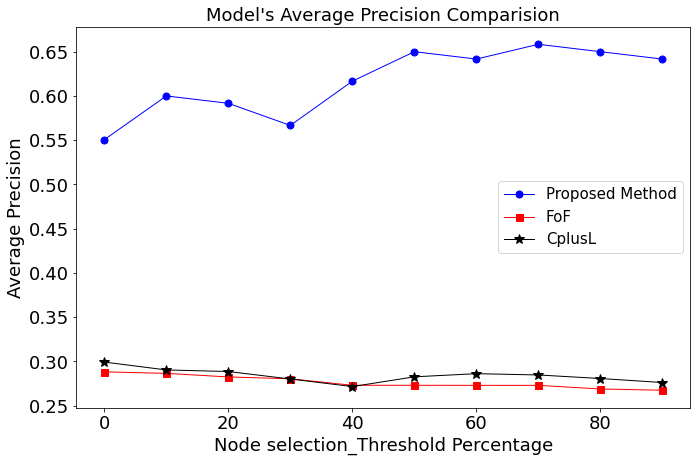

In [75]:
weight = np.arange(0, 100, 10)
plt.figure(figsize=(11, 7))
plt.plot(weight, avg_prop_preList,color='blue', marker='o', linewidth=1, markersize=7, label='Proposed Method')
# plt.plot(weight, firstB_preList, color='green', marker='^', linewidth=1, markersize=9, label='Baseline 1')
plt.plot(weight, avg_secondB_preList, color='red', marker='s', linewidth=1, markersize=7, label='FoF')
plt.plot(weight, avg_thirdB_preList, color='black', marker='*', linewidth=1, markersize=11, label='CplusL')
plt.xlabel('Node selection_Threshold Percentage', fontsize=18)
plt.ylabel('Average Precision', fontsize=18)
plt.title("Model's Average Precision Comparision", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

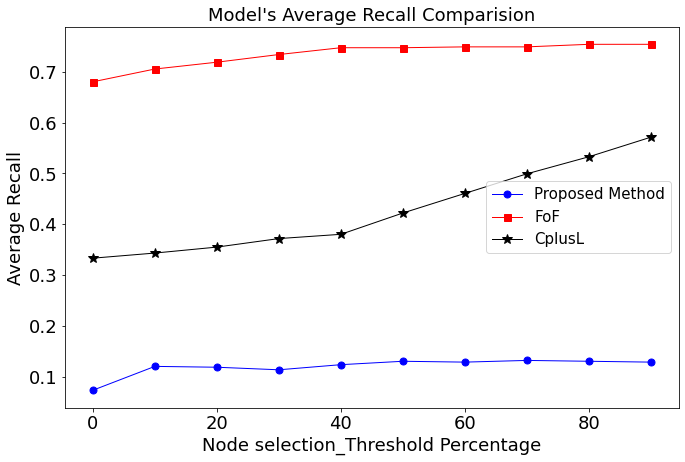

In [76]:
plt.figure(figsize=(11, 7))
plt.plot(weight, avg_prop_recList,color='blue', marker='o', linewidth=1, markersize=7, label='Proposed Method')
# plt.plot(weight, firstB_recList, color='green', marker='^', linewidth=1, markersize=9, label='Baseline 1')
plt.plot(weight, avg_secondB_recList, color='red', marker='s', linewidth=1, markersize=7, label='FoF')
plt.plot(weight, avg_thirdB_recList, color='black', marker='*', linewidth=1, markersize=11, label='CplusL')
plt.xlabel('Node selection_Threshold Percentage', fontsize=18)
plt.ylabel('Average Recall', fontsize=18)
plt.title("Model's Average Recall Comparision", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

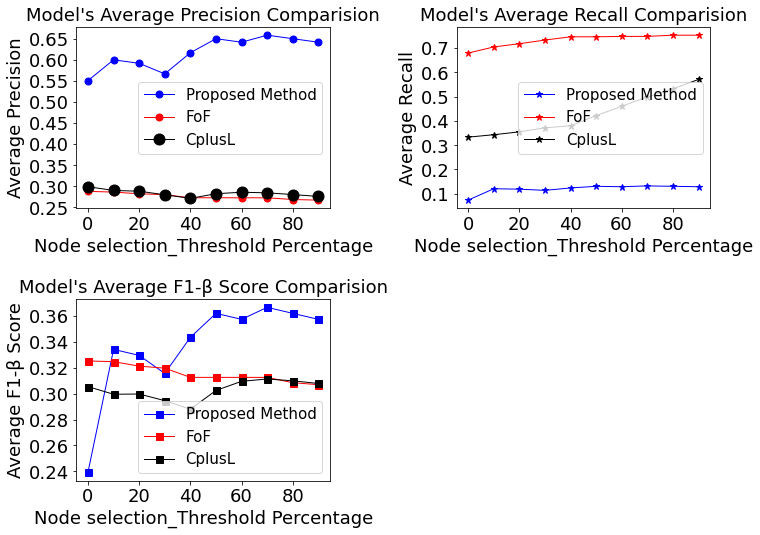

In [77]:
weight = np.arange(0, 100, 10)
plt.figure(figsize=(11, 7))
plt.subplot(2, 2, 1)
plt.plot(weight, avg_prop_preList,color='blue', marker='o', linewidth=1, markersize=7, label='Proposed Method')
# plt.plot(weight, firstB_preList, color='green', marker='^', linewidth=1, markersize=9, label='Baseline 1')
plt.plot(weight, avg_secondB_preList, color='red', marker='o', linewidth=1, markersize=7, label='FoF')
plt.plot(weight, avg_thirdB_preList, color='black', marker='o', linewidth=1, markersize=11, label='CplusL')
plt.xlabel('Node selection_Threshold Percentage', fontsize=18)
plt.ylabel('Average Precision', fontsize=18)
plt.title("Model's Average Precision Comparision", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(weight, avg_prop_recList,color='blue', marker='*', linewidth=1, markersize=7, label='Proposed Method')
plt.plot(weight, avg_secondB_recList,color='red', marker='*', linewidth=1, markersize=7, label='FoF')
plt.plot(weight, avg_thirdB_recList,color='black', marker='*', linewidth=1, markersize=7, label='CplusL')
plt.xlabel('Node selection_Threshold Percentage', fontsize=18)
plt.ylabel('Average Recall', fontsize=18)
plt.title("Model's Average Recall Comparision", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(weight, avg_prop_f1List,color='blue', marker='s', linewidth=1, markersize=7, label='Proposed Method')
plt.plot(weight, avg_secondB_f1List,color='red', marker='s', linewidth=1, markersize=7, label='FoF')
plt.plot(weight, avg_thirdB_f1List,color='black', marker='s', linewidth=1, markersize=7, label='CplusL')

plt.xlabel('Node selection_Threshold Percentage', fontsize=18)
plt.ylabel('Average F1-β Score', fontsize=18)
plt.title("Model's Average F1-β Score Comparision", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=1, wspace=0.5, hspace=0.5)
plt.show()

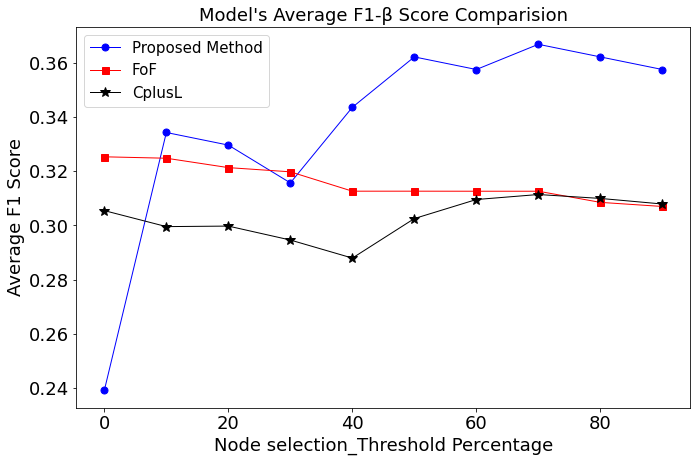

In [78]:
plt.figure(figsize=(11, 7))
plt.plot(weight, avg_prop_f1List,color='blue', marker='o', linewidth=1, markersize=7, label='Proposed Method')
# plt.plot(weight, firstB_f1List, color='green', marker='^', linewidth=1, markersize=9, label='Baseline 1')
plt.plot(weight, avg_secondB_f1List, color='red', marker='s', linewidth=1, markersize=7, label='FoF')
plt.plot(weight, avg_thirdB_f1List, color='black', marker='*', linewidth=1, markersize=11, label='CplusL')
plt.xlabel('Node selection_Threshold Percentage',fontsize=18)
plt.ylabel('Average F1 Score',fontsize=18)
plt.title("Model's Average F1-β Score Comparision",fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [79]:
### Just for Test Purpose ###
print("avg_prop_preList-> ", avg_prop_preList)
print("avg_prop_recList-> ", avg_prop_recList)
print("avg_prop_f1List-> ", avg_prop_f1List)

# print("avg_firstB_preList-> ", firstB_preList)
# print("avg_firstB_recList-> ", avg_firstB_recList)
# print("avg_firstB_f1List-> ", avg_firstB_f1List)

print("avg_secondB_preList-> ", secondB_preList)
print("avg_secondB_recList-> ", avg_secondB_recList)
print("avg_secondB_f1List-> ", avg_secondB_f1List)

print("avg_thirdB_preList-> ", avg_thirdB_preList)
print("avg_thirdB_recList-> ", avg_thirdB_recList)
print("avg_thirdB_f1List-> ", avg_thirdB_f1List)

avg_prop_preList->  [0.550573476702509, 0.6, 0.5916666666666667, 0.5666666666666667, 0.6166666666666667, 0.65, 0.6416666666666667, 0.6583333333333333, 0.65, 0.6416666666666666]
avg_prop_recList->  [0.07370184254606364, 0.1206030150753769, 0.11892797319932998, 0.11390284757118929, 0.12395309882747069, 0.1306532663316583, 0.12897822445561138, 0.13232830820770522, 0.1306532663316583, 0.12897822445561138]
avg_prop_f1List->  [0.23927911155929615, 0.3342618384401114, 0.32961931290622104, 0.3156917363045497, 0.3435468895078923, 0.3621169916434541, 0.3574744661095636, 0.3667595171773445, 0.3621169916434541, 0.3574744661095635]
avg_secondB_preList->  [0.27431906614785995, 0.2746212121212121, 0.27358490566037735, 0.2740740740740741, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26737967914438504]
avg_secondB_recList->  [0.6800670016750417, 0.7051926298157455, 0.7185929648241206, 0.7336683417085427, 0.747068676716918, 0.747068676716918,

In [ ]:
### Proposed Model result
prposed_resultList = model_performance_exhibition(recommended_UserIDwith_Score[0:math.ceil(len(recommended_UserIDwith_Score)*0.20)], True) ## Proposed model
proposed_precision = adaptive_precision(prposed_resultList)
proposed_recall = adaptive_recall([list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score])
print("f1_Score-> ", adaptive_F1score(proposed_precision, proposed_recall), "precision-> ", proposed_precision, "recall-> ", proposed_recall)

In [ ]:
### Model Iteration of Proposed model
seedList.extend([list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score[0:math.ceil(len(recommended_UserIDwith_Score)*0.20)]])

In [ ]:
### First Baseline
first_baseline_resultList = model_performance_exhibition(MPopular_baseLine[0:math.ceil(len(MPopular_baseLine)*0.20)], True)
first_baseline_precision = adaptive_precision(first_baseline_resultList)
first_baseline_recall = adaptive_recall([list(id_score.keys())[0] for id_score in MPopular_baseLine])
print("f1_Score-> ", adaptive_F1score(first_baseline_precision, first_baseline_recall), "precision-> ", first_baseline_precision, "recall-> ", first_baseline_recall)

In [ ]:
### Second baseline
second_baseline_resultList = model_performance_exhibition(list(FoF_baseline)[0:math.ceil(len(FoF_baseline)*0.20)], False)
second_baseline_precision = adaptive_precision(second_baseline_resultList)
second_baseline_recall = adaptive_recall(FoF_baseline)
print("f1_Score-> ", adaptive_F1score(second_baseline_precision, second_baseline_recall), "precision-> ", second_baseline_precision, "recall-> ", second_baseline_recall)

In [ ]:
third_baseline_resultList = model_performance_exhibition(list(CplusL_baseline)[0:math.ceil(len(CplusL_baseline)*0.20)], False)
third_baseline_precision = adaptive_precision(third_baseline_resultList)
third_baseline_recall = adaptive_recall(CplusL_baseline)
print("f1_Score-> ", adaptive_F1score(third_baseline_precision, third_baseline_recall), "precision-> ", third_baseline_precision, "recall-> ", third_baseline_recall)

## Using LDA Validation ##

In [ ]:
recomUser_AllText = list()
for recomUser in recommended_UserIDwith_Score:
    recomUser_AllText.append(userIdDict[list(recomUser.keys())[0]]['AllText'])

In [ ]:
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens



nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)


nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


text_data = []
for allText in recomUser_AllText:
    tokens = prepare_text_for_lda(allText)
#     print(tokens)
    text_data.append(tokens)


dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
for i, seedNode in enumerate(seedList):
    print(seedNode,"Seed Node",i,"-> ", userIdDict[seedNode]['AllText'])
#     new_doc = prepare_text_for_lda(userIdDict[list(recomUser.keys())[0]]['AllText'])
    print(set(new_doc))
    new_doc_bow = dictionary.doc2bow(new_doc)
#     print(new_doc_bow)
#     print(ldamodel.get_document_topics(new_doc_bow))

In [ ]:
## Using LDA Ends ##

In [ ]:
avg_prop_preList=[0.6, 0.611111111111111, 0.7222222222222223, 0.7888888888888889, 0.7333333333333334, 0.7111111111111109, 0.7333333333333333, 0.7555555555555555, 0.7777777777777778, 0.7888888888888891]
avg_secondB_preList=[0.27431906614785995, 0.2746212121212121, 0.27358490566037735, 0.2740740740740741, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26737967914438504]
avg_thirdB_preList=[0.2992200345141522, 0.29003572289380103, 0.28742411178388155, 0.28257817565993665, 0.27339878683862934, 0.2851451097953313, 0.280187063280451, 0.2876138166894896, 0.2747310153533871, 0.2779381051832162]


avg_prop_recList=[0.09045226130653265, 0.09212730318257956, 0.10887772194304858, 0.11892797319932998, 0.11055276381909547, 0.10720268006700168, 0.11055276381909547, 0.11390284757118929, 0.11725293132328307, 0.11892797319932998]
avg_secondB_recList=[0.6800670016750417, 0.7035175879396984, 0.7185929648241206, 0.7336683417085427, 0.747068676716918, 0.747068676716918, 0.7487437185929648, 0.7487437185929648, 0.7537688442211056, 0.7537688442211056]
avg_thirdB_recList=[0.3333333333333333, 0.3417085427135678, 0.35510887772194305, 0.37520938023450584, 0.3869346733668342, 0.43216080402010054, 0.4673366834170854, 0.5226130653266332, 0.5628140703517588, 0.6415410385259631]


avg_prop_f1List=[0.28213166144200624, 0.2873563218390805, 0.3396029258098224, 0.37095088819226746, 0.3448275862068966, 0.33437826541274823, 0.34482758620689663, 0.3552769070010449, 0.3657262277951933, 0.37095088819226746]
avg_secondB_f1List=[0.32530562429469345, 0.3247799860633663, 0.32132074141062, 0.32123932539587713, 0.3126363832246185, 0.3126363832246185, 0.31261687705059465, 0.31261687705059465, 0.3085150143973673, 0.30699959066721244]
avg_thirdB_f1List=[0.30547223786641026, 0.29907979914737953, 0.29881089931217786, 0.2972435577226451, 0.29044328663950436, 0.30595912366381184, 0.3045801098320875, 0.3160338541099063, 0.30606294227420355, 0.31347085677958614]